# Polymer analysis

## Purpose
The purpose of this notebook is to understand the 'traditional' solution for the polymer flood. The solution turned out to be more complex than initially anticipated, in particular, when the initial water saturation $S_{wi}$ is varied or the oil Corey exponent is 1.

Very helpful paper:  
Johansen, Thormod, and Ragnar Winther. “The Solution of the Riemann Problem for a Hyperbolic System of Conservation Laws Modeling Polymer Flooding.” SIAM Journal on Mathematical Analysis 19, no. 3 (May 1988): 541–66. https://doi.org/10.1137/0519039.

## Equations

The following equations need to be solved:
$$
\begin{cases}
 \phi \dfrac{\partial}{\partial t}\left( S_w \right) + u \dfrac{\partial}{\partial x}\left( f_w \right) = 0 \\
 \\
 \phi \dfrac{\partial}{\partial t}\left( S_w C_w + \dfrac{(1-\phi)}{\phi})\dfrac{\rho_s}{\rho_w} C_s \right) + u \dfrac{\partial}{\partial x}(f_w C_w) = 0

\end{cases}
$$
with the boundary and initial conditions:
$$
\begin{cases}
S_w(0,t) &= S_{winj} = 1 - S_{orw} \\
C_w(0,t) &= C_{inj} \\
S_w(x,0) &= S_{wi} \\
C(_wx,0) &= 0 
\end{cases}
$$
with $t \geq 0$ and $ 0 \leq x \leq L$.

In the above equations $S_w$, $C_w$ and $C_s$ are the water saturation, polymer mass fractions in the water resp. solid. Moreover, $u$ is the total fluid rate, $\phi$ the porosity and $\rho_w$ and $\rho_s$ are the water resp. rock densities. $f_w$ is the fractional flow of water, given by:
$$
f_w = \dfrac{u_w}{u} = \left. \dfrac{k_{rw}}{\mu_w} \middle/ \left( \dfrac{k_{rw}}{\mu_w} + 
\dfrac{k_{ro}}{\mu_o}\right) \right.
$$
where $u_w$ is the water rate, $k_{rw}$ and $k_{ro}$ are the aqueous resp. oil relative permeabilities and $\mu_w$ and $\mu_{o}$ the aqueous resp. oil viscosities. It is assumed that the relative permeabilities are only dependent on $S_w$ and the aqeous viscosity only a function of $C_w$. Finally, $S_{winj}$ is the water saturation corresponding to pure aqueous injection, i.e. $f_w = 1$ at $x=0$, $S_{wi}$ is the initial water saturation in the 'reservoir' and $C_{inj}$ the mass fraction of polymer in the injection solution.

The following dimensionless variables are introduced:
$$
\begin{align}
x_D &= \frac{x}{L}\\
t_D &= \frac{u}{\phi L}t = \frac{Q_{inj}}{V_p} \\
C &= \frac{C_w}{C_{inj}}
\end{align}
$$
Moreover, it is convenient to introduce:
$$
\begin{align}
S &= \frac{(S_w-S_{cw})}{(1-S_{cw}-S_{orw})} \\
a &= \frac{(1-\phi)}{\phi})\frac{\rho_s}{\rho_w} \frac{C_s}{C_{inj}}
\end{align}
$$
The variable $S$ is used for internal calculations of the relperms and fractional flow curves.  
With the above the equations become:
$$
\begin{cases}
 \dfrac{\partial}{\partial t_D} \left( S_w \right)+ \dfrac{\partial}{\partial x_D} \left( f_w \right)= 0 \\
 \\
 \dfrac{\partial}{\partial t_D}\left( S_w C + a \right) + \dfrac{\partial}{\partial x_D}(f_w C) = 0

\end{cases}
$$

By differentiating out the above equations and using the first equation to simplify the second, we get
$$
\begin{cases}
       \dfrac{\partial S_w}{\partial t_D}  &+& 
       \dfrac{\partial f_w}{\partial S_w} \dfrac{\partial S_w}{\partial x_D} &+& 
       \dfrac{\partial f_w}{\partial C} \dfrac{\partial C }{\partial x_D} &=0 \\
       \\
       \dfrac{\partial C}{\partial t_D}  & & &+&
       \dfrac{f_w}{S_w + \frac{d a}{d C}} \dfrac{\partial C}{\partial x_D} &=0
\end{cases}
$$

## Equations in matrix form

In matrix form we have:
$$
\begin{gather}
  \begin{pmatrix} S_w \\ C \end{pmatrix}_{tD} + A \left( S_w,C \right) \begin{pmatrix} S_w \\ C \end{pmatrix}_{xD} = 0

\end{gather}
$$
where the matrix $A$ is given by:
$$
A\left(S_w,C\right) = df_w = \begin{pmatrix} \dfrac{\partial f_w}{\partial S_w} & \dfrac{\partial f_w}{\partial C} \\
                                                \\
                                                0 & \dfrac{f_w}{S_w + \frac{d a}{d C}}
                               \end{pmatrix}
$$

## Eigenvalues and eigenvectors
The eigenvalues of the matrix $A$ are given by:
$$
\begin{align}
   \lambda_S & =  \dfrac{\partial f_w}{\partial S_w} \\
   \lambda_C & =  \dfrac{f_w}{S_w + \frac{d a}{d C}}
\end{align}
$$

The corresponding eigenvectors are:
$$
\begin{align}
   r_S &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\
   r_C &= \begin{pmatrix} \dfrac{\partial f_w}{\partial C}  \\ 
                            \dfrac{f_w}{S_w + \frac{d a}{d C}} - \dfrac{\partial f_w}{\partial S_w}
           \end{pmatrix}
\end{align}
$$

The eigenvalues $\lambda_S$ and $\lambda_C$ are the speeds of the S- resp. C- wave rarefactions. Note that there is no ranking in speed, i.e. $\lambda_S \leq \lambda_C$ does not hold, as the problem is non-convex.

In this notebook we will investigate S- and C-wave integral curves and Hugoniot loci to better understand the construction of the polymer solution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import brentq
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from bisect import bisect_left

import polymer_Sw_util as pu

# Input parameters

## Parametrization
The following parametrizations are used for the input paramters:
* Corey parametrization for the relative permeabilities:  
  $$
  \begin{align}
  k_{rw}(S_w) & = k^e_{rw} S^{n_w} \\
  k_{ro}(S_w) & = k^e_{ro} (1-S)^{n_o}
  \end{align}
  $$
  with $S = \dfrac{(S_w-S_{cw})}{(1-S_{cw}-S_{orw})}$  
* Viscosity of polymer solution is given by: 
  $$
  \mu(C) = \mu_w \left( 1 + \dfrac{(\mu_p -\mu_w)}{\mu_w} C \right)
  $$
  where $\mu_w$ is the water viscosity and $\mu_p$ the polymer solution viscosity at injection concentration.
* Langmuir isotherm for the polymer adsorption:
  $$
  a(C) = \dfrac{\text{ad}_1 C}{1+\text{ad}_2 C}
  $$

## Conditions on the parameters
For the relative permeabilities we require:
$$
k^e_{rw}, k^e_{ro} > 0 \\
n_w, n_o \geq 1 \\
0 < S_{cw} < 1-S_{orw}< 1 \\
$$
The solution in this code has only been tested for Corey exponents in the above range, not investigated what happens for smaller exponents.  
The following condition on the polymer viscosity ensures that $\partial f_w / \partial C < 0$ which is used in the construction of the solution:
$$
\mu_w \leq \mu_p
$$
If adsorption is included, the solution requires $\frac{da}{dC} >0$ and $\frac{d^2a}{dC^2} <0$ which implies:
$$
\text{ad}_1 > 0 \\
\text{ad}_2 > 0
$$
Without adsorption: $\text{ad}_1 = 0$, no requirement on $\text{ad}_2$.

In [2]:
# Initialize the polymer model

phi   = 0.2  # rock porosity
rho_s = 2500 # rock density in kg/m3
rho_w = 1000 # water density in kg/m3
Cinj  = 0.25 # wt% polymer in water
Cs    = 40   # adsorption on rock in micro gram / g rock
Dads = (1.0-phi)/phi * rho_s/rho_w * (Cs*1e-6)/(Cinj*0.01) # dimensionless adsorption parameter
print(f'Dads = {Dads:6.4f}')
# With the adsorption parameters below the polymer model will replicate the standard MOC solution
ad1 = 2.0*Dads
ad2 = 1.0

# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params = { 'krwe': 1.0, 'nw': 3.0, 'Scw': 0.1,
           'kroe': 1.0, 'no': 3.0, 'Sorw': 0.1,
           'muo': 20.0, 'muw': 1.0, 'mup': 10.0,
           'ad1': ad1, 'ad2': ad2 }

ff = pu.FracFlow(params_dict = params)

Dads = 0.1600


# Description of the general solution

In the subsequent part of the notebook we will show that the solution of the 'polymer equations; consists of the following parts:
1) S-wave (C=1) rarefaction for (Sw=1-Sorw,C=1) to (Sw=Sw1,C=1) where Sw1 is found by solving:
   $$
   \lambda_S(S_{w1},C=1) = \dfrac{f_w(S_{w1},C=1)}{S_{w1} + a(C=1)}
   $$
2) C-wave shock from (Sw1,C=1) to (Sw2,C=0) where Sw2 is found by solving (this equation in general has two solution, Sw2 is the solution smaller than Sw1):
   $$
   \dfrac{f_w(S_{w2})}{S_{w2}+a(C=1)} = \dfrac{f_w(S_{w1})}{S_{w1}+a(C=1)}
   $$
3) S-wave (C=0) from (Sw2,C=0) to (Swi,C=0) a la Buckley Leverett, i.e. one of the following dependending on the value of Swi:  
    * S-wave shock
    * S-wave rarefaction
    * S-wave rarefaction followed by a S-wave shock. Transition from rarefaction to shock takes place in Sw3 which can be found by solving:
    $$
    \lambda_S(S_{w3},C=0) = \dfrac{f_w(S_{w3},C=0)-f_w(S_{wi},C=0)}{S_{w3}-S_{wi}}
    $$

The above solution holds as long as Swi <= Sw2_alt which is found by solving (same equation as for Sw2, but now we look for the solution larger than Sw1):
   $$
   \dfrac{f_w(S_{w2-alt})}{S_{w2-alt}+a(C=1)} = \dfrac{f_w(S_{w1})}{S_{w1}+a(C=1)}
   $$

For Swi > Sw2_alt the solution consists of:
1) S-wave rarefaction (C=1) from (Sw=1-Sorw,C=1) to (Sw1_hi,C=1) where Sw1_hi can be found be solving:
  $$
   \dfrac{f_w(S_{w1-hi})}{S_{w1-hi}+a(C=1)} = \dfrac{f_w(S_{wi})}{S_{wi}+a(C=1)}
   $$
2) C-wave shock from (Sw1_hi,C=1) to (Swi,C=0)

Below the graphical solution of the two scenarios is shown. In the subsequent sections of the notebook the construction of the solutions will be explained.

N.B. 1: if the oil Corey exponent, no, is equal to 1, other solutions exists. They will be discussed in a later part of this notebook  
N.B. 2: in the above formulae $a(C=1)$ comes from:
$$
D(C=1,C=0) =\dfrac{a(C=1)-a(C=1)}{1-0}=a(C=1)
$$
where we used $a(C=0)=0$.

Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave shock speed = 2.5077
Sw1_hi = 0.6749
lamS(Sw=Sw1_hi,C=1) = 0.5248
C-wave shock speed = 1.1629


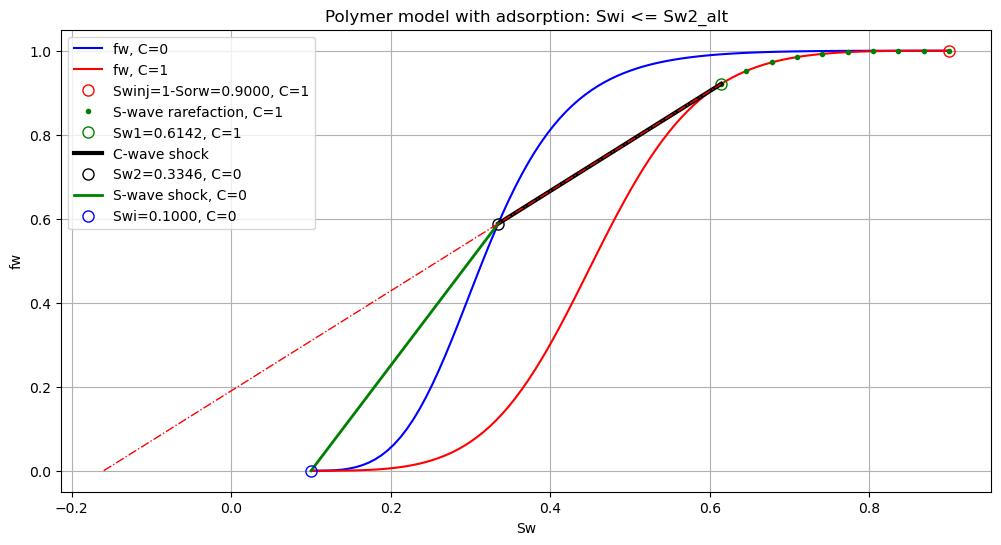

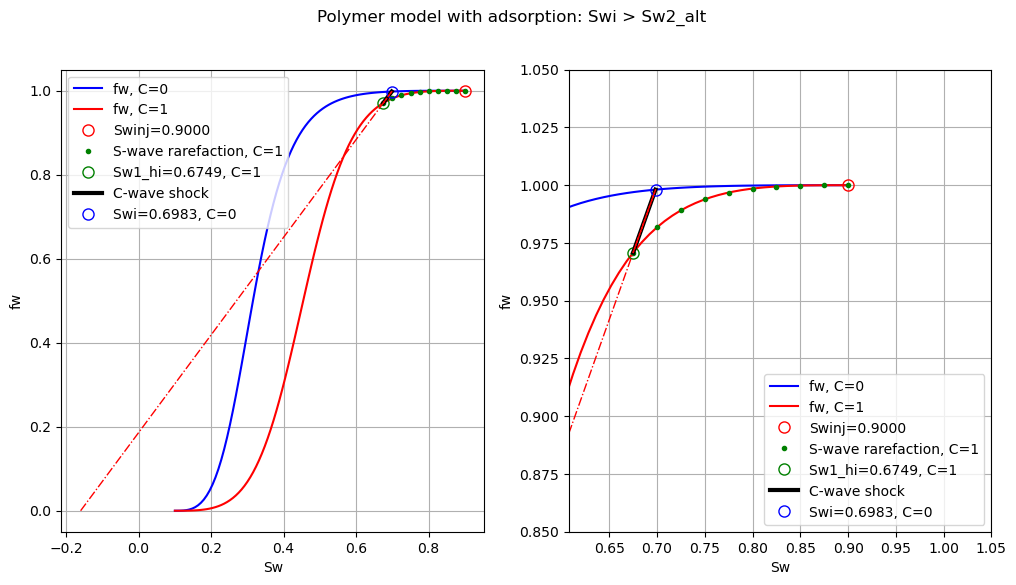

In [3]:
ff = pu.FracFlow(params_dict = params)
fig, ax = ff.plot_solution()
ax.set_title('Polymer model with adsorption: Swi <= Sw2_alt')
ff.set_Swi(ff.Sw2_alt+0.02)
fig, ax = ff.plot_solution()
fig.suptitle('Polymer model with adsorption: Swi > Sw2_alt')
ff = pu.FracFlow(params_dict = params)

# Fractional flow curves
The fractional flow curves are plotted at injection $C=1$ and intial $C=0$ conditions

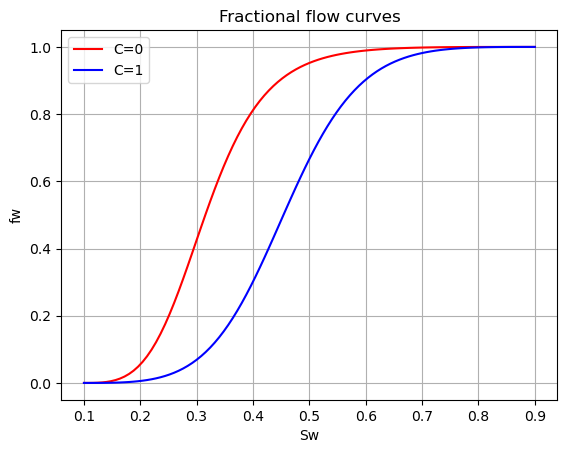

In [4]:
Ss = np.linspace(ff.Scw,1.0-ff.Sorw,101)
plt.plot(Ss,ff.fw(Ss,0),'r-',label='C=0')
plt.plot(Ss,ff.fw(Ss,1),'b-',label='C=1')
plt.title("Fractional flow curves")
plt.legend()
plt.grid()
plt.xlabel('Sw')
plt.ylabel('fw');

# Eigenvalues 
The eigenvalues of the matrix $A$:
$$
A\left(S_w,C\right) = df_w = \begin{pmatrix} \dfrac{\partial f_w}{\partial S_w} & \dfrac{\partial f_w}{\partial C} \\
                                                \\
                                                0 & \dfrac{f_w}{S_w + \frac{d a}{d C}}
                               \end{pmatrix}
$$
are given by:
$$
\begin{align}
   \lambda_S & =  \dfrac{\partial f_w}{\partial S_w} \\
   \lambda_C & =  \dfrac{f_w}{S_w + \frac{d a}{d C}}
\end{align}
$$

The corresponding eigenvectors are:
$$
\begin{align}
   r_S &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\
   r_C &= \begin{pmatrix} \dfrac{\partial f_w}{\partial C^*}  \\ 
                            \dfrac{f_w}{S_w + \frac{d a}{d C^*}} - \dfrac{\partial f_w}{\partial S_w}
           \end{pmatrix}
\end{align}
$$

The eigenvalues $\lambda_S$ and $\lambda_C$ are the speeds of the S- resp. C- wave rarefactions. Note that there is no ranking in speed, i.e. $\lambda_S \leq \lambda_C$ does not hold, as the problem is non-convex. Also note that for $S_w>S_{cw}$ there is a single intersection point between $\lambda_S$ and $\lambda_C$.

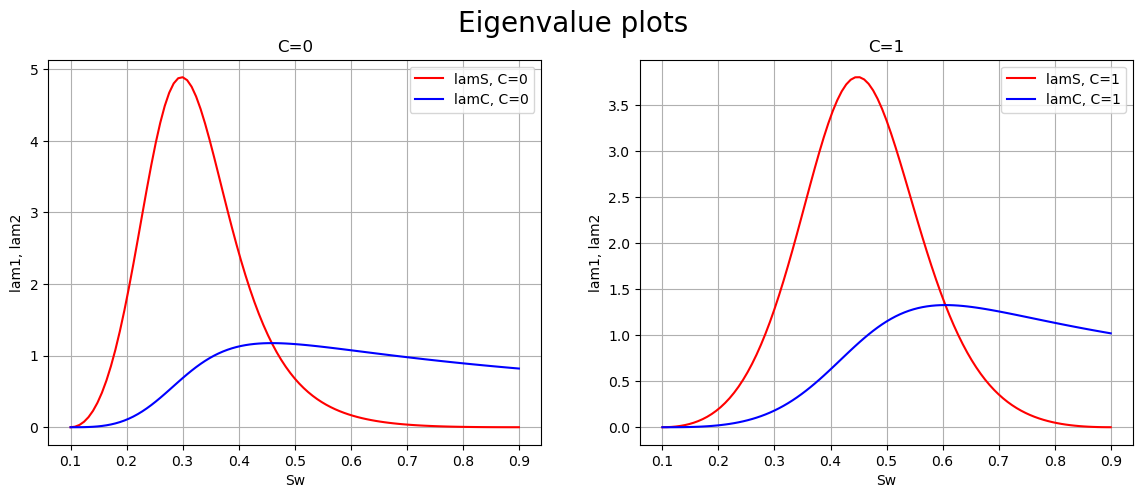

In [5]:
Ss = np.linspace(ff.Scw,1.0-ff.Sorw,101)
fig, ax = plt.subplots(1,2, figsize=(14,5))
fig.suptitle('Eigenvalue plots', fontsize=20)
ax[0].plot(Ss,ff.lamS(Ss,0),'r-', label='lamS, C=0')
ax[0].plot(Ss,ff.lamC(Ss,0),'b-', label='lamC, C=0')
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('lam1, lam2')
ax[0].set_title('C=0')
ax[0].legend()
ax[0].grid()
ax[1].plot(Ss,ff.lamS(Ss,1),'r-', label='lamS, C=1')
ax[1].plot(Ss,ff.lamC(Ss,1),'b-', label='lamC, C=1')
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('lam1, lam2')
ax[1].set_title('C=1')
ax[1].legend()
ax[1].grid()

## Transition curve: $\lambda_S = \lambda_C$
Although the eigenvalues are not strictly ordered, one can identify areas in the state space $(S_w,C)$ where they are ordered. In the plot below we have $\lambda_S > \lambda_C$ in the yellow area (left of the transition curve) and 
$\lambda_S < \lambda_C$ in the purple area (right of the transition curve).

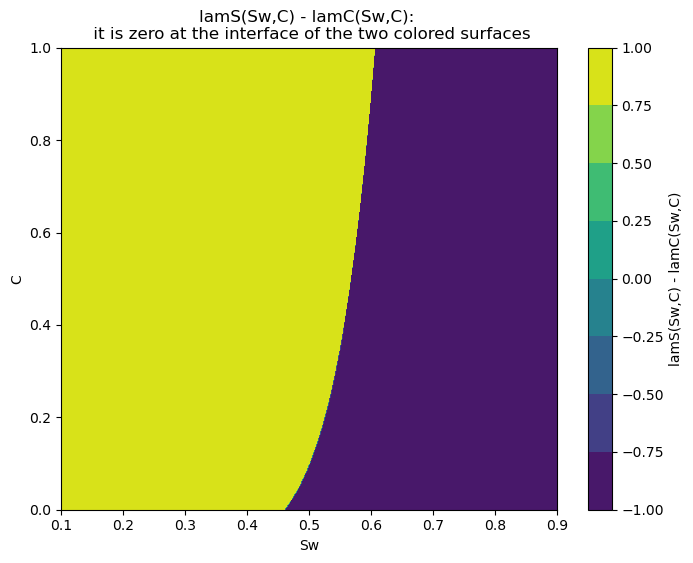

In [6]:
def Step(x):
    # Step function: returns -1 if x<=0, else 1
    return np.where(x<=0,-1,1)

def dif_lamS_lamC(Sw,C,ff):
    return ff.lamS(Sw,C) - ff.lamC(Sw,C)


Sw = np.linspace(ff.Scw,1.0-ff.Sorw, 501)
C  = np.linspace(0,1,501)
Sx, Cy = np.meshgrid(Sw, C)
Dif_Lam1_Lam2 = Step(dif_lamS_lamC(Sx,Cy,ff))

plt.figure(figsize=(8,6))
plt.contourf(Sx, Cy, Dif_Lam1_Lam2, cmap='viridis')
plt.colorbar(label = 'lamS(Sw,C) - lamC(Sw,C)')
plt.title(f'lamS(Sw,C) - lamC(Sw,C): \n it is zero at the interface of the two colored surfaces')
plt.xlabel('Sw')
plt.ylabel('C');

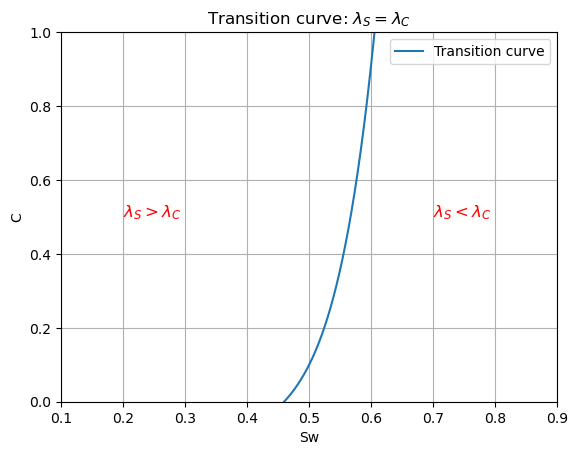

In [7]:
eps_S = 1e-8
Cs = np.linspace(0,1,1000)
Trans = pd.Series(name='Sw')
for C in Cs:
    Trans[C] = brentq(lambda Sw: dif_lamS_lamC(Sw,C=C,ff=ff),ff.Scw+eps_S,1-ff.Sorw)
Trans = Trans.to_frame().reset_index(names='C')

fig, ax = plt.subplots()
Trans.plot(x='Sw',y='C',ax=ax, label='Transition curve')
ax.text(0.2,0.5,r'$\lambda_S > \lambda_C$',fontsize=12, color='red')
ax.text(0.7,0.5,r'$\lambda_S < \lambda_C$',fontsize=12, color='red')
ax.set_title(r'Transition curve: $\lambda_S = \lambda_C$')  
ax.set_xlim(ff.Scw,1-ff.Sorw)
ax.set_ylim(0,1)
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.grid()

## Derivatives of the fractional flow curve
Below we show $\frac{\partial f_w}{\partial C}$ and $\frac{\partial^2 f_w}{\partial S^2_w}$ for $C=0$ and $C=1$. Obsevations:
1) The derivative of the fractional flow wrt C, $\frac{\partial f_w}{\partial C}$, is smaller than zero for $S_{cw} < S_w < 1-S_{row}$.
2) For each C, the fractional flow curve has a unique inflection point, $S^I_{w}$, such that the $\frac{\partial^2 f_w}{\partial S^2_w}$ is negative for $S_w < S^I_w$ and positive for  $S_w > S^I_w$ 

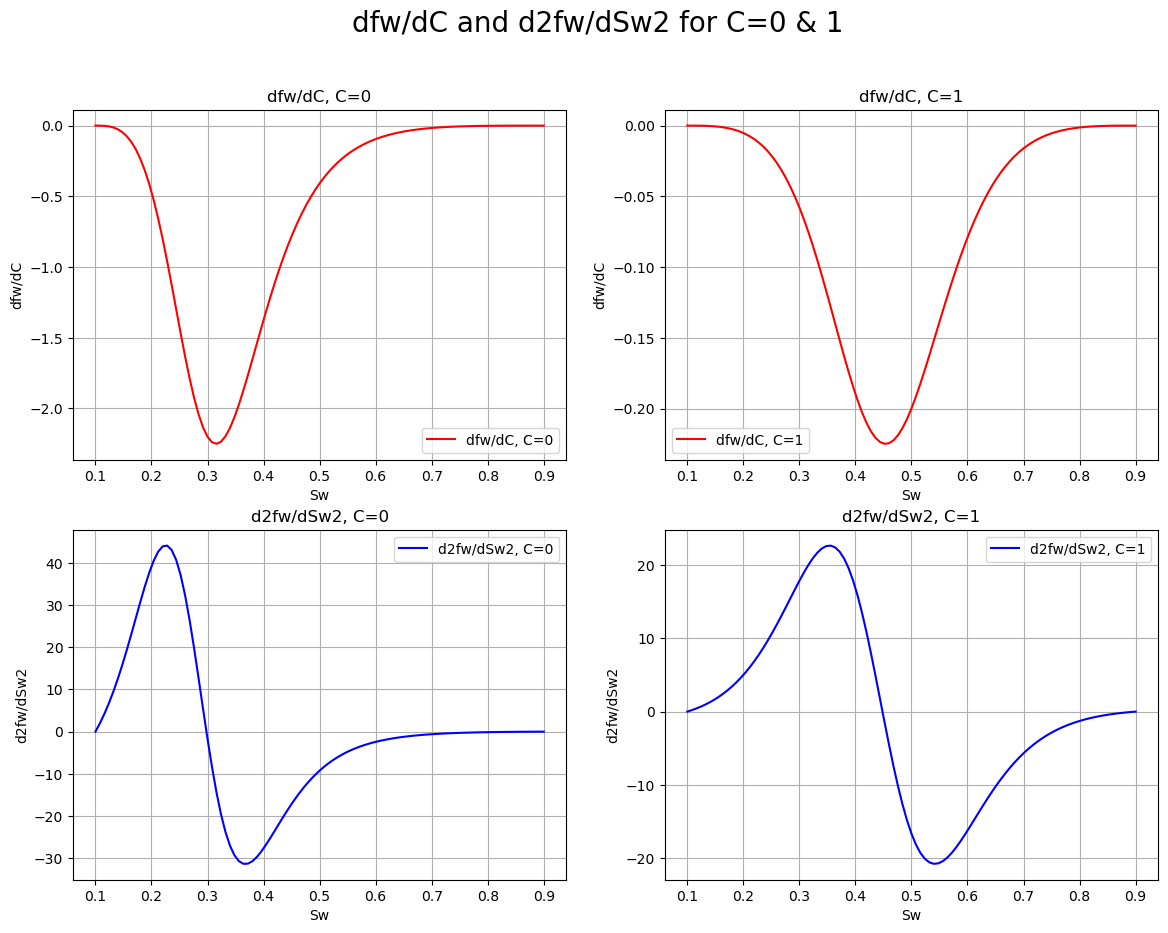

In [8]:
Ss = np.linspace(ff.Scw,1.0-ff.Sorw,101)
fig, ax = plt.subplots(2,2, figsize=(14,10))
fig.suptitle('dfw/dC and d2fw/dSw2 for C=0 & 1', fontsize=20)
ax[0,0].plot(Ss,ff.dfw_C(Ss,0),'r-', label='dfw/dC, C=0')
ax[0,0].set_xlabel('Sw')
ax[0,0].set_ylabel('dfw/dC')
ax[0,0].set_title('dfw/dC, C=0')
ax[0,0].legend()
ax[0,0].grid()
ax[0,1].plot(Ss,ff.dfw_C(Ss,1),'r-', label='dfw/dC, C=1')
ax[0,1].set_xlabel('Sw')
ax[0,1].set_ylabel('dfw/dC')
ax[0,1].set_title('dfw/dC, C=1')
ax[0,1].legend()
ax[0,1].grid()
ax[1,0].plot(Ss,ff.dfw_S2(Ss,0),'b-', label='d2fw/dSw2, C=0')
ax[1,0].set_xlabel('Sw')
ax[1,0].set_ylabel('d2fw/dSw2')
ax[1,0].set_title('d2fw/dSw2, C=0')
ax[1,0].legend()
ax[1,0].grid()
ax[1,1].plot(Ss,ff.dfw_S2(Ss,1),'b-', label='d2fw/dSw2, C=1')
ax[1,1].set_xlabel('Sw')
ax[1,1].set_ylabel('d2fw/dSw2')
ax[1,1].set_title('d2fw/dSw2, C=1')
ax[1,1].legend()
ax[1,1].grid()

# Integral curves

The relevance of knowing the integral curves is that they form the paths through which 'states' in the $(S_w, C)$ space can be connected to each other via rarefaction waves. As such, they form an essential ingredient in finding the solution of the polymer equations.

## Definition:
The integral curve is a smooth curve $\tilde{q}(\xi)$ through the state space $(S_w, C)$ parametrized by a scalar parameter $\xi$.  
$\tilde{q}(\xi)$ is an integral curve of the vector field $r_p\left(\tilde{q}(\xi)\right)$, if at each point $\tilde{q}(\xi)$, the tangent vector $\tilde{q'}(\xi)$ to the curve, is an eigenvector of $A\left(\tilde{q}(\xi)\right)$ corresponding to the eigenvalue $\lambda_p$, i.e. $\tilde{q'} = \alpha(\xi) r_2(\xi)$

Therefore, we have the following relation for the integral curves:
$$
A\left(\tilde{q}(\xi)\right) \tilde{q'}(\xi) = \lambda_p\left(\tilde{q}(\xi)\right) \tilde{q'}(\xi)
$$
Using this relation we find the following integral curves.  

### For the S-wave:
$$C'(\xi) = 0$$
which implies $C(\xi)=$ constant are the S-wave integral curves

### For the C-wave:  
$$
\left( \dfrac{\partial f_w}{\partial S_w} - \dfrac{f_w}{S_w + \frac{d a}{d C}} \right) S_w'(\xi) +
\dfrac{\partial f_w}{\partial C} {C}'(\xi) = 0
$$
This gives the following ODE for the C-wave integral curve:
$$
\dfrac{d C}{d S_w} = \left. \left( \dfrac{f_w}{S_w + \frac{d a}{d C}} -\dfrac{\partial f_w}{\partial S} \right) \middle/
                          \left( \dfrac{\partial f_w}{\partial C} \right)
                   \right.
$$


Note that
$$
\begin{align}
   \lambda_S & =  \dfrac{\partial f_w}{\partial S_w} \\
   \lambda_C & =  \dfrac{f_w}{S_w + \frac{d a}{d C}}
\end{align}
$$

Therefore, one can write
$$
\dfrac{\partial f_w}{\partial C} \dfrac{dC}{dS_w} = \lambda_C - \lambda_S 
$$




For determining the integral curve it is sometimes useful to use the 'inverse' expression as ODE:
$$
\dfrac{d S_w}{d C} = \left. \left( \dfrac{\partial f_w}{\partial C} \right) \middle/
                          \left( \lambda_C - \lambda_S \right) 
                   \right.
$$

Note that $\dfrac{dS_w}{dC}$ has a singularity at the intersection of $\lambda_S$ and $\lambda_C$ (which we discussed earlier). 

### C-wave speed on the integral curve
With a bit of algebra on can show that on a C-wave integral curve $C(S_w)$ one has:
$$
\dfrac{d \lambda_C}{d S_w}(S_w,C(S_w)) = - \dfrac{d^2 a}{dC^2} \dfrac{d C}{d S_w} \dfrac{f_w}{(S_w + \frac{da}{dC})^2}
$$

We have $\dfrac{d^2 a}{dC^2}<0$ and from the expression for $\frac{dC}{d S_w}$ one can see that it is positive if the integral curve is left of the transition curve and negative if right of the transition curve (see figure below), because $\frac{\partial f_w}{\partial C}<0$.  
This means that $\lambda_C$ is increasing with $S_w$ in the left part of the state space and decreasing with $S_w$ in the right part of the state space. This information is useful when checking whether a solution path is properly ordered in speed, i.e. going from a left state $U_L$ to a right state $U_R$ the solution must be such that the speeds of the waves increase going from $U_L$ to $U_R$.

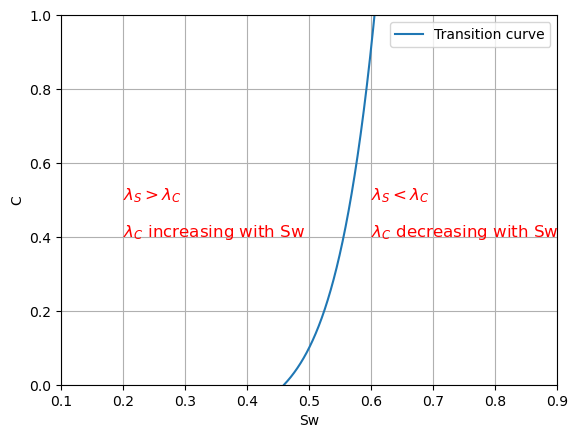

In [9]:
eps_S = 1e-8
Cs = np.linspace(0,1,1000)
Trans = pd.Series(name='Sw')
for C in Cs:
    Trans[C] = brentq(lambda Sw: dif_lamS_lamC(Sw,C=C,ff=ff),ff.Scw+eps_S,1-ff.Sorw)
Trans = Trans.to_frame().reset_index(names='C')

fig, ax = plt.subplots()
Trans.plot(x='Sw',y='C',ax=ax, label='Transition curve')
ax.text(0.2,0.5,r'$\lambda_S > \lambda_C$',fontsize=12, color='red')
ax.text(0.2,0.4,r'$\lambda_C$ increasing with Sw',fontsize=12, color='red')
ax.text(0.6,0.5,r'$\lambda_S < \lambda_C$',fontsize=12, color='red')
ax.text(0.6,0.4,r'$\lambda_C$ decreasing with Sw',fontsize=12, color='red')
ax.set_xlim(ff.Scw,1-ff.Sorw)
ax.set_ylim(0,1)
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.grid()

# Integral curves through $(S_w=1-S_{orw},C=1)$  

To investigate how the polymer solution 'starts' from the injection condition $(S_w=S_{winj}=1-S_{orw},C=1)$ we look at the integral curves through this state:  
* S-wave integral curve: C=1
* C-wave integral curve: solution to the ODE $dS_w / dC$ with boundary condition $S_w(C=1) =1-S_{orw}$.

## C-wave integral curve

The C-wave integral curve through $(S_w=1-S_{orw},C=1)$ is the curve $S_w=1-S_{orw}$. This result can be derived analytically and has also been checked below by:
1) Solving $dS_w/dC$ with $S_w = 1-S_{orw}$ at $C=1$.
2) Solving the coupled ODE's for $S_w$ and $C$ directly.

What is interesting is that the integral curve through $S_w = 1-S_{orw} -\epsilon$, with e.g $\epsilon=10^{-3}$, is more complex and has two 'arms' (which are connected at large C):
1) $S_w \sim 1-S_{orw}-\epsilon$, $C$ running from 0 to a large value
2) smooth curve from $(S_w \sim 1-S_{orw}-\epsilon,C=large)$ to $C=0$ for some $S_w$ well below $1-S_{orw}$

What seems to happen is that in the limit $\epsilon \rightarrow 0$, the smooth curve disappears.

### C-wave integral curve through (Sw=1-Sorw,C=1)

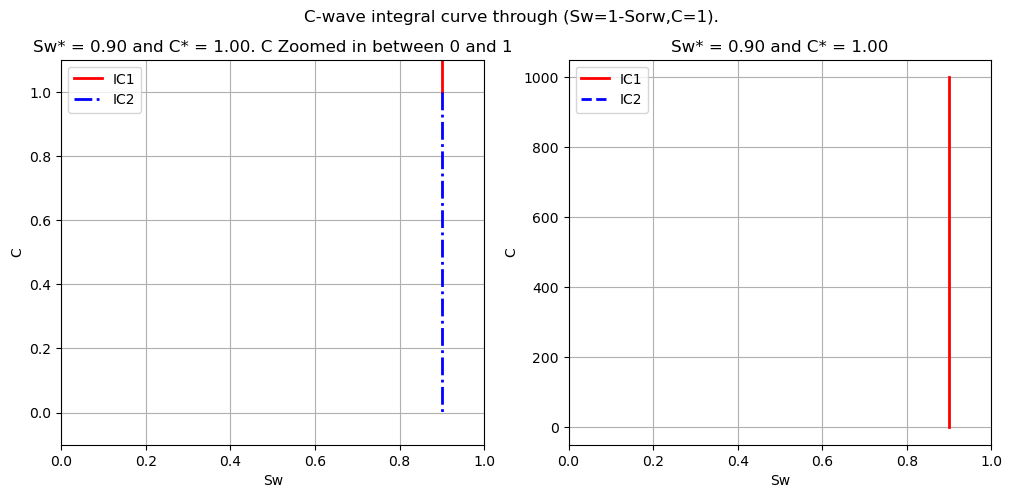

In [10]:
Sst= 1.0-ff.Sorw; Cst=1.0

# Integral curve on the branch C>=1
IC_C1 = np.linspace(1.0,1000,101)
IC_S1 = odeint(ff.dS_dC,Sst,IC_C1)
IC1 = pd.DataFrame(data={'Sw':IC_S1.T[0],'C':IC_C1})
#IC1 = IC1[IC1['C']>=0]

# Integral curve on the branch C<=1
IC_C2 = np.linspace(1.0,0.0,101)
IC_S2 = odeint(ff.dS_dC,Sst,IC_C1)
IC2 = pd.DataFrame(data={'Sw':IC_S2.T[0],'C':IC_C2})
#IC2 = IC2[IC2['C']>=0]

fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.suptitle(r'C-wave integral curve through (Sw=1-Sorw,C=1).')
IC1.plot(x='Sw',y='C', style='r-', ax=ax[0], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='b-.', ax=ax[0], label='IC2', lw=2)
ax[0].set_xlim(0.0,1.0)
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('C')
ax[0].set_title(f'Sw* = {Sst:4.2F} and C* = {Cst:4.2f}. C Zoomed in between 0 and 1')
ax[0].grid()

IC1.plot(x='Sw',y='C', style='r-', ax=ax[1], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='b--', ax=ax[1], label='IC2', lw=2)
ax[1].plot()
ax[1].set_xlim(0.,1.0)
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('C')
ax[1].set_title(f'Sw* = {Sst:4.2F} and C* = {Cst:4.2f}')
ax[1].grid()

In [11]:
# Integral curve via coupled ODE's for Sw and C
Sst=1.0-ff.Sorw; Cst=1.0
x0 = [Sst, Cst]
ksi1 = np.linspace(0,1000,100)
x1 = odeint(ff.IC_ODE, x0, ksi1)
ksi2 = np.linspace(0,-4,100)
x2 = odeint(ff.IC_ODE, x0, ksi2)



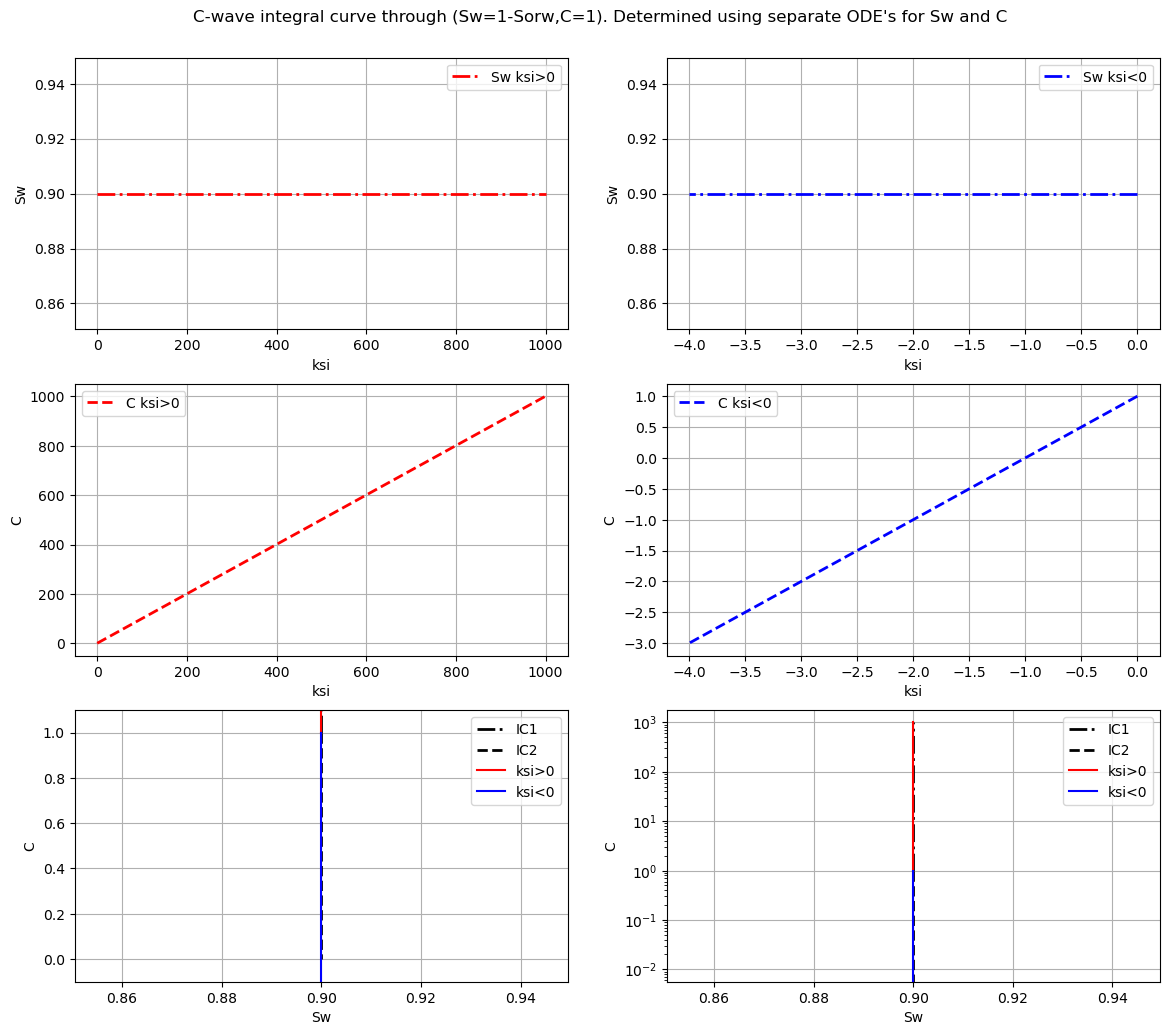

In [12]:
fig, ax = plt.subplots(3,2, figsize=(14,12))
fig.suptitle("C-wave integral curve through (Sw=1-Sorw,C=1). Determined using separate ODE's for Sw and C", y= 0.92)
ax[0,0].plot(ksi1,x1[:,0],'r-.',lw=2, label='Sw ksi>0')
ax[0,0].set_xlabel('ksi')
ax[0,0].set_ylabel('Sw')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(ksi2,x2[:,0],'b-.',lw=2, label='Sw ksi<0')
ax[0,1].set_xlabel('ksi')
ax[0,1].set_ylabel('Sw')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(ksi1,x1[:,1],'r--',lw=2, label='C ksi>0')
ax[1,0].set_xlabel('ksi')
ax[1,0].set_ylabel('C')
#ax[1,0].set_yscale('log')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(ksi2,x2[:,1],'b--',lw=2, label='C ksi<0')
ax[1,1].set_xlabel('ksi')
ax[1,1].set_ylabel('C')
ax[1,1].grid()
ax[1,1].legend()

IC1.plot(x='Sw',y='C', style='k-.', ax=ax[2,0], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='k--', ax=ax[2,0], label='IC2', lw=2)
ax[2,0].plot(x1[:,0],x1[:,1], 'r-', label='ksi>0')
ax[2,0].plot(x2[:,0],x2[:,1], 'b-', label='ksi<0')
ax[2,0].set_xlabel('Sw')
ax[2,0].set_ylabel('C')
ax[2,0].set_ylim(-0.1,1.1)
ax[2,0].grid()
ax[2,0].legend()

IC1.plot(x='Sw',y='C', style='k-.', ax=ax[2,1], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='k--', ax=ax[2,1], label='IC2', lw=2)
ax[2,1].plot(x1[:,0],x1[:,1], 'r-', label='ksi>0')
ax[2,1].plot(x2[:,0],x2[:,1], 'b-', label='ksi<0')
ax[2,1].set_xlabel('Sw')
ax[2,1].set_ylabel('C')
ax[2,1].set_yscale('log')
ax[2,1].grid()
ax[2,1].legend()

### C-wave integral curve through $(S_w=1-S_{orw}-\epsilon,C=1)$

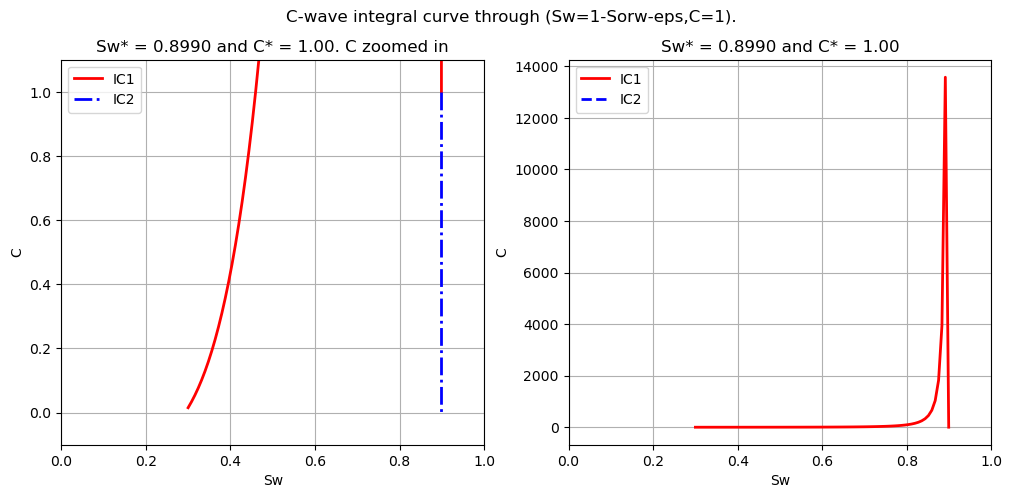

In [13]:
# Set epsilon value
eps = 1e-3
Sst= 1.0-eps-ff.Sorw; Cst=1.0

# Sw<Sst branch going through (Sw=Sst, C=1)
IC_S1 = np.linspace(Sst,ff.Scw,101)
IC_C1 = odeint(ff.dC_dS,Cst,IC_S1)
IC1 = pd.DataFrame(data={'Sw':IC_S1,'C':IC_C1.T[0]})
IC1 = IC1[IC1['C']>=0]

# Sw=Sst branch going through (Sw=Sst, C=1), C varies between 1 and zero
IC_C2 = np.linspace(1.0,0.0,101)
IC_S2 = odeint(ff.dS_dC,Sst,IC_C2)
IC2 = pd.DataFrame(data={'Sw':IC_S2.T[0],'C':IC_C2})
IC2 = IC2[IC2['C']>=0]

fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.suptitle(r'C-wave integral curve through (Sw=1-Sorw-eps,C=1).')
IC1.plot(x='Sw',y='C', style='r-', ax=ax[0], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='b-.', ax=ax[0], label='IC2', lw=2)
ax[0].set_xlim(0.0,1.0)
ax[0].set_ylim(-0.1,1.1)
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('C')
ax[0].set_title(f'Sw* = {Sst:6.4F} and C* = {Cst:4.2f}. C zoomed in')
ax[0].grid()

IC1.plot(x='Sw',y='C', style='r-', ax=ax[1], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='b--', ax=ax[1], label='IC2', lw=2)
ax[1].plot()
ax[1].set_xlim(0.,1.0)
# ax[1].set_ylim(-10,10)
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('C')
ax[1].set_title(f'Sw* = {Sst:6.4F} and C* = {Cst:4.2f}')
ax[1].grid()

In [14]:
# Integral curve via coupled ODE's for Sw and C
Sst=1.0-eps-ff.Sorw; Cst=1.0
x0 = [Sst, Cst]
ksi1 = np.linspace(0,1000000,2000000)
x1 = odeint(ff.IC_ODE, x0, ksi1)
ksi2 = np.linspace(0,-4,1000)
x2 = odeint(ff.IC_ODE, x0, ksi2)


### Be patient when generating the following plots. Slow due to much data

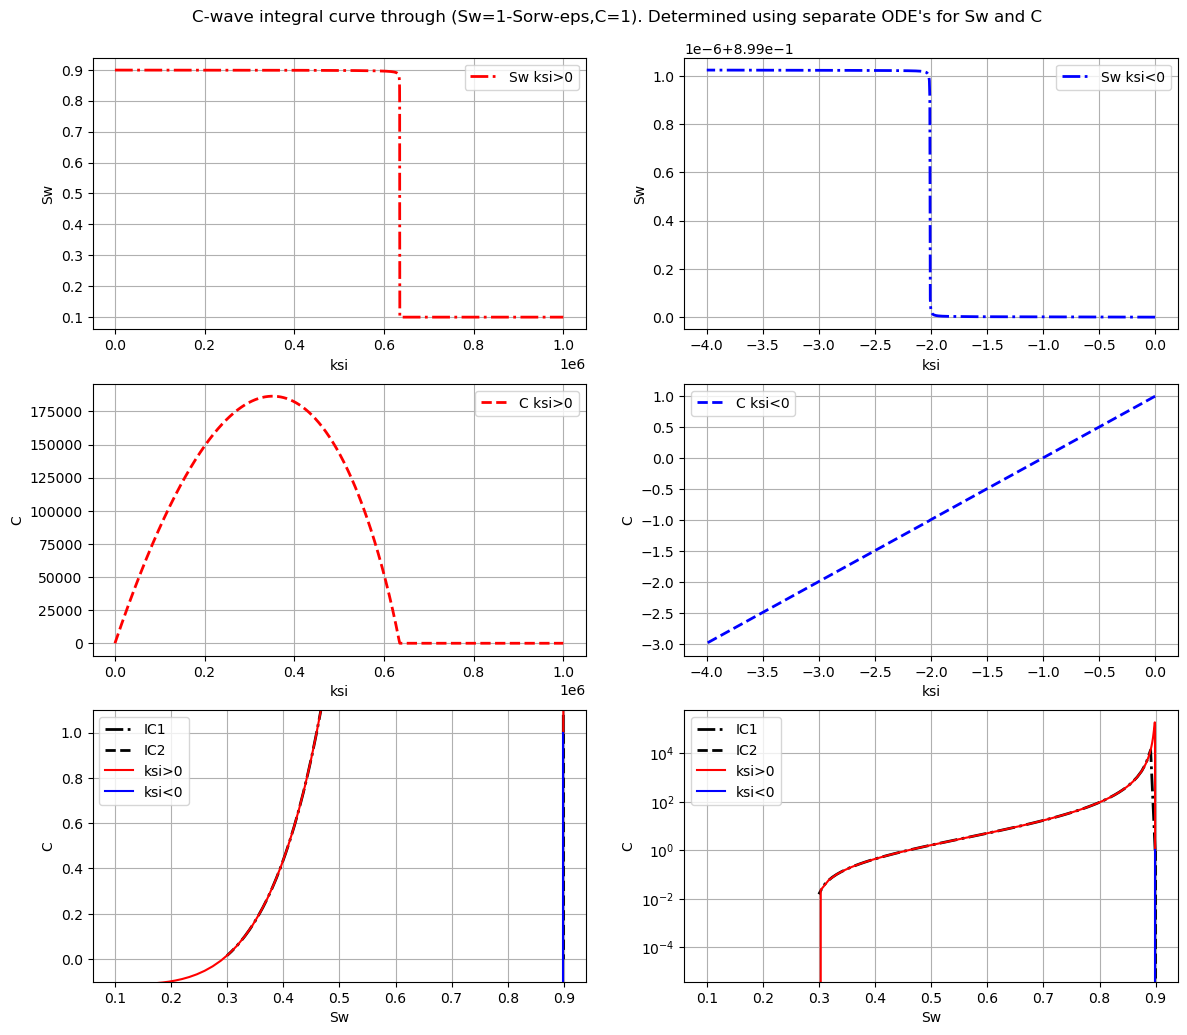

In [15]:
fig, ax = plt.subplots(3,2, figsize=(14,12))
fig.suptitle("C-wave integral curve through (Sw=1-Sorw-eps,C=1). Determined using separate ODE's for Sw and C", y= 0.92)
ax[0,0].plot(ksi1,x1[:,0],'r-.',lw=2, label='Sw ksi>0')
ax[0,0].set_xlabel('ksi')
ax[0,0].set_ylabel('Sw')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(ksi2,x2[:,0],'b-.',lw=2, label='Sw ksi<0')
ax[0,1].set_xlabel('ksi')
ax[0,1].set_ylabel('Sw')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(ksi1,x1[:,1],'r--',lw=2, label='C ksi>0')
ax[1,0].set_xlabel('ksi')
ax[1,0].set_ylabel('C')
#ax[1,0].set_yscale('log')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].plot(ksi2,x2[:,1],'b--',lw=2, label='C ksi<0')
ax[1,1].set_xlabel('ksi')
ax[1,1].set_ylabel('C')
ax[1,1].grid()
ax[1,1].legend()

IC1.plot(x='Sw',y='C', style='k-.', ax=ax[2,0], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='k--', ax=ax[2,0], label='IC2', lw=2)
ax[2,0].plot(x1[:,0],x1[:,1], 'r-', label='ksi>0')
ax[2,0].plot(x2[:,0],x2[:,1], 'b-', label='ksi<0')
ax[2,0].set_xlabel('Sw')
ax[2,0].set_ylabel('C')
ax[2,0].set_ylim(-0.1,1.1)
ax[2,0].grid()
ax[2,0].legend()

IC1.plot(x='Sw',y='C', style='k-.', ax=ax[2,1], label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='k--', ax=ax[2,1], label='IC2', lw=2)
ax[2,1].plot(x1[:,0],x1[:,1], 'r-', label='ksi>0')
ax[2,1].plot(x2[:,0],x2[:,1], 'b-', label='ksi<0')
ax[2,1].set_xlabel('Sw')
ax[2,1].set_ylabel('C')
ax[2,1].set_yscale('log')
ax[2,1].grid()
ax[2,1].legend()

# Hugoniot loci

'States' in the $(S_w, C)$ space can also be connected through shocks if the Rankine-Hugoniot 'jump' conditions are fulfilled. To determine the shock speeds one needs to go back to the 'original' conservation equations:
$$
\begin{cases}
 \dfrac{\partial}{\partial t_D} \left( S_w \right)+ \dfrac{\partial}{\partial x_D} \left( f_w \right)= 0 \\
 \\
 \dfrac{\partial}{\partial t_D}\left( S_w C + a \right) + \dfrac{\partial}{\partial x_D}(f_w C) = 0

\end{cases}
$$
From these equations one finds:
$$
\begin{align}
\sigma_1 &= \dfrac{f_w(S_w^+,C^+) - f_w(S_w^-,C^-)}{S_w^+ - S_w^-} \\
\\
\sigma_2 &= \dfrac{f_w(S_w^+,C^+) C^+ - f_w(S_w^-,C^-) C^-}{\left( S_w^+ C^+ + a(C^+) \right) -
                                           \left( S_w^- C^- + a(C^-) \right)}
\end{align}
$$
For a valid jump one needs $\sigma_1 = \sigma_2$.

## For the S-waves:  
The Hugoniot locus is the curve $C = \text{constant}$ and the shock speed is given by:
$$
\sigma_S = \dfrac{f_w(S_w^+,C) - f_w(S_w^-,C)}{S_w^+ - S_w^-}
$$
where the shock jumps from $(S_w^+,C)$ to $(S_w^-,C)$. $C$ remains constant in the jump.

## For the C-waves:
With some algebra one finds that the condition $\sigma_1 = \sigma_2$ leads to the following equations for the shock speed:
$$
\sigma_C = \dfrac{f_w(S_w^-,C^-)}{S_w^- + \frac{(a(C^+) - a(C^-))}{(C^+ - C^-)}} = 
         \dfrac{f_w(S_w^+,C^+)}{S_w^+ + \frac{(a(C^+) - a(C^-))}{(C^+ - C^-)}} = 
         \dfrac{f_w(S_w^+,C^+) - f_w(S_w^-,C^-)}{S_w^+ - S_w^-}
$$
The Hugoniot locus for a state $(S_w^+,C^+)$ can be found by finding the states $(S_w^-,C^-)$ that fulfill the equation:
$$
 \dfrac{f_w(S_w^-,C^-)}{S_w^- + \frac{(a(C^+) - a(C^-))}{(C^+ - C^-)}} = 
         \dfrac{f_w(S_w^+,C^+)}{S_w^+ + \frac{(a(C^+) - a(C^-))}{(C^+ - C^-)}}
$$



## Hugoniot loci through $(S_w=1-S_{orw},C=1)$  

To investigate how the polymer solution 'starts' from the injection condition $(S_w=S_{winj}=1-S_{orw},C=1)$ we also look at the Hugoniot loci through this state:  
* S-wave Hugoniot locus: C=1
* C-wave Hugoniot locus: states $(S_w^-,C^-)$ that fulfill the equation above with $(S_w^+,C^+)=(1-S_{orw},1)$

## C-wave Hugoniot locus  
For $(S_w=1-S_{orw},C=1)$ we find a Hugoniot locus with two branches, viz.:
1) a smooth curve that does not include $(S_w=1-S_{orw},C=1)$, but satisfies the Rankine-Hugoniot condition.
2) the curve $S_w=1-S_{orw}$

Note that the smooth curve has a shape similar to the integral curve through $(S_w=1-S_{orw}-\epsilon,C=1)$ with $\epsilon \neq 0$.

The entropy condition for admissible C-wave shocks $(S_L,C_L) -> (S_R,C_R)$:
1) $C_L > C_R$. This is OK as $C_L = 1$.
2) either $\lambda_S(S_R,C_R) < \sigma_C$ or $\lambda_S(S_L,C_L)$, $\lambda_S(S_R,C_R) \geq \sigma_C$ where $\sigma_C$ is the speed of the C-wave shock. 

To be discussed further below


### C-wave Hugoniot locus through (Sw=1-Sorw,C=1)

Text(0, 0.5, 'C')

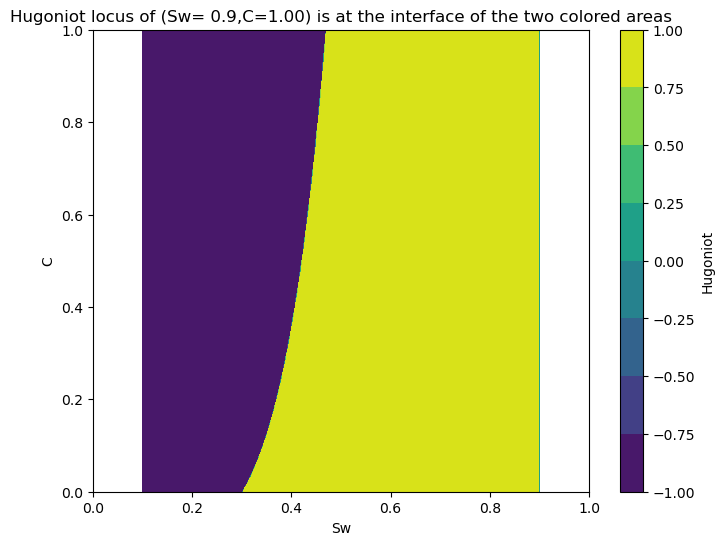

In [16]:
# Quick visualization of the Hugoniot locus
# Actually, the Hugoniot locus also includes Sw = 1.0-ff.Sorw

SL = 1.0-ff.Sorw; CL = 1.0

Sw = np.linspace(ff.Scw,1.0-ff.Sorw, 501)
C  = np.linspace(0,1,501)
Sx, Cy = np.meshgrid(Sw, C)
hugo_plot = Step(ff.hugo(Sx,Cy,SL,CL,))

plt.figure(figsize=(8,6))
plt.contourf(Sx, Cy, hugo_plot, cmap='viridis')
plt.colorbar(label = 'Hugoniot')
plt.title(f'Hugoniot locus of (Sw={SL:4.2},C={CL:4.2f}) is at the interface of the two colored areas')
plt.xlim(0,1)
plt.xlabel('Sw')
plt.ylabel('C')

More detailed analysis of the Hugoniot locus of (Sw=1-Sorw,C=1)

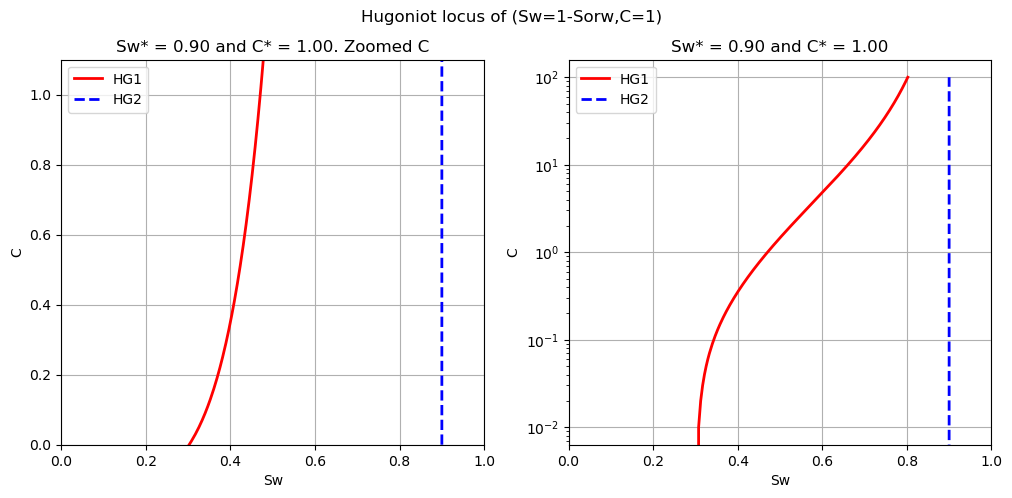

In [17]:
Sst=1.0-ff.Sorw; Cst=1.0
# Introduce eps_S to deal with singularity at Sw=1-Sorw
eps_S = 1e-6

# Solution split in two parts:
# 1) a smooth curve satisfying the Rankine-Hugoniot equation, Sw < 1-Sorw
# 2) the curve Sw=1-Sorw

# First part
Cmax = 1e2
HG_C1 = np.append(np.linspace(0.0,2.0,201), np.logspace(np.log10(2),np.log10(Cmax),1001))
HG_S1 = pd.Series(name='Sw')
for C in HG_C1: 
    S = brentq(lambda Sw: ff.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),ff.Scw,Sst-eps_S)
    HG_S1[C] = S
HG1 = HG_S1.to_frame().reset_index(names='C')

# Second part
HG_C2 = np.append(np.linspace(0.0,2.0,201), np.logspace(np.log10(2),np.log10(Cmax),1001))
HG_S2 = pd.Series(name='Sw')
for C in HG_C2:
    S = brentq(lambda Sw: ff.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),Sst-eps_S,Sst)
    HG_S2[C] = S
HG2 = HG_S2.to_frame().reset_index(names='C')

fig, ax = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Hugoniot locus of (Sw=1-Sorw,C=1)')
HG1.plot(x='Sw',y='C', style='r-', ax=ax[0], label='HG1', lw=2)
HG2.plot(x='Sw',y='C', style='b--', ax=ax[0], label='HG2', lw=2)
ax[0].set_xlim(0.,1.)
ax[0].set_ylim(0.,1.1)
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('C')
ax[0].set_title(f'Sw* = {Sst:4.2F} and C* = {Cst:4.2f}. Zoomed C')
ax[0].grid()

HG1.plot(x='Sw',y='C', style='r-', ax=ax[1], label='HG1', lw=2)
HG2.plot(x='Sw',y='C', style='b--', ax=ax[1], label='HG2', lw=2)
ax[1].set_xlim(0.,1.)
#ax[1].set_ylim(0,1.1)
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('C')
ax[1].set_yscale('log')
ax[1].set_title(f'Sw* = {Sst:4.2F} and C* = {Cst:4.2f}')
ax[1].grid()

# Limit the Hugoniot locus to 0<= C <= 1
HG1 = HG1[(HG1['C']>=0)&(HG1['C']<=1)]
HG2 = HG2[(HG2['C']>=0)&(HG2['C']<=1)]

# Speeds of S- and C-waves starting from (Sw=1-Sorw,C=1)  
Two possible exit routes from (Sw=1-Sorw,C=1):
1) 1-wave: the C=1 integral curve
2) 2-wave: the Sw=1-Sorw integral curve / Hugoniot locus

**Observations:**  
1) From plot (0,0) for the S-wave integral curve: the S-wave speed increases with decreasing Sw: rarefaction solution possible from (Sw=1-Sorw,C=1). Moreover, the speed is zero in (Sw=1-Sorw,C=1) which would make this point stationary
2) From plot (0,1) for the C-wave integral curve: the C-wave speed decreases with decreasing C (this is caused by $\frac{d^2a}{dC^2}<0$): a rarefaction solution is not possible.
3) From plot (1,0) for the 'left' branch of the Hugoniot locus: $\lambda_S(U_R) > \sigma_C$, but $\lambda_S(U_L) < \sigma_C$ : violates the entropy condition, so no admissible shock (see entropy condition above)
4) From plot(1,1) for the 'right' branch of the Hugoniot locus: $\lambda_S(U_R) < \sigma_C$: admissible C-wave shock. However, the C-wave shock speed > 0, whereas the the speed of a follow-up S-wave from (Sw=1-Sorw,C) is zero for any C (for no>1). Therefore, starting with this shock would not result in a valid trajectory

The conclusion is that the solution to the polymer equation will start as a S-wave (C=1) rarefaction from (Sw=1-Sorw,C=1).

We will see later that for no=1 (no = Corey exponent for oil) this no longer holds in all situations.

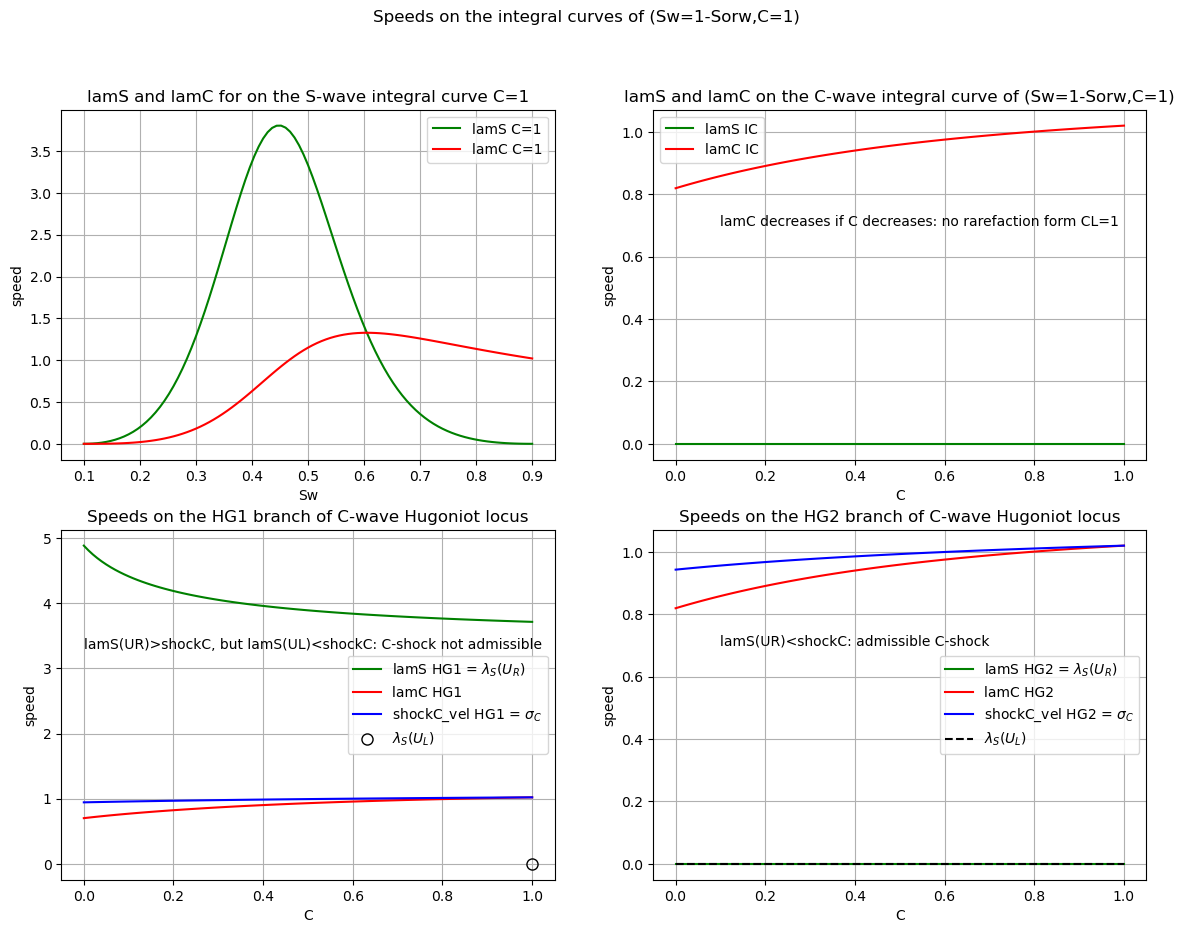

In [18]:
# S-wave integral curve through (Sw=1-Sorw,C=1): constant C=1
Ss = np.linspace(ff.Scw,1.0-ff.Sorw,101)

# C-wave integral curve through (Sw=1-Sorw, C=1): curve Sw = 1-Sorw
IC =  pd.DataFrame(data={'C':np.linspace(0,1,101), 'Sw':1.0-ff.Sorw})

# HG1 & HG2: 2-wave Hugoniot locus of (Sw=1-Sorw,C=1) determined above

fig, ax = plt.subplots(2,2,figsize=(14,10))
fig.suptitle('Speeds on the integral curves of (Sw=1-Sorw,C=1)')
ax[0,0].plot(Ss, ff.lamS(Ss,Cst), 'g-', label='lamS C=1')
ax[0,0].plot(Ss, ff.lamC(Ss,Cst), 'r-', label='lamC C=1')
ax[0,0].set_ylabel('speed')
ax[0,0].set_xlabel('Sw')
ax[0,0].set_title('lamS and lamC for on the S-wave integral curve C=1')
ax[0,0].legend()
ax[0,0].grid()

ax[0,1].plot(IC['C'], ff.lamS(IC['Sw'],IC['C']), 'g-', label='lamS IC')
ax[0,1].plot(IC['C'], ff.lamC(IC['Sw'],IC['C']), 'r-', label='lamC IC')
ax[0,1].text(0.1,0.7, 'lamC decreases if C decreases: no rarefaction form CL=1')
ax[0,1].set_ylabel('speed')
ax[0,1].set_xlabel('C')
ax[0,1].set_title('lamS and lamC on the C-wave integral curve of (Sw=1-Sorw,C=1)')
ax[0,1].legend()
ax[0,1].grid()

ax[1,0].plot(HG1['C'], ff.lamS(HG1['Sw'],HG1['C']), 'g-', label=r'lamS HG1 = $\lambda_S(U_R)$')
ax[1,0].plot(HG1['C'], ff.lamC(HG1['Sw'],HG1['C']), 'r-', label='lamC HG1')
ax[1,0].plot(HG1['C'], ff.shockC_vel(HG1['C'],Swst=1.0-ff.Sorw,Cst=1), 'b-', label=r'shockC_vel HG1 = $\sigma_C$')
ax[1,0].plot(1, ff.lamS(1.0-ff.Sorw,1), 'ko', markersize=8, fillstyle='none', label=r'$\lambda_S(U_L)$')
ax[1,0].text(0.,3.3,'lamS(UR)>shockC, but lamS(UL)<shockC: C-shock not admissible')    
ax[1,0].set_ylabel('speed')
ax[1,0].set_xlabel('C')
ax[1,0].set_title('Speeds on the HG1 branch of C-wave Hugoniot locus')
ax[1,0].legend()
ax[1,0].grid()

ax[1,1].plot(HG2['C'], ff.lamS(HG2['Sw'],HG2['C']), 'g-', label=r'lamS HG2 = $\lambda_S(U_R)$')
ax[1,1].plot(HG2['C'], ff.lamC(HG2['Sw'],HG2['C']), 'r-', label='lamC HG2')
ax[1,1].plot(HG2['C'], ff.shockC_vel(HG2['C'],Swst=1.0-ff.Sorw,Cst=1), 'b-', label=r'shockC_vel HG2 = $\sigma_C$')
ax[1,1].plot(HG2['C'], ff.lamS(1.0-ff.Sorw,HG2['C']), 'k--', label=r'$\lambda_S(U_L)$')
ax[1,1].text(0.1,0.7,'lamS(UR)<shockC: admissible C-shock')
ax[1,1].set_ylabel('speed')
ax[1,1].set_xlabel('C')
ax[1,1].set_title('Speeds on the HG2 branch of C-wave Hugoniot locus')
ax[1,1].legend()
ax[1,1].grid()


# Intersection of S-wave and C-wave speed

To move from the injection condition, (Sw=1-Sorw,C=1), to the initial condition, (Sw=Swi,C=0), the solution will need to switch from the S-wave rarefaction to a C-wave rarefaction or shock. Otherwise, it will not be possible to change the C value.

Looking at the $\lambda_S$ and $\lambda_C$ speeds in the plot above, one sees that for $S_w$ decreasing from $S_w=1-S_{orw}$ we have $\lambda_C > \lambda_S$ until the two curves cross (this is in line with the observation we made earlier for C-wave speeds on its integral curve). For $S_w$ values from $1-S_{orw}$ until the crossing point, it is in principe possible to switch from the S-wave to the C-wave (at the switch the C-wave speed needs to be equal or higher than the S-wave speed).  
Based on material balance one can show that the speeds need to match, so the switch will be at the intersection of  $\lambda_S$ and $\lambda_C$.

We will look at two types of intersections:
1) S-wave rarefaction with C-wave rarefaction, intersection in Sw1_IC. We will see that based on speed considerations this is not an acceptable solution.
2) S-wave rarefaction with C-wave shock (assuming that the shock brings C down from 1 to 0), intersection in Sw1. There are two potential end points for this shock. viz. Sw2 and Sw2_alt. The latter will not be acceptable due to speed considerations

## Determining the intersections

The intersection Sw1_IC can be found by solving the equation:
$$
\lambda_S(S_{w1-IC},C=1) = \lambda_C(S_{w1-IC},C=1)
$$
The intersection Sw1 can be found by solving the equation:
$$
\lambda_S(S_{w1},C=1) = \sigma_C(S_{w1},C=1 -> C=0) = \dfrac{f_w(S_{w1},C=1)}{S_{w1}+a(C=1)}
$$
where we used $a(C=0) = 0$.

In [19]:
# Determine the intersections
# Introduce eps_S to avoid spurious solution Sw=Scw
eps_S = 1e-8
# S-wave rarefaction with C-wave rarefaction
Sw1_IC = brentq(lambda Sw: ff.lamS_eq_lamC(Sw, C=1.0),ff.Scw+eps_S,1.0-ff.Sorw)
# S-wave rarefaction with C-wave shock
Sw1 = brentq(lambda Sw: ff.lamS_shockC(Sw,epsAds=1e-8),ff.Scw+eps_S,1.0-ff.Sorw)
print('The intersection points are close, but not identical')
print(f'Sw1_IC = {Sw1_IC:6.4f}, Sw1 = {Sw1:6.4f}')
# Consistency check with internal calculations
print('\nConsistency check with internal FracFlow calculations:')
print(f'Sw1_IC / ff.Sw1_IC =  {Sw1_IC/ff.Sw1_IC:4.2e}')
print(f'Sw1 / ff.Sw1       =  {Sw1/ff.Sw1:4.2e}')

The intersection points are close, but not identical
Sw1_IC = 0.6050, Sw1 = 0.6142

Consistency check with internal FracFlow calculations:
Sw1_IC / ff.Sw1_IC =  1.00e+00
Sw1 / ff.Sw1       =  1.00e+00


# Determine the C-wave integral curve through (Sw=Sw1_IC, C=1) and the C-wave Hugoniot locus through (Sw=Sw1, C=1)

In this cell also the two potential end points of the C-wave shock will be determined, viz. Sw2 and Sw2_alt. Note that they are solutions of the equations:
$$
\dfrac{f_w(S_{w2})}{S_{w2}+a(C=1)} = \dfrac{f_w(S_{w1})}{S_{w1}+a(C=1)}
$$
resp.
$$
\dfrac{f_w(S_{w2-alt})}{S_{w2-alt}+a(C=1)} = \dfrac{f_w(S_{w1})}{S_{w1}+a(C=1)}
$$


In [20]:
# C-wave integral curve through (Sw=Sw1_IC, C=1)
Sst=Sw1_IC; Cst=1.0
# Keeping away from singularity
eps_S = 1e-8
# Branch: Scw <= Sw <= Sw1_IC
IC_S1 = np.linspace(Sst,ff.Scw,101)
IC_C1 = odeint(ff.dC_dS,Cst,IC_S1)
IC1 = pd.DataFrame(data={'S':IC_S1,'C':IC_C1.T[0]})
IC1 = IC1[IC1['C']>=0]
# Branch: Sw1_IC <= Sw <= 1-Sorw
IC_S2 = np.linspace(Sst,1.0-ff.Sorw-eps_S,101)
IC_C2 = odeint(ff.dC_dS,Cst,IC_S2)
IC2 = pd.DataFrame(data={'S':IC_S2,'C':IC_C2.T[0]})
IC2 = IC2[IC2['C']>=0]

# C-wave Hugoniot locus through (Sw=Sw1, C=1)
Sst=Sw1; Cst=1.0
# Keeping away from singularity
eps_S = 1e-8
# For Sw > Sst, no solution for C=Cst
eps_C = 1e-4

# Solution: C <= Cst & Sw < Sst
HG_C1 = np.linspace(0.0,Cst,101)
HG_S1 = pd.Series(name='S')
for C in HG_C1: 
    S = brentq(lambda Sw: ff.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),ff.Scw,Sst)
    HG_S1[C] = S
HG1 = HG_S1.to_frame().reset_index(names='C')

# Solution: C > Cst & Smin < Sw < Sst
Smin = HG_S1.iloc[-2]
HG_S1 = np.linspace(Smin, Sst-eps_S, 11)
HG_C1 = pd.Series(name='C')
for S in HG_S1:
    C = brentq(lambda C: ff.hugo(Sw=S,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),Cst*0.9,3.0)
    HG_C1[S] = C
HG1_append = HG_C1.to_frame().reset_index(names='S')
HG1 = pd.concat([HG1.iloc[:-1],HG1_append])

# Solution: C < Cst & Sw > Sst
HG_C2 = np.linspace(0.0, Cst, 101)
HG_S2= pd.Series(name='S')
for C in HG_C2: 
    S = brentq(lambda Sw: ff.hugo(Sw,C=C,Sst=Sst,Cst=Cst),Sst,1.0-ff.Sorw)
    HG_S2[C] = S
HG2 = HG_S2.to_frame().reset_index(names='C')

print('Starting point of the shocks:')
print(f'Sw1 = {Sw1:4.2f}, C = 1.00')
# Sw2 = the saturation value at the end of the C-wave shock for C=0; Sw2 lower than Sw1
Sw2 = HG1.iloc[0]['S']
print('End point of the 2-wave shock:')
print(f'Sw2 = {Sw2:4.2f}, C = {HG1.iloc[0]['C']:4.2f}')
# Sw2_alt = the saturation value at the end of the C-wave shock for C=0; Sw2_alt higher then Sw1
Sw2_alt = HG2.iloc[0]['S']
print('Alternative end point of the 2-wave shock')
print(f'Sw2_alt = {Sw2_alt:4.2f}, C = {HG1.iloc[0]['C']:4.2f}')

# Consistency check with internal calculations
print('\nConsistency check with internal FracFlow calculations:')
print(f'Sw2 / ff.Sw2         =  {Sw2/ff.Sw2:4.2e}')
print(f'Sw2_alt / ff.Sw2_alt =  {Sw2_alt/ff.Sw2_alt:4.2e}')

Starting point of the shocks:
Sw1 = 0.61, C = 1.00
End point of the 2-wave shock:
Sw2 = 0.33, C = 0.00
Alternative end point of the 2-wave shock
Sw2_alt = 0.68, C = 0.00

Consistency check with internal FracFlow calculations:
Sw2 / ff.Sw2         =  1.00e+00
Sw2_alt / ff.Sw2_alt =  1.00e+00


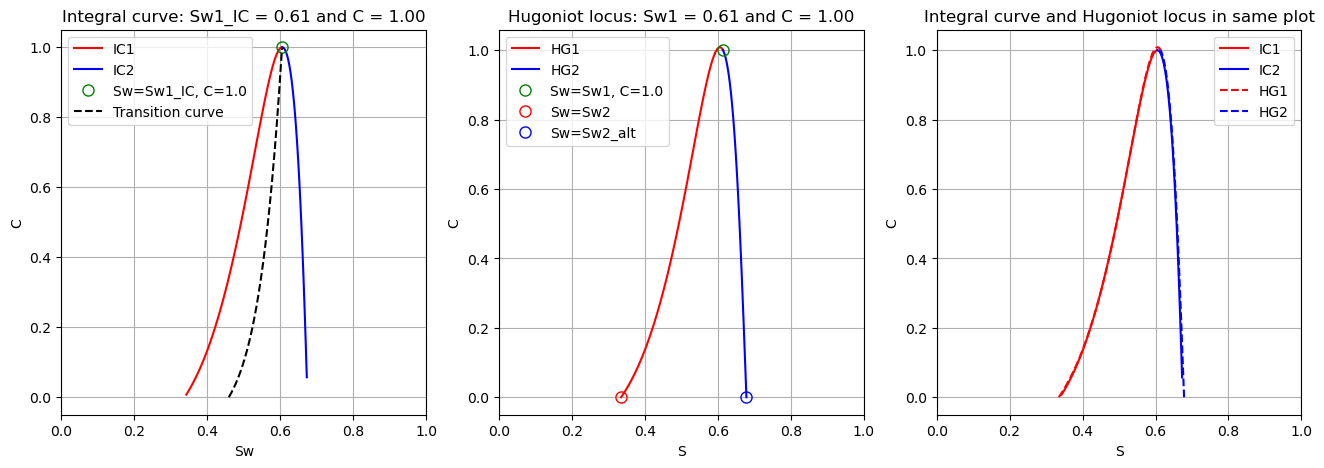

In [21]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
IC1.plot(x='S',y='C', style='r-', ax=ax[0], label='IC1')
IC2.plot(x='S',y='C', style='b-', ax=ax[0], label='IC2')
ax[0].plot(Sw1_IC,1,'go', label='Sw=Sw1_IC, C=1.0', markersize=8, fillstyle='none')
Trans.plot(x='Sw',y='C', style='k--', ax=ax[0], label='Transition curve')
ax[0].set_xlim(0,1)
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('C')
ax[0].legend()
ax[0].set_title(f'Integral curve: Sw1_IC = {Sw1_IC:4.2F} and C = {Cst:4.2f}')
ax[0].grid()

HG1.plot(x='S',y='C', style='r-', ax=ax[1], label='HG1')
HG2.plot(x='S',y='C', style='b-', ax=ax[1], label='HG2')
ax[1].plot(Sw1,1,'go', label='Sw=Sw1, C=1.0', markersize=8, fillstyle='none')

ax[1].plot(Sw2,0, 'ro', label='Sw=Sw2', markersize=8, fillstyle='none')
ax[1].plot(Sw2_alt,0, 'bo', label='Sw=Sw2_alt', markersize=8, fillstyle='none')

ax[1].set_xlim(0.,1.)
ax[1].set_xlabel('S')
ax[1].set_ylabel('C')
ax[1].legend()
ax[1].set_title(f'Hugoniot locus: Sw1 = {Sw1:4.2F} and C = {Cst:4.2f}')
ax[1].grid()

IC1.plot(x='S',y='C', style='r-', ax=ax[2], label='IC1')
IC2.plot(x='S',y='C', style='b-', ax=ax[2], label='IC2')

HG1.plot(x='S',y='C', style='r--', ax=ax[2], label='HG1')
HG2.plot(x='S',y='C', style='b--', ax=ax[2], label='HG2')

ax[2].set_xlim(0,1)
ax[2].set_xlabel('S')
ax[2].set_ylabel('C')
ax[2].set_title('Integral curve and Hugoniot locus in same plot')
ax[2].grid()

# Speeds on the C-wave integral curve and Hugoniot locus

Below the rarefaction speeds are plotted on the integral curve and the shock speeds on the Hugoniot locus.

The C-wave rarefaction speed decreases when moving from C=1 to C=0 on the integral curve for both end points (see green solid and dashed curves in the left plot below). Note that this is in line with the observation for the C-wave speed on its integral curve; Sw1 is on the transition curve.  Therefore, a rarefaction is not a valid solution from the speed ordering perspective.

The C-wave shock speeds are shown in the right plot below. The shock speeds to the two potential end points are indicated by the gray (Sw2) and maroon (Sw2_alt) markers; the link to the UR states are indicacted by green dashed lines. Both shocks fulfill the entropy conditions:
1) For Sw2: $\lambda_S(U_R), \lambda_S(U_L) \geq \sigma_C$
2) For Sw2_alt:  $\lambda_S(U_R) < \sigma_C$

After the C-wave shock the solution will continue via a S-wave rarefaction / shock (we will show below that a C-wave continuation is not possible). Note that for the alternative endpoint, Sw2_alt, the following S-wave speed (the red dashed line) is lower than the C-wave shock speed. Hence, this option is not acceptable.  
For the Sw2 solution, the subsequent S-wave speed (dashed red line) is higher. Therefore, this is the correct solution.

Note that the above discussion holds for the case with a non-zero adsorption, without adsorption the solution is a C-wave **contact discontinuity*. However, this does not impact the overall solution scheme, because by treating the contact discontinuity in the code as a shock, the solution will be correct. It is good to realize though that a contact discontinuity will be less 'stable' in the physical world and in numerical simulation.
The contact discontinuity will be discussed in a later section.

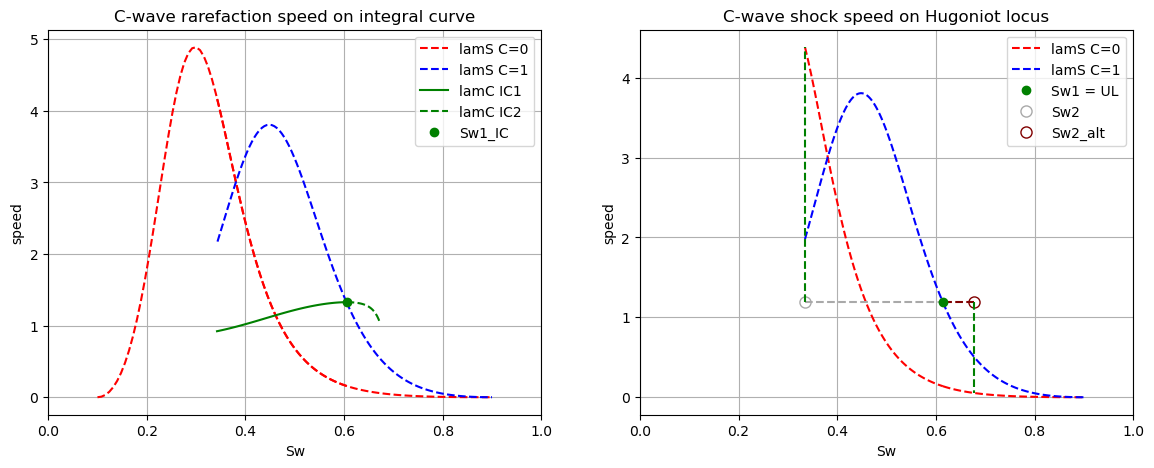

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

# plotting speeds of the C-wave rarefaction
ax[0].plot(IC1['S'],ff.lamS(IC1['S'],0),'r--', label='lamS C=0')
ax[0].plot(Ss,ff.lamS(Ss,0),'r--')
Ss = np.linspace(Sw1_IC,1.0-ff.Sorw,101)
ax[0].plot(IC1['S'],ff.lamS(IC1['S'],1),'b--', label='lamS C=1')
ax[0].plot(Ss,ff.lamS(Ss,1),'b--')

ax[0].plot(IC1['S'],ff.lamC(IC1['S'],IC1['C']),'g-', label='lamC IC1')
ax[0].plot(IC2['S'],ff.lamC(IC2['S'],IC2['C']),'g--', label='lamC IC2')
ax[0].plot(Sw1_IC,ff.lamS(Sw1_IC,1),'go', label='Sw1_IC')
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('speed')
ax[0].set_title('C-wave rarefaction speed on integral curve')
ax[0].set_xlim(0,1)
# ax[0,0].set_ylim(1.4,1.6)
ax[0].legend()
ax[0].grid()

# plotting speeds of the C-wave shock
# Speed jumping to (S=0.16,C=0)
vel_jump = ff.shockC_vel(C=HG1.iloc[0]['C'],Swst=Sw1_IC,Cst=1)
vel_jump_alt = ff.shockC_vel(C=HG2.iloc[0]['C'],Swst=Sw1_IC,Cst=1)

Ss = np.linspace(Sw1,1.0-ff.Sorw,101)
ax[1].plot(HG1['S'],ff.lamS(HG1['S'],0),'r--', label='lamS C=0')
ax[1].plot(Ss,ff.lamS(Ss,0),'r--')
ax[1].plot(HG1['S'],ff.lamS(HG1['S'],1),'b--', label='lamS C=1')
ax[1].plot(Ss,ff.lamS(Ss,1),'b--')

ax[1].plot((HG1.iloc[0]['S'],Sw1),(vel_jump,vel_jump), 'darkgrey', linestyle='dashed')
ax[1].plot((HG2.iloc[0]['S'],Sw1),(vel_jump_alt,vel_jump_alt), 'maroon', linestyle='dashed')
ax[1].plot(Sw1,ff.lamS(Sw1,1),'go', label='Sw1 = UL')
ax[1].plot(Sw2,vel_jump, 'o', markeredgecolor='darkgray', markersize=8, fillstyle='none', label='Sw2')
ax[1].plot(Sw2_alt,vel_jump_alt, 'o', markeredgecolor='maroon', markersize=8, fillstyle='none', label='Sw2_alt')
ax[1].plot((Sw2,Sw2),(vel_jump,ff.lamS(Sw2,0)), 'g--')
ax[1].plot((Sw2_alt,Sw2_alt),(vel_jump_alt,ff.lamS(Sw2_alt,0)), 'g--')
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('speed')
ax[1].set_title('C-wave shock speed on Hugoniot locus')
ax[1].set_xlim(0,1)
# ax[1].set_ylim(1.4,1.6)
ax[1].legend()
ax[1].grid()

# Solution up to this point:
1) From (Sw=1-Sorw,C=1) to (Sw=Sw1,C=1): S-wave rarefaction  
2) From (Sw=Sw1,C=1) to (Sw=Sw2,C=0): C-wave shock

This corresponds to the traditional tangent solution in the literature. Note that the alternative solution Sw2_alt lies at the 'opposite' side of Sw1 compared to Sw2 and is not part of the 'traditional' solution.


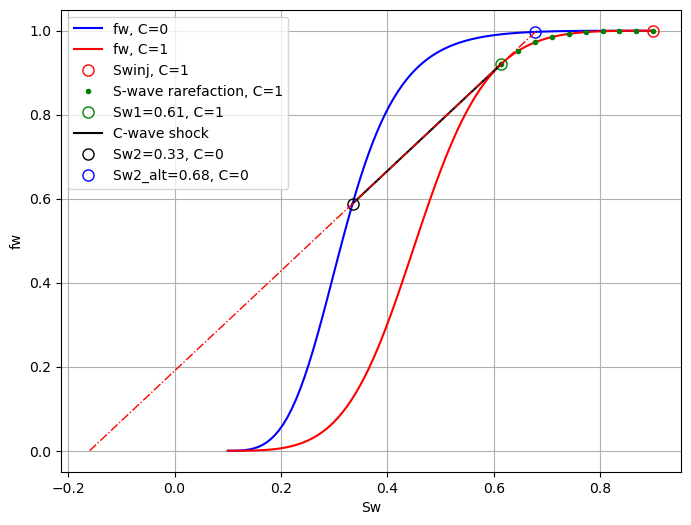

In [23]:
Ss = np.linspace(0,1,101)
fig, ax = plt.subplots(figsize=(8,6))
Swinj = 1.0-ff.Sorw; Cinj=1.0

#
Ss = np.linspace(ff.Scw,1.0-ff.Sorw,101)
ax.plot(Ss,ff.fw(Ss,0), 'b-', label = 'fw, C=0')
ax.plot(Ss,ff.fw(Ss,1), 'r-', label = 'fw, C=1')

ax.plot(Swinj,ff.fw(Swinj,Cinj),'ro', label = 'Swinj, C=1', markersize=8,fillstyle='none')
Ss = np.linspace(Swinj,Sw1,10)
ax.plot(Ss,ff.fw(Ss,Cinj),'g.', label='S-wave rarefaction, C=1')
ax.plot(Sw1,ff.fw(Sw1,Cinj),'go', label = f'Sw1={Sw1:4.2f}, C=1', markersize=8,fillstyle='none')

Ci=0.0
ax.plot((Sw1,Sw2),(ff.fw(Sw1,Cinj),ff.fw(Sw2,Ci)),'k-', label = 'C-wave shock')
ax.plot(Sw2,ff.fw(Sw2,Ci),'ko', label = f'Sw2={Sw2:4.2f}, C=0', markersize=8,fillstyle='none')
ax.plot(Sw2_alt,ff.fw(Sw2_alt,Ci),'bo', label = f'Sw2_alt={Sw2_alt:4.2f}, C=0', markersize=8,fillstyle='none')

ax.set_xlabel('Sw')
ax.set_ylabel('fw')
ax.grid()
ax.legend()

D=ff.ad(1)-ff.ad(0)
ax.plot((-D,Sw2,Sw1,Sw2_alt),(0,ff.fw(Sw2,0),ff.fw(Sw1,1),ff.fw(Sw2_alt,0)),'r-.', lw=1)

## Determine the C-wave integral curve through the end-point of the previous C-wave shock

There is no C-wave connecting the end-point of the previous 2-wave shock to (Sw=Swi,C=0), but the C=0 S-wave will do this.  
So, the next step is a S-wave to (Sw=Swi, C=0)

In [24]:
# 2- wave integral curve through (Sw=Sw2, C=1)
Sst=Sw2; Cst=0.0
# Avoiding singularity at Sw=1-Sorw
eps_S = 1e-8

IC_S1 = np.linspace(Sst,ff.Scw,101)
IC_C1 = odeint(ff.dC_dS,Cst,IC_S1)
IC1_C0 = pd.DataFrame(data={'S':IC_S1,'C':IC_C1.T[0]})
#IC1_C0 = IC1_C0[IC1_C0['C']>=0]

IC_S2 = np.linspace(Sst,1.0-ff.Sorw-eps_S,101)
IC_C2 = odeint(ff.dC_dS,Cst,IC_S2)
IC2_C0 = pd.DataFrame(data={'S':IC_S2,'C':IC_C2.T[0]})
#IC2_C0 = IC2_C0[IC2_C0['C']>=0]


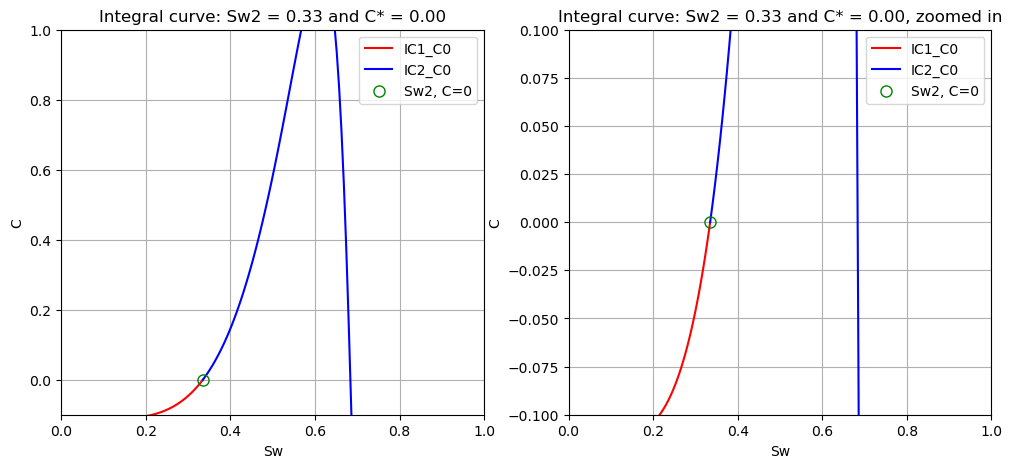

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
IC1_C0.plot(x='S',y='C', style='r-', ax=ax[0], label='IC1_C0')
IC2_C0.plot(x='S',y='C', style='b-', ax=ax[0], label='IC2_C0')
ax[0].plot(Sw2,0,'go', label='Sw2, C=0', markersize=8, fillstyle='none')

ax[0].set_xlim(0,1)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('C')
ax[0].set_title(f'Integral curve: Sw2 = {Sw2:4.2F} and C* = {Cst:4.2f}')
ax[0].legend()
ax[0].grid()


IC1_C0.plot(x='S',y='C', style='r-', ax=ax[1], label='IC1_C0')
IC2_C0.plot(x='S',y='C', style='b-', ax=ax[1], label='IC2_C0')
ax[1].plot(Sw2,0,'go', label='Sw2, C=0', markersize=8, fillstyle='none')

ax[1].set_xlim(0,1)
ax[1].set_ylim(-0.1,0.1)
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('C')
ax[1].set_title(f'Integral curve: Sw2 = {Sw2:4.2F} and C* = {Cst:4.2f}, zoomed in')
ax[1].legend()
ax[1].grid()


# S-wave solution between (Sw=Sw2, C=0) and (Sw=Swi,C=0)

Code to determine the S-wave solution between (Sw=Sw2, C=0) and (S=Swi,C=0): same as Buckley Leverett solution

For Swi < Sw2_alt the following solutions are possible depending on the value of Swi:
1) S-wave shock
2) S wave rarefaction
3) S-wave rarefaction + S-wave shock: intermediate point with Sw = Sw3. At Sw=Sw3 the rarefaction ends and the shock starts.

The method **ff.events_1wave** selects the correct scenario and calculates Sw3, if required. This is based on the tangent approach like in the Buckley Leverett solution.

Note that for Swi > Sw2_alt the solution determined up to now breaks down. This is discussed in a later section.

In [26]:
# Number of Swi scenarios to illustrate solutions
# Swi = 0.10   # Shock
Swi = 0.25   # rarefaction + shock
# Swi = 0.30   # rarefaction
# Swi = Sw2    # C-wave shock ends in Swi, no continuation via S-wave (C=0) required
# Swi = 0.40   # shock
# Swi = Sw2_alt*0.98 # shock
# Swi = Sw2_alt*1.04 # Does not give a valid solution: C-wave shock speed > S-wave shock speed. This case does not pass the consistency check

Sw3, events = ff.events_Swave(Sw2,Swi,eps_Sw3=1e-8,epsSvel=1e-8)
# Set the correct Swi in ff
ff.set_Swi(Swi)
print('The S-wave solution is: ', events)

# Consistency check with internal calculations
print('\nConsistency check with internal FracFlow calculations:')
print(f'Sw3 / ff.Sw3 =  {Sw3/ff.Sw3:4.2e}')

The S-wave solution is:  rare + shock

Consistency check with internal FracFlow calculations:
Sw3 / ff.Sw3 =  1.00e+00


# Full solution

Plot the full solution for Swi <= Sw2_alt:
1) Start with S-wave rarefaction wave (C=1) from (Sw=1-Sorw,C=1). Rarefaction wave ends in (Sw=Sw1,C=1)
2) C-wave shock from (Sw=Sw1,C=1) to (Sw=S2,C=0)
3) Depending on value of Swi:
    1) S-wave shock (C=0) from (Sw=Sw2,C=0) to (Sw=Swi,C=0)
    2) S-wave rarefaction (C=0): back @ (Sw=Sw2,C=0) and front @ (Sw=Swi,C=0)
    3) S-wave rarefaction (C=0) followed by S-wave shock (C=0). The transition is at (Sw=Sw3,C=0)

Sw1 = 0.61, Sw2 = 0.33
lamS(Sw=Sw1,C=1) = C-wave shock speed = 1.19
S-wave rarefaction speed, back = 4.38
S-wave shock speed = 4.64


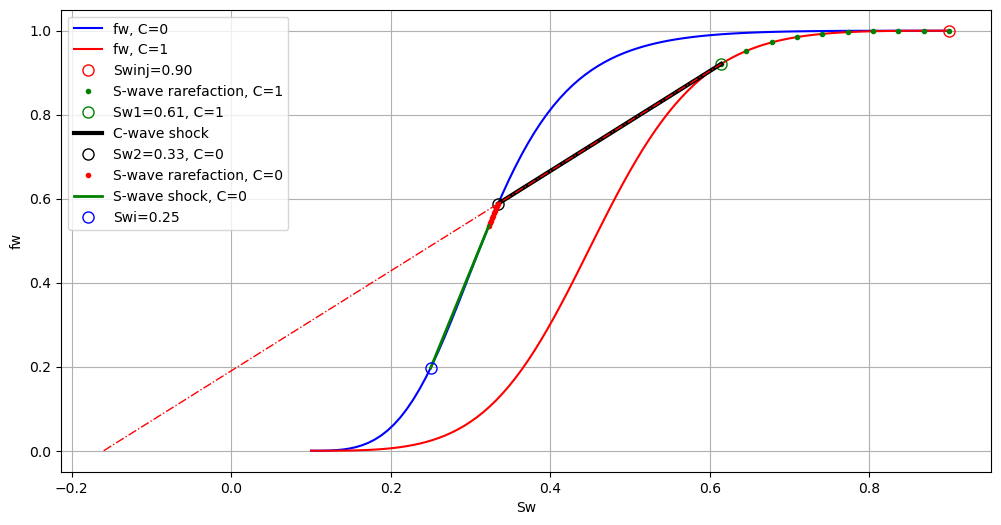

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
Swinj = 1.0-ff.Sorw; Cinj=1.0
Ss = np.linspace(ff.Scw,Swinj,101)
ax.plot(Ss,ff.fw(Ss,0), 'b-', label = 'fw, C=0')
ax.plot(Ss,ff.fw(Ss,1), 'r-', label = 'fw, C=1')

ax.plot(Swinj,ff.fw(Swinj,Cinj),'ro', label = f'Swinj={Swinj:4.2f}', markersize=8,fillstyle='none')
Ss = np.linspace(Swinj,Sw1,10)
ax.plot(Ss,ff.fw(Ss,Cinj),'g.', label='S-wave rarefaction, C=1')
ax.plot(Sw1,ff.fw(Sw1,Cinj),'go', label = f'Sw1={Sw1:4.2f}, C=1', markersize=8,fillstyle='none')
print(f'Sw1 = {Sw1:4.2f}, Sw2 = {Sw2:4.2f}')
print(f'lamS(Sw=Sw1,C=1) = C-wave shock speed = {ff.lamS(Sw=Sw1,C=Cinj):4.2f}')

Ci=0.0
ax.plot((Sw1,Sw2),(ff.fw(Sw1,Cinj),ff.fw(Sw2,Ci)),'k-', label = 'C-wave shock', lw=3)
ax.plot(Sw2,ff.fw(Sw2,Ci),'ko', label = f'Sw2={Sw2:4.2f}, C=0', markersize=8,fillstyle='none')

if events == 'rare':
    Ss = np.linspace(Sw2,Swi,10)
    ax.plot(Ss,ff.fw(Ss,Ci),'r.', label = 'S-wave rarefaction, C=0')
    print(f'S-wave rarefaction speed, back = {ff.lamS(Sw2,C=0):4.2f}')
    print(f'S-wave rarefaction speed, front = {ff.lamS(Swi,C=0):4.2f}')
elif events == 'shock':
    ax.plot((Sw2,Swi),(ff.fw(Sw2,0),ff.fw(Swi,0)),'g-', label = 'S-wave shock, C=0', lw=2)
    print(f'1-wave shock speed = {ff.shockS_vel(Sw2,Swi,Cst=0):4.2f}')
else:
    Ss = np.linspace(Sw2,Sw3,10)
    ax.plot(Ss,ff.fw(Ss,0),'r.', label = 'S-wave rarefaction, C=0')
    ax.plot((Sw3,Swi),(ff.fw(Sw3,0),ff.fw(Swi,0)),'g-', label = 'S-wave shock, C=0', lw=2)
    print(f'S-wave rarefaction speed, back = {ff.lamS(Sw2,C=0):4.2f}')
    print(f'S-wave shock speed = {ff.shockS_vel(Sw3,Swi,Cst=0):4.2f}')

ax.plot(Swi,ff.fw(Swi,0),'bo', label=f'Swi={Swi:4.2f}', markersize=8, fillstyle='none')

ax.set_xlabel('Sw')
ax.set_ylabel('fw')
ax.grid()
ax.legend()

D=ff.ad(1)-ff.ad(0)
ax.plot((-D,Sw2,Sw1),(0,ff.fw(Sw2,0),ff.fw(Sw1,1)),'r-.', lw=1)

# Wave profiles

Plot the water saturation and normalized polymer concentration profiles using the functions **calc_Sol** and **calc_SolC**. The function **calc_Sol** uses the method **ff.rare_1wave** to determnine the rarefaction solution (which is based on inverting the S-wave speed function).

Note that the polymer shock from C=1 to C=0 occurs at the C-wave shock from (Sw=Sw1,C=1) to (Sw=Sw2,C=0).

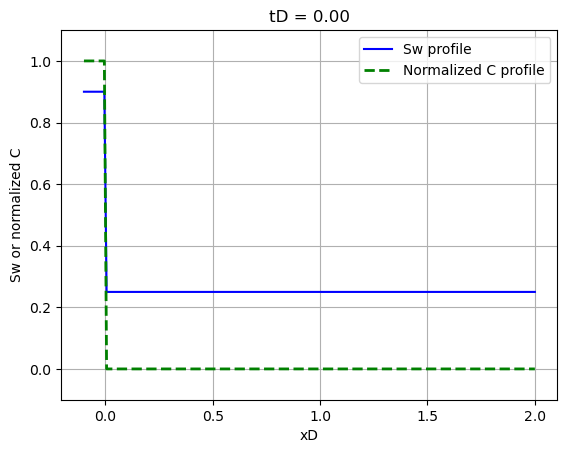

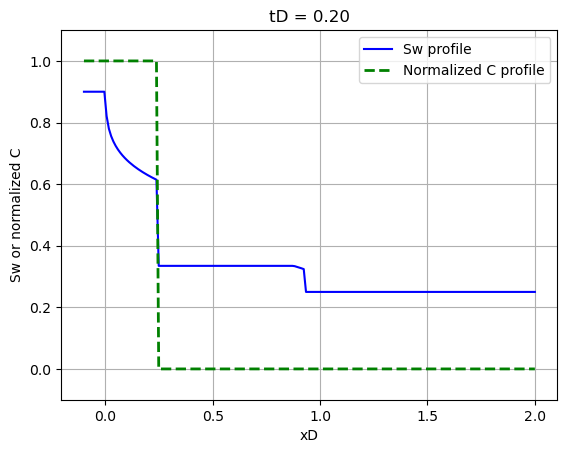

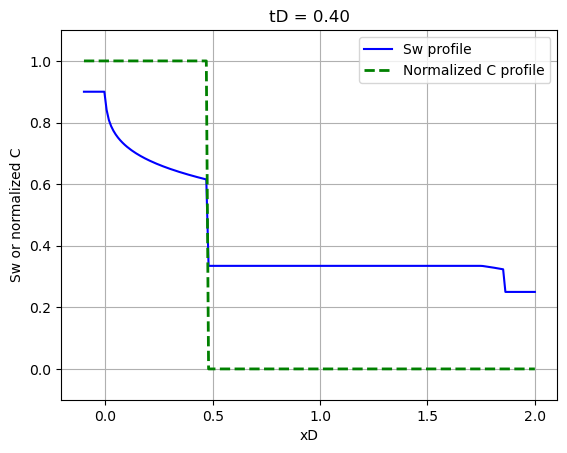

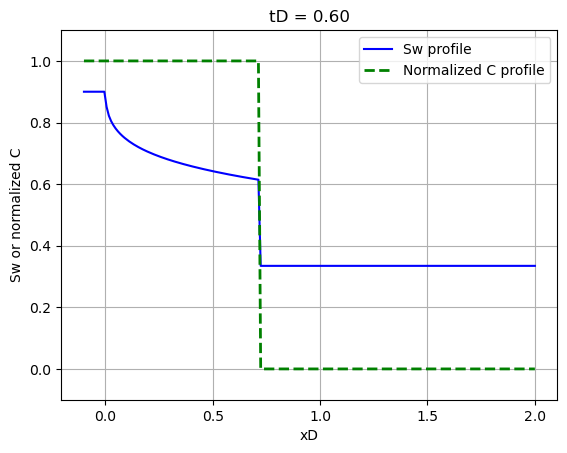

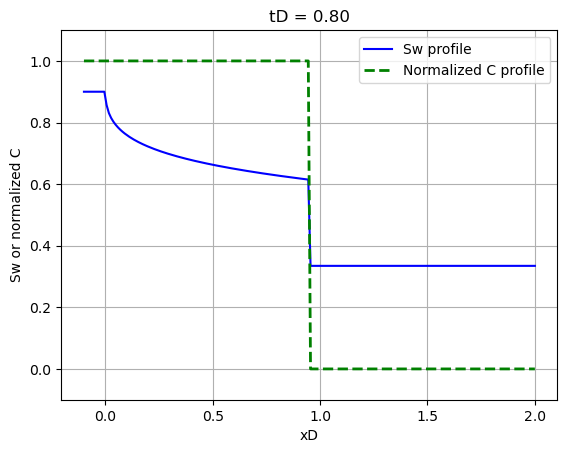

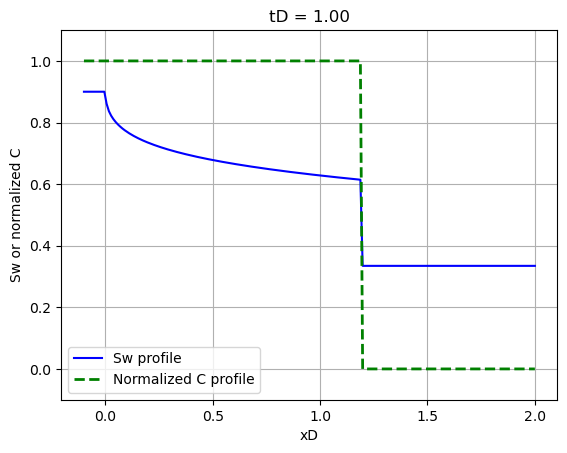

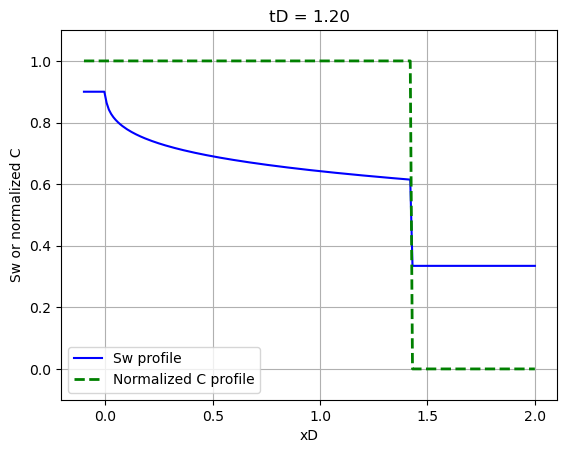

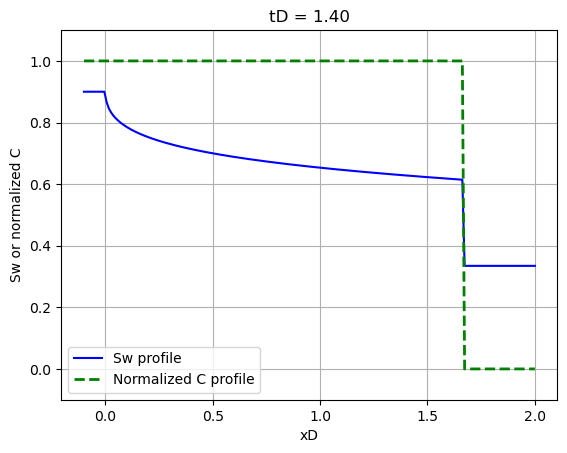

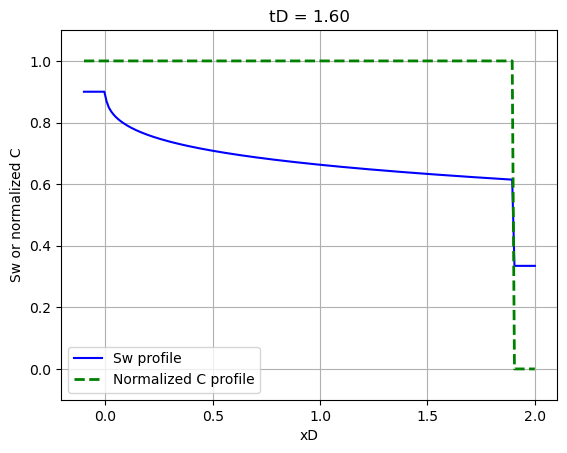

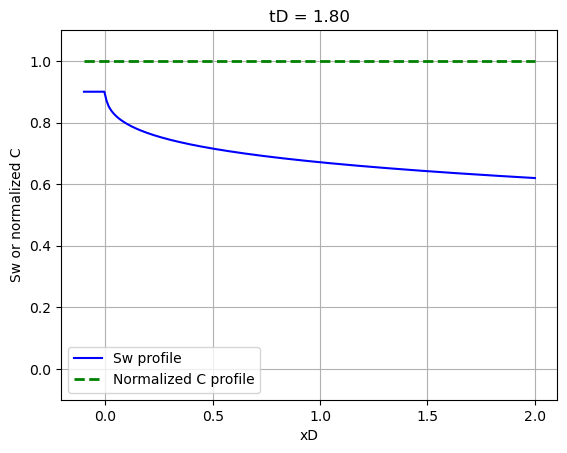

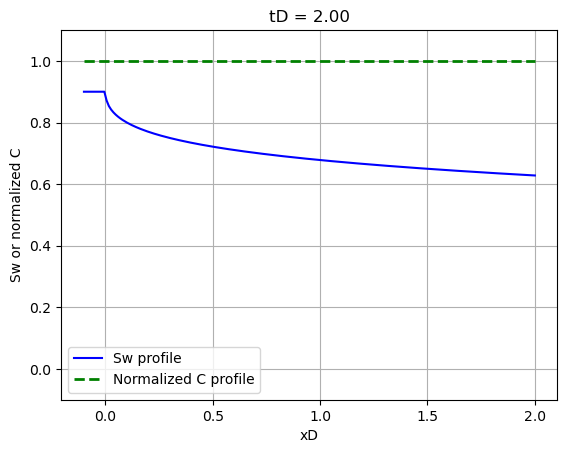

In [28]:
ts = np.linspace(0,2,11)
xs = np.linspace(-0.1,2,200)
# xs = np.linspace(3400,3600,100)

for t in ts:
    data = pd.Series()
    dataC = pd.Series()
    for x in xs:
        data[x] = ff.calc_Sol(x,t)
        dataC[x] = ff.calc_SolC(x,t)
    plt.plot(data, 'b-', label='Sw profile')
    plt.plot(dataC, 'g--', label='Normalized C profile', lw=2)
    plt.ylim(-0.1,1.1)
    # plt.xlim(0.34,0.36)
    plt.xlabel('xD')
    plt.ylabel('Sw or normalized C')
    plt.title(f'tD = {t:4.2f}')
    plt.legend()
    plt.grid()
    plt.show()

# Average water saturation calculations

The average water saturation in the interval $0 \leq x_D \leq 1$ is calculated in three different ways:
1) Integration of the water saturation profile using the SciPy function **quad**
2) Brute force integration over the net injection volume into the interval $0 \leq x_D \leq 1$
3) Analytical solution 

## Average water saturation: integration using **quad**

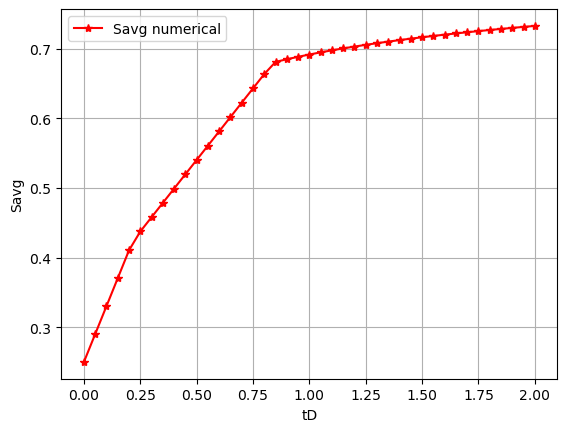

In [29]:
# Tolerance value for the integration function quad
quad_eps = 1e-4

ts = np.linspace(0.0,2,41)
Savg = pd.Series()
for t in ts:
    # the method calc_quad_points identifies the discontinuities in the water saturation profile as
    # input for the integration function quad
    points = ff.calc_quad_points(t)
    # Average water saturation via numerical integration 
    Savg[t] = quad(ff.calc_Sol,0,1,args=(t,), points=points,epsrel=quad_eps, epsabs=quad_eps)[0]

plt.plot(ts,Savg, 'r*-', label = 'Savg numerical')
#plt.ylim(0,1)
plt.ylabel('Savg')
plt.xlabel('tD')
plt.legend()
plt.grid()

## Average water saturation: brute force integration over the net injection volume

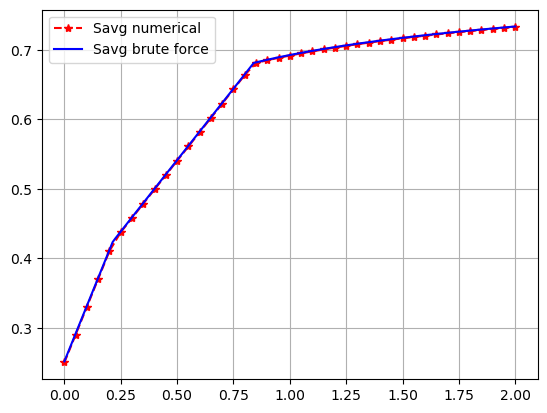

In [30]:
# Set time interval and timesteps for integration
ts, DelT = np.linspace(0.0,2.0,1001, retstep=True)
# NetIn = net injection volume during timestep
NetIn = pd.Series()
for t in ts:
    NetIn[t] = (1.0 - ff.fw(ff.calc_Sol(1.0,t),ff.calc_SolC(1.0,t)))*DelT

plt.plot(Savg, 'r*--', label = 'Savg numerical')
# the method cumsum performs the integration over the time interval
plt.plot(ff.Swi+NetIn.cumsum(), 'b-', label='Savg brute force')
plt.legend()
plt.grid()

## Average water saturation: analytical solution

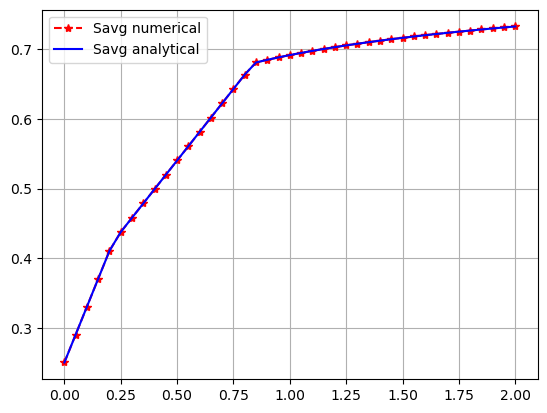

In [31]:
ts = np.linspace(0.0,2,41)
Savg2 = pd.Series()
for t in ts:
    Savg2[t] = ff.calc_Savg(t)

plt.plot(Savg, 'r*--', label = 'Savg numerical')
plt.plot(Savg2, 'b-', label = 'Savg analytical')
plt.grid()
plt.legend()

# Issue for Swi > Sw2_alt

For Swi larger than Sw2_alt the solution described up to now is not correct. The problem is that the last S-wave (C=0) shock is slower than the preceding C-wave shock. Therefore, another solution needs to be constructed.

Below we will show that in this case the solution consists of:
1) an S-wave (C=1) rarefaction from (Sw=1-Sorw,C=1) to (Sw=Sw1_hi,C=1)
2) a C-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Swi,C=0)

The construction is as follows:
1) Determine the integral curve through (Sw=Swi,C=0)
2) Show that a C-wave rarefaction cannot connect a C=1 state to (Sw=Swi,C=0)
3) Determine the Hugoniot locus through (Sw=Swi,C=0)
4) Show that of the two possible C=1 states that could connect to (Sw=Swi,C=0), only one leads to a valid solution (based on speed considerations).

Note that contrary to the "Swi < Sw2_alt" solution, the C-wave shock speed does not match the front speed of the S-wave.

## Determine integral curve through (Sw=Swi_hi,C=0)

Below the integral curve through (Sw=Swi_hi,C=0) is determined. There are two C=1 positions in the state space that connect via the integral curve to (Sw=Swi_hi,C=0), one left and one right of the transition curve.  
As rarefactions cannot cross the transition curve due to speed restrictions, the left side option cannot connect to 
(Sw=Swi_hi,C=0) via a rarefaction.  
Also the right side option, cannot connect via a rarefaction to (Sw=Swi_hi,C=0) as the rarefaction speed decreases from C=1 to C=0 (on the right side of the transition curve the speed decreases with Sw).  
See also earlier discussion of the C-wave rarefaction speeds and their dependence on the position wrt the transition curve.

In [32]:
# Select initial water saturation Swi_hi > Sw2_alt
Swi_hi = Sw2_alt + 0.1*(1.0-ff.Sorw - Sw2_alt )
# Create a separate FracFlow model with the same parameters as the original one
ff_hi = pu.FracFlow(params_dict = params)
# Set the initial water saturation to Swi_hi
ff_hi.set_Swi(Swi_hi)

Sst=Swi_hi; Cst=0.0

# C-wave integral curve through (Sw=Swi_hi,C=0)
# To avoid singularity
eps_S = 1e-8
IC_S1 = np.linspace(Sst,ff_hi.Scw,101)
IC_C1 = odeint(ff_hi.dC_dS,Cst,IC_S1)
IC1 = pd.DataFrame(data={'Sw':IC_S1,'C':IC_C1.T[0]})
IC1 = IC1[IC1['C']>=-0.1]

IC_S2 = np.linspace(Sst,1.0-ff_hi.Sorw-eps_S,101)
IC_C2 = odeint(ff_hi.dC_dS,Cst,IC_S2)
IC2 = pd.DataFrame(data={'Sw':IC_S2,'C':IC_C2.T[0]})
IC2 = IC2[IC2['C']>=-10]

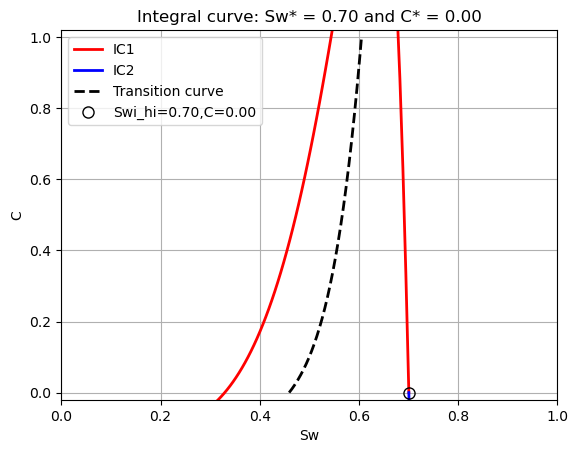

In [33]:
fig, ax = plt.subplots()

IC1.plot(x='Sw',y='C', style='r-', ax=ax, label='IC1', lw=2)
IC2.plot(x='Sw',y='C', style='b-', ax=ax, label='IC2', lw=2)
Trans.plot(x='Sw',y='C', style='k--', ax=ax, label='Transition curve', lw=2)
ax.plot(Swi_hi,0.0, 'ko', label=f'Swi_hi={Swi_hi:4.2f},C=0.00', markersize=8, fillstyle='none')
ax.set_xlim(0,1)
ax.set_ylim(-0.02,1.02)
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_title(f'Integral curve: Sw* = {Sst:4.2F} and C* = {Cst:4.2f}')
ax.legend()
ax.grid()

## Determine the Hugoniot locus through (Sw=Swi_hi,C=0)

Below the Hugoniot locus through (Sw=Swi_hi,C=0) is determined.  
There are two C=1 positions on the Hugoniot locus, Sw1_hi (right branch) and Sw1_hi_alt (left branch). Note that sw1_hi can be determined by solving the equation:
$$
\dfrac{f_w(S_{w1-hi})}{S_{w1-hi}+a(C=1)} = \dfrac{f_w(S_{wi})}{S_{wi}+a(C=1)}
$$


Text(0, 0.5, 'C')

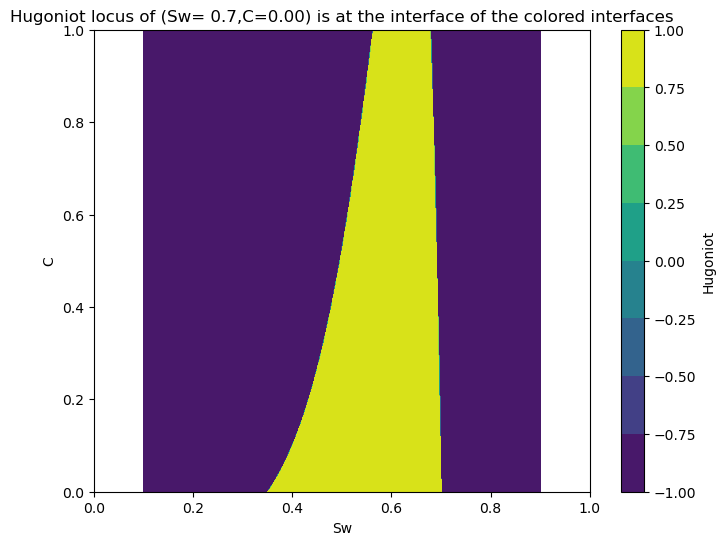

In [34]:
Sw = np.linspace(ff.Scw,1.0-ff.Sorw, 501)
C  = np.linspace(0,1,501)
Sx, Cy = np.meshgrid(Sw, C)
hugo_plot = Step(ff.hugo(Sx,Cy,Sst,Cst,epsAds=1e-8))

plt.figure(figsize=(8,6))
plt.contourf(Sx, Cy, hugo_plot, cmap='viridis')
plt.colorbar(label = 'Hugoniot')
plt.title(f'Hugoniot locus of (Sw={Sst:4.2},C={Cst:4.2f}) is at the interface of the colored interfaces')
plt.xlim(0,1)
plt.xlabel('Sw')
plt.ylabel('C')

In [35]:
# S-wave Hugoniot locus through (Sw=Swi_hi,C=0)

# Eyeball Sw_mid from the plot above to divide the Hugoniot locus into two branches
Sw_mid = 0.6

HG_C = np.linspace(0.0, 1.0, 101)
HG_S1 = pd.Series(name='Sw')
HG_S2 = pd.Series(name='Sw')

for C in HG_C:
    # left branch
    S = brentq(lambda Sw: ff_hi.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8), ff_hi.Scw, Sw_mid, xtol=1e-15)
    HG_S1[C] = S
    # right branch
    S = brentq(lambda Sw: ff_hi.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8), Sw_mid, 1.0-ff_hi.Sorw,xtol=1e-15)
    HG_S2[C] = S

HG1 = HG_S1.to_frame().reset_index(names='C')
HG2 = HG_S2.to_frame().reset_index(names='C')

# Two potential solutions for C=1, one on each branch
Sw1_hi = HG2['Sw'].iloc[-1]
Sw1_hi_alt = HG1['Sw'].iloc[-1]
vshock_hi = ff.shockC_vel(C=0,Swst=Sw1_hi, Cst=1)
vshock_hi_alt = ff.shockC_vel(C=0,Swst=Sw1_hi_alt, Cst=1)
print('Sw1_hi leads to the valid shock solution:')
print(f'Front S-wave rarefaction: Sw1_hi = {Sw1_hi:.4f}')
print(f'Speed front S-wave rarefaction: {ff_hi.lamS(Sw1_hi,C=1):.4f}')
print(f'C-wave shock: (Sw1_hi={Sw1_hi:.4f},C=1.00) --> (Swi_hi={Swi_hi:.4f},C=0.00)')
print(f'C-wave shock velocity: {vshock_hi:.4f}')
print('C-wave shock velocity is larger than the speed of the front of the S-wave rarefaction')
print('\n')
print('Sw1_hi_alt does not lead to a valid solution path:')
print(f'Front S-wave rarefaction: Sw1_hi_alt = {Sw1_hi_alt:.4f}')
print(f'Speed front S-wave rarefaction: {ff_hi.lamS(Sw1_hi_alt,C=1):.4f}')
print(f'C-wave shock: (Sw1_hi_alt={Sw1_hi_alt:.4f},C=1.00) --> (Swi_hi={Swi_hi:.4f},C=0.00)')
print(f'C-wave shock velocity: {vshock_hi_alt:.4f}')
print('C-wave shock velocity is samller than the speed of the front of the S-wave rarefaction')

# Consistency check with internal calculations
print('\nConsistency check with internal FracFlow calculations:')
print(f'Sw1_hi / ff_hi.Sw1_hi =  {Sw1_hi/ff_hi.Sw1_hi:4.2e}')

Sw1_hi leads to the valid shock solution:
Front S-wave rarefaction: Sw1_hi = 0.6785
Speed front S-wave rarefaction: 0.4971
C-wave shock: (Sw1_hi=0.6785,C=1.00) --> (Swi_hi=0.7005,C=0.00)
C-wave shock velocity: 1.1600
C-wave shock velocity is larger than the speed of the front of the S-wave rarefaction


Sw1_hi_alt does not lead to a valid solution path:
Front S-wave rarefaction: Sw1_hi_alt = 0.5634
Speed front S-wave rarefaction: 2.0771
C-wave shock: (Sw1_hi_alt=0.5634,C=1.00) --> (Swi_hi=0.7005,C=0.00)
C-wave shock velocity: 1.1600
C-wave shock velocity is samller than the speed of the front of the S-wave rarefaction

Consistency check with internal FracFlow calculations:
Sw1_hi / ff_hi.Sw1_hi =  1.00e+00


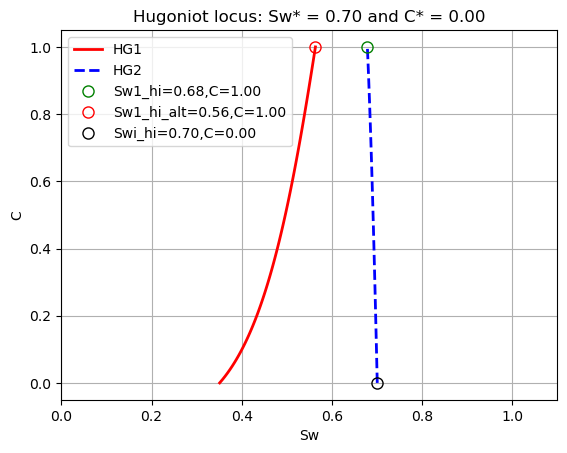

In [36]:
fig, ax = plt.subplots()

HG1.plot(x='Sw',y='C', style='r-', ax=ax, label='HG1', lw=2)
HG2.plot(x='Sw',y='C', style='b--', ax=ax, label='HG2', lw=2)
ax.plot(Sw1_hi,1.0, 'go', label=f'Sw1_hi={Sw1_hi:4.2f},C=1.00', markersize=8, fillstyle='none')
ax.plot(Sw1_hi_alt,1.0, 'ro', label=f'Sw1_hi_alt={Sw1_hi_alt:4.2f},C=1.00', markersize=8, fillstyle='none')
ax.plot(Swi_hi,0.0, 'ko', label=f'Swi_hi={Swi_hi:4.2f},C=0.00', markersize=8, fillstyle='none')
ax.set_xlim(0,1.1)
#ax.set_ylim(0,1.1)
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_title(f'Hugoniot locus: Sw* = {Sst:4.2F} and C* = {Cst:4.2f}')
ax.legend()
ax.grid()


## Analysis of the potential shock solutions

Below a speed plot is made for the two starting points of a C-wave shock to (Sw=Swi_hi,C=0), Sw1_hi and Sw1_hi_alt.

Both shocks fulfill the entropy conditions, in particular, $\lambda_S(U_R) < \sigma_C$ with $U_R$ = (Sw=Swi_hi,C=0).

However, one can see that for Sw1_hi_alt the front of the preceding S-wave rarefaction is faster than the C-wave shock, which makes this option invalid.

For Sw1_hi, the front  of the preceding S-wave rarefaction is slower than the C-wave shock and is hence the correct solution.

Note that for Swi > Sw2_alt, the C-wave shock speed does not match the frontal speed of the S-wave rarefaction, contrary to the Swi < Sw2_alt cases.

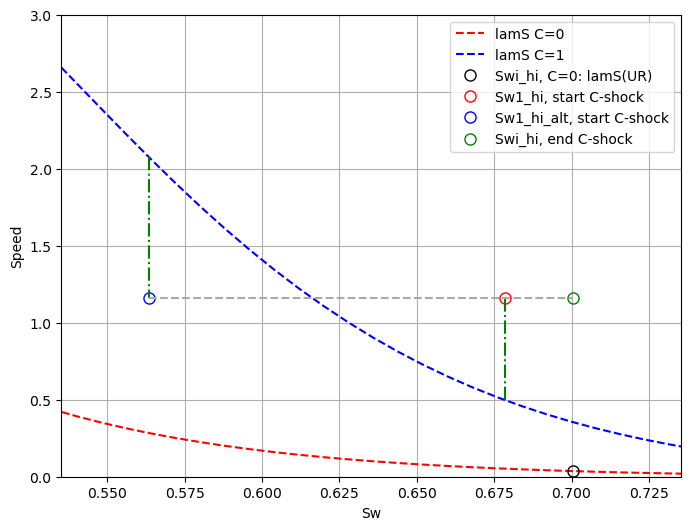

In [37]:
plt.figure(figsize=(8,6))
Ss = np.linspace(ff.Scw,1.0-ff_hi.Sorw, 101)
plt.plot(Ss, ff_hi.lamS(Ss,0), 'r--', label='lamS C=0')
plt.plot(Ss, ff_hi.lamS(Ss,1), 'b--', label='lamS C=1')

plt.plot(Swi_hi,ff_hi.lamS(Swi_hi,0),'ko', label='Swi_hi, C=0: lamS(UR)', markersize=8, fillstyle='none')
plt.plot(Sw1_hi,vshock_hi,'ro', label='Sw1_hi, start C-shock', markersize=8, fillstyle='none' )
plt.plot(Sw1_hi_alt,vshock_hi_alt,'bo', label='Sw1_hi_alt, start C-shock', markersize=8, fillstyle='none' )
plt.plot(Swi_hi,vshock_hi,'go', label='Swi_hi, end C-shock', markersize=8, fillstyle='none' )

plt.plot((Sw1_hi,Sw1_hi),(ff_hi.lamS(Sw1_hi,1),vshock_hi), 'g-.')
plt.plot((Sw1_hi_alt,Sw1_hi_alt),(ff_hi.lamS(Sw1_hi_alt,1),vshock_hi), 'g-.')
plt.plot((Sw1_hi_alt,Swi_hi),(vshock_hi_alt,vshock_hi), 'darkgrey', linestyle='dashed')  
plt.xlabel('Sw')
plt.ylabel('Speed')
plt.xlim(Sw1_hi_alt*0.95,Swi_hi*1.05)
plt.ylim(0,3)
plt.legend()
plt.grid()

# Solution for Swi > Sw2_alt

Plot full solution for Swi > Sw2_alt:
1) S-wave rarefaction (C=1): back @ (Sw=1-Sorw,C=1) and front @ (Sw=Sw1_hi,C=1)
2) C-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Swi,C=0)

The right plot is a zoomed out version of the total solution.  
Note that also the invalid shock position, Sw1_hi_alt, is included in the left plot

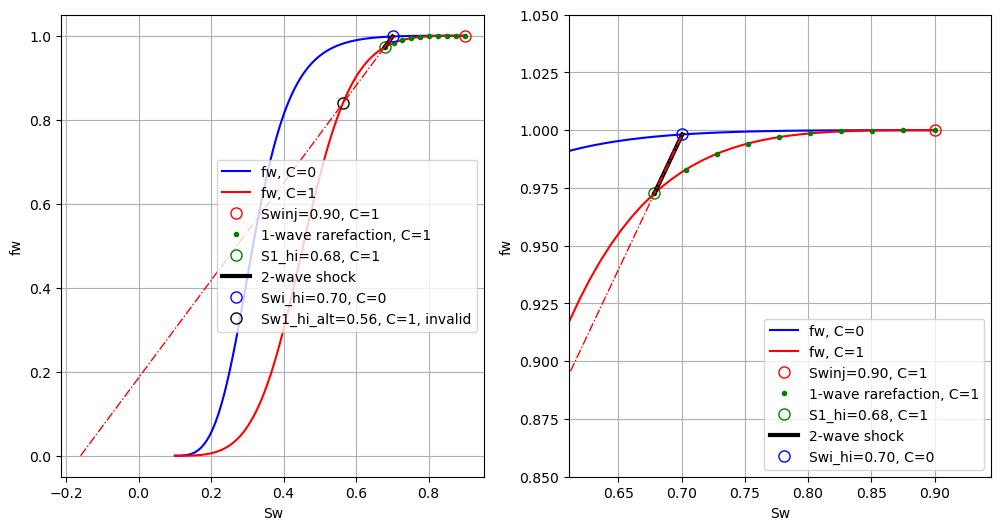

In [38]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
Swinj = 1.0-ff_hi.Sorw; Cinj=1.0
Ci = 0.0
D = ff_hi.ad(1)-ff_hi.ad(0)

Ss = np.linspace(ff_hi.Scw,1.0-ff_hi.Sorw,101)
ax[0].plot(Ss,ff_hi.fw(Ss,0), 'b-', label = 'fw, C=0')
ax[0].plot(Ss,ff_hi.fw(Ss,1), 'r-', label = 'fw, C=1')
#
ax[0].plot(Swinj,ff_hi.fw(Swinj,Cinj),'ro', label = f'Swinj={Swinj:4.2f}, C=1', markersize=8,fillstyle='none')
Ss = np.linspace(Swinj,Sw1_hi,10)
ax[0].plot(Ss,ff_hi.fw(Ss,Cinj),'g.', label='1-wave rarefaction, C=1')
ax[0].plot(Sw1_hi,ff_hi.fw(Sw1_hi,Cinj),'go', label = f'S1_hi={Sw1_hi:4.2f}, C=1', markersize=8,fillstyle='none')
#
ax[0].plot((Sw1_hi,Swi_hi),(ff_hi.fw(Sw1_hi,Cinj),ff_hi.fw(Swi_hi,Ci)),'k-', label = '2-wave shock', lw=3)
ax[0].plot(Swi_hi,ff_hi.fw(Swi_hi,Ci),'bo', label = f'Swi_hi={Swi_hi:4.2f}, C=0', markersize=8,fillstyle='none')
#
ax[0].plot(Sw1_hi_alt,ff_hi.fw(Sw1_hi_alt,Cinj),'ko', label = f'Sw1_hi_alt={Sw1_hi_alt:4.2f}, C=1, invalid', markersize=8,fillstyle='none')
#
ax[0].plot((-D,Swi_hi,Sw1_hi),(0,ff_hi.fw(Swi_hi,0),ff_hi.fw(Sw1_hi,1)),'r-.', lw=1)
#
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('fw')
ax[0].legend()
ax[0].grid()

Ss = np.linspace(ff_hi.Scw,1.0-ff_hi.Sorw,101)
ax[1].plot(Ss,ff_hi.fw(Ss,0), 'b-', label = 'fw, C=0')
ax[1].plot(Ss,ff_hi.fw(Ss,1), 'r-', label = 'fw, C=1')
#
ax[1].plot(Swinj,ff_hi.fw(Swinj,Cinj),'ro', label = f'Swinj={Swinj:4.2f}, C=1', markersize=8,fillstyle='none')
Ss = np.linspace(Swinj,Sw1_hi,10)
ax[1].plot(Ss,ff_hi.fw(Ss,Cinj),'g.', label='1-wave rarefaction, C=1')
ax[1].plot(Sw1_hi,ff_hi.fw(Sw1_hi,Cinj),'go', label = f'S1_hi={Sw1_hi:4.2f}, C=1', markersize=8,fillstyle='none')
#
ax[1].plot((Sw1_hi,Swi_hi),(ff_hi.fw(Sw1_hi,Cinj),ff_hi.fw(Swi_hi,Ci)),'k-', label = '2-wave shock', lw=3)
ax[1].plot(Swi_hi,ff_hi.fw(Swi_hi,Ci),'bo', label = f'Swi_hi={Swi_hi:4.2f}, C=0', markersize=8,fillstyle='none')
#
ax[1].plot((-D,Swi_hi,Sw1_hi),(0,ff_hi.fw(Swi_hi,0),ff_hi.fw(Sw1_hi,1)),'r-.', lw=1)
#
ax[1].set_xlim(Sw1_hi*0.9,(1-ff.Sorw)*1.05)
ax[1].set_ylim(0.85,1.05)
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('fw')
ax[1].legend()
ax[1].grid()

## Wave profiles for Swi > Sw2_alt

Plot the water saturation and normalized polymer concentration profiles using the functions **calc_Sol** and **calc_SolC**. The function **calc_Sol** uses the method **ff.rare_1wave** to determine the rarefaction solution (which is based on inverting the 1-wave speed function).

Note that the polymer shock from C=1 to C=0 occurs at the C-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Sw2,C=0).

Here we compare the Swi > Sw2_alt solution with a solution for Swi = Sw2_alt-0.05

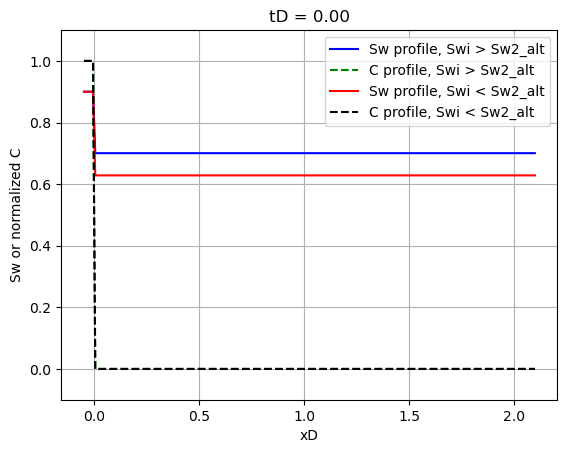

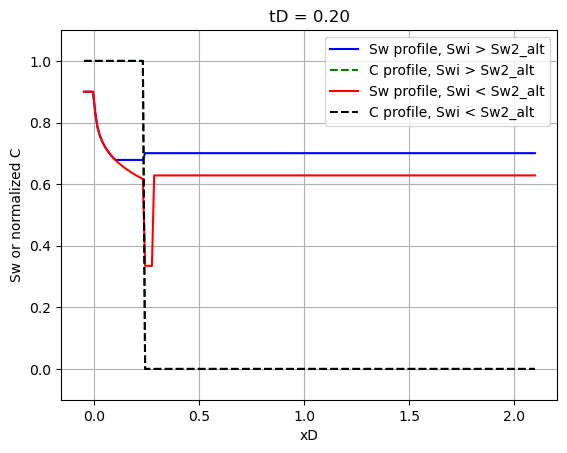

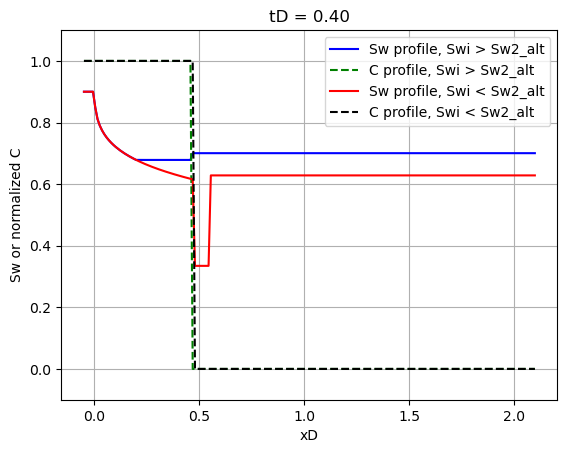

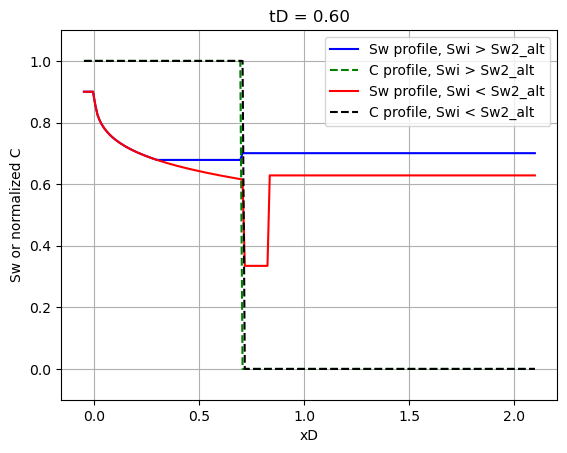

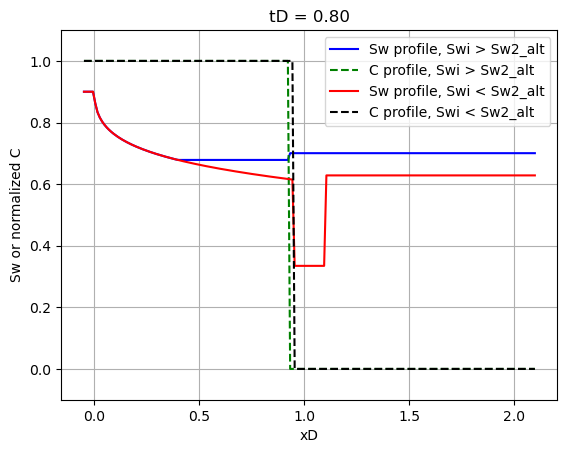

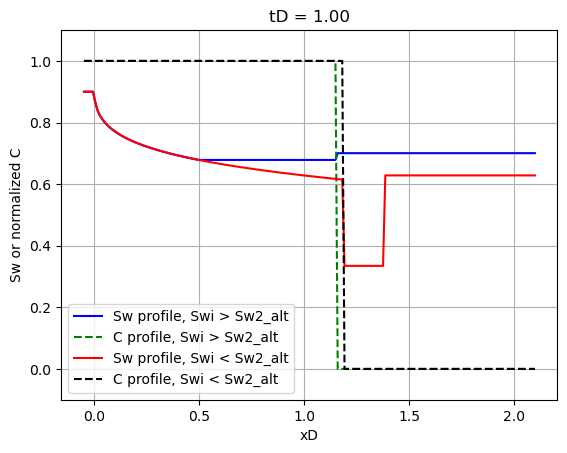

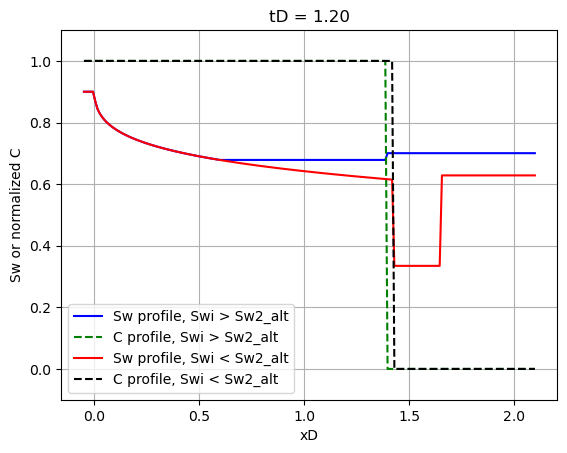

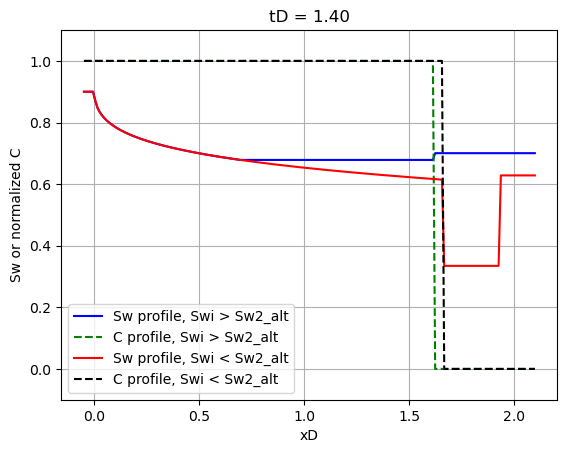

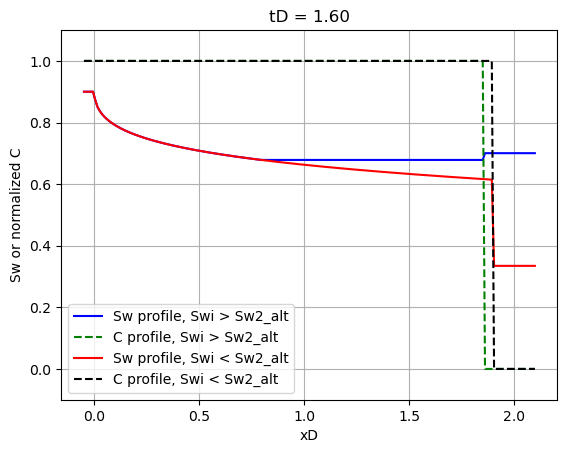

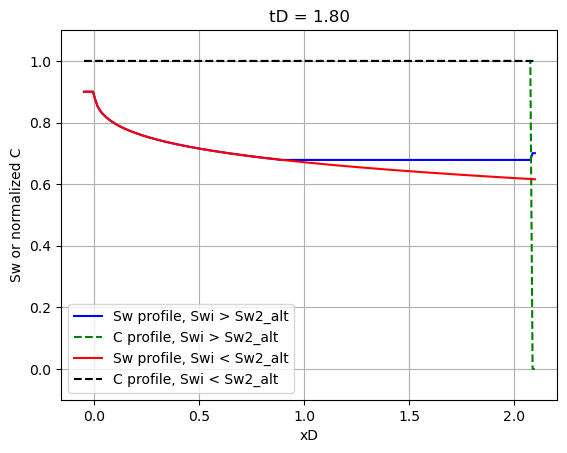

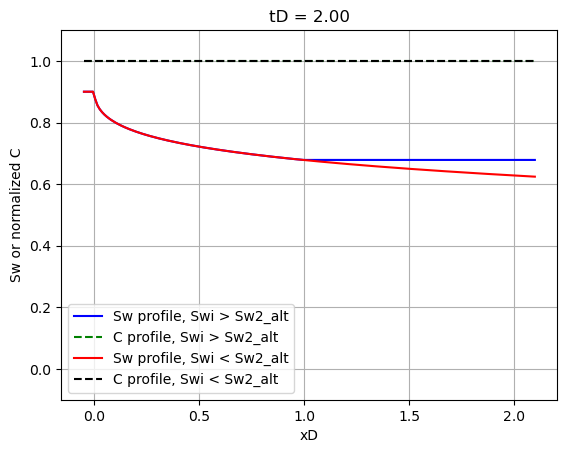

In [39]:
ts = np.linspace(0,2,11)
xs = np.linspace(-0.05,2.1,200)
ff.set_Swi(ff.Sw2_alt-0.05)

for t in ts:
    data = pd.Series()
    dataC = pd.Series()
    data_alt = pd.Series()
    dataC_alt = pd.Series()
    for x in xs:
        data[x] = ff_hi.calc_Sol(x,t)
        dataC[x] = ff_hi.calc_SolC(x,t)
        data_alt[x] = ff.calc_Sol(x,t)
        dataC_alt[x] = ff.calc_SolC(x,t)
    plt.plot(data, 'b-', label='Sw profile, Swi > Sw2_alt')
    plt.plot(dataC, 'g--', label='C profile, Swi > Sw2_alt')
    plt.plot(data_alt, 'r-', label='Sw profile, Swi < Sw2_alt')
    plt.plot(dataC_alt, 'k--', label='C profile, Swi < Sw2_alt')
    plt.xlabel('xD')
    plt.ylabel('Sw or normalized C')
    plt.ylim(-0.1,1.1)
    plt.title(f'tD = {t:4.2f}')
    plt.grid()
    plt.legend()
    plt.show()

## Average water saturation calculations

The average water saturation in the interval $0 \leq x_D \leq 1$ is calculated in three different ways:
1) Integration of the water saturation profile using the SciPy function **quad**
2) Brute force integration over the net injection volume into the interval $0 \leq x_D \leq 1$
3) Analytical solution 

### Average water saturation: integration using **quad**

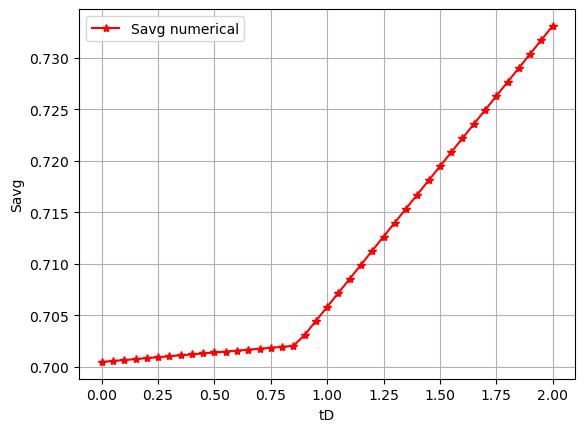

In [40]:
# Tolerance for integration function quad
quad_eps = 1e-4

ts = np.linspace(0.0,2,41)
Savg = pd.Series()
for t in ts:
    # the method calc_quad_points identifies the discontinuities in the water saturation profile as
    # input for the integration function quad
    points = ff_hi.calc_quad_points(t)
    Savg[t] = quad(ff_hi.calc_Sol,0,1,args=(t,),points=points,epsrel=quad_eps,epsabs=quad_eps)[0]

plt.plot(ts,Savg, 'r*-', label = 'Savg numerical')
#plt.ylim(0,1)
plt.ylabel('Savg')
plt.xlabel('tD')
plt.legend()
plt.grid()

### Average water saturation: brute force integration over the net injection volume

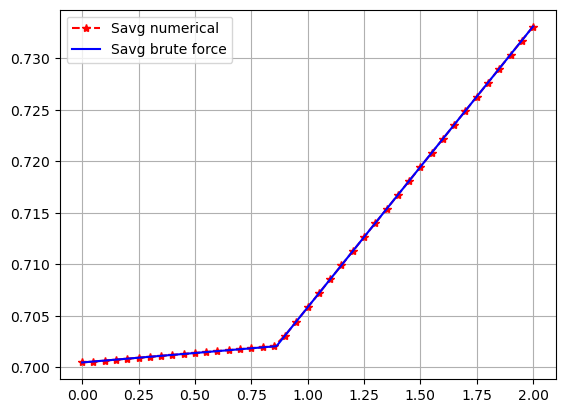

In [41]:
# Set time interval and timesteps for integration
ts, DelT = np.linspace(0.0,2.0,1001, retstep=True)
# NetIn = net injection volume during timestep
NetIn = pd.Series()
for t in ts:
    NetIn[t] = (1.0 - ff_hi.fw(ff_hi.calc_Sol(1.0,t),ff_hi.calc_SolC(1.0,t)))*DelT

plt.plot(Savg, 'r*--', label = 'Savg numerical')
# the method cumsum performs the integration over the time interval
plt.plot(Swi_hi+NetIn.cumsum(), 'b-', label='Savg brute force')
plt.grid()
plt.legend()

### Average water saturation: analytical solution

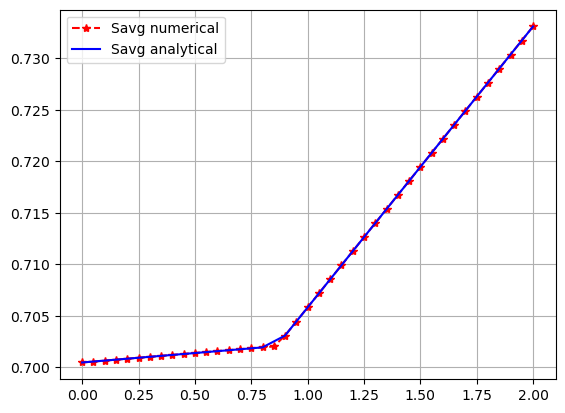

In [42]:
ts = np.linspace(0.0,2,21)
Savg2 = pd.Series()
for t in ts:
    Savg2[t] = ff_hi.calc_Savg(t)

plt.plot(Savg, 'r*--', label = 'Savg numerical')
plt.plot(Savg2, 'b-', label='Savg analytical')
plt.grid()
plt.legend()

# The zero adsorption case.

As discussed earlier, without adsorption the transition from (Sw=Sw1,C=1) to (Sw=Sw2,C=0) is not a shock, but a contact discontinuity.

With some algebra one finds:
$$
\nabla \lambda_C \cdot r_C = \left( \dfrac{\partial f_w}{\partial S_w} - \dfrac{f_w}{S_w+\frac{da}{dC}} \right) \frac{f_w}{\left(S_w+\frac{da}{dC}\right)^2} \dfrac{d^2a}{dC^2}
$$

So, without adsorption, a(C)=0, one finds $\nabla \lambda_C \cdot r_C = 0$.

This implies that the C-wave is linearly degenerate and $\lambda_C$ is constant on its integral curves. This results in a so called contact discontinuity with a speed $\lambda_C$. Note that also the 'shock' speeds on a Hugoniot locus are constant and equal to $\lambda_C$. One can easily derive this from the Rankine-Hugoniot condition which by setting $a(C)=0$ becomes:
$$
\dfrac{f_w(S_w^+,C^+)}{S_w^+} = \dfrac{f_w(S_w^-,C^-)}{S_w^-}
$$
From this one can see that the Hugoniot locus forms a straight line in a plot of fw(Sw,C) vs Sw with varying C.   
From which follows, as $\frac{da}{dC}=0$:
$$
\sigma_C = \dfrac{f_w(S_w,C)}{S_w} = \lambda_C
$$

Therefore, treating the contact discontinuity as a shock in the code, is OK.


In [43]:
# Create a zero adsorption model with the same parameters as 'ff' used above
params_noads = params
params_noads['ad1'] = 0
ff_noads = pu.FracFlow(params_dict = params_noads)

## Determine the C-wave integral curve through (Sw=Sw1_IC, C=1) and the C-wave Hugoniot locus through (Sw=Sw1, C=1)

In [44]:
# 2-wave integral curve through (Sw=Sw1_IC, C=1)
Sst=ff_noads.Sw1_IC; Cst=1.0
# Keeping away from singularity
eps_S = 1e-8
# Branch: Scw <= Sw <= Sw1_IC
IC_S1 = np.linspace(Sst,ff_noads.Scw,101)
IC_C1 = odeint(ff_noads.dC_dS,Cst,IC_S1)
IC1 = pd.DataFrame(data={'S':IC_S1,'C':IC_C1.T[0]})
IC1 = IC1[IC1['C']>=-0.05]
# Branch: Sw1_IC <= Sw <= 1-Sorw
IC_S2 = np.linspace(Sst,1.0-ff_noads.Sorw-eps_S,101)
IC_C2 = odeint(ff_noads.dC_dS,Cst,IC_S2)
IC2 = pd.DataFrame(data={'S':IC_S2,'C':IC_C2.T[0]})
IC2 = IC2[IC2['C']>=-0.05]

# 2-wave Hugoniot locus through (Sw=Sw1, C=1)
Sst=ff_noads.Sw1; Cst=1.0
# Keeping away from singularity
eps_S = 1e-8
# For Sw > Sst, no solution for C=Cst
eps_C = 1e-4

# Solution: C <= Cst & Sw < Sst
HG_C1 = np.linspace(0.0,Cst-eps_C,101)
HG_S1 = pd.Series(name='S')
for C in HG_C1: 
    S = brentq(lambda Sw: ff_noads.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),ff_noads.Scw+eps_S,Sst-eps_S)
    HG_S1[C] = S
HG1 = HG_S1.to_frame().reset_index(names='C')

# Solution: C > Cst & Smin < Sw < Sst
Smin = HG_S1.iloc[-2]
HG_S1 = np.linspace(Smin, Sst-eps_S, 11)
HG_C1 = pd.Series(name='C')
for S in HG_S1:
    C = brentq(lambda C: ff_noads.hugo(Sw=S,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),Cst*0.9,3.0)
    HG_C1[S] = C
HG1_append = HG_C1.to_frame().reset_index(names='S')
HG1 = pd.concat([HG1.iloc[:-1],HG1_append])

# Solution: C < Cst & Sw > Sst
HG_C2 = np.linspace(0.0, Cst-eps_C, 101)
HG_S2= pd.Series(name='S')
for C in HG_C2: 
    S = brentq(lambda Sw: ff_noads.hugo(Sw,C=C,Sst=Sst,Cst=Cst,epsAds=1e-8),Sst+eps_S,1.0-ff_noads.Sorw)
    HG_S2[C] = S
HG2 = HG_S2.to_frame().reset_index(names='C')

print('Starting point of the shocks:')
print(f'Sw1 = {ff_noads.Sw1:4.2f}, C = 1.00')
# Sw2 = the saturation value at the end of the 2-wave shock for C=0; Sw2 lower than Sw1
Sw2 = HG1.iloc[0]['S']
print('End point of the 2-wave shock:')
print(f'Sw2 = {Sw2:4.2f}, C = {HG1.iloc[0]['C']:4.2f}')
# Sw2_alt = the saturation value at the end of the 2-wave shock for C=0; Sw2_alt higher then Sw1
Sw2_alt = HG2.iloc[0]['S']
print('Alternative end point of the 2-wave shock')
print(f'Sw2_alt = {Sw2_alt:4.2f}, C = {HG1.iloc[0]['C']:4.2f}')

# Consistency check with internal calculations
print('\nConsistency check with internal FracFlow calculations:')
print(f'Sw2 / ff_noads.Sw2         =  {Sw2/ff_noads.Sw2:4.2e}')
print(f'Sw2_alt / ff_noads.Sw2_alt =  {Sw2_alt/ff_noads.Sw2_alt:4.2e}')

Starting point of the shocks:
Sw1 = 0.59, C = 1.00
End point of the 2-wave shock:
Sw2 = 0.31, C = 0.00
Alternative end point of the 2-wave shock
Sw2_alt = 0.66, C = 0.00

Consistency check with internal FracFlow calculations:
Sw2 / ff_noads.Sw2         =  1.00e+00
Sw2_alt / ff_noads.Sw2_alt =  1.00e+00


C:\Users\Tsuyoshi\AppData\Local\Temp\ipykernel_24744\4218939912.py:12: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  IC_C2 = odeint(ff_noads.dC_dS,Cst,IC_S2)


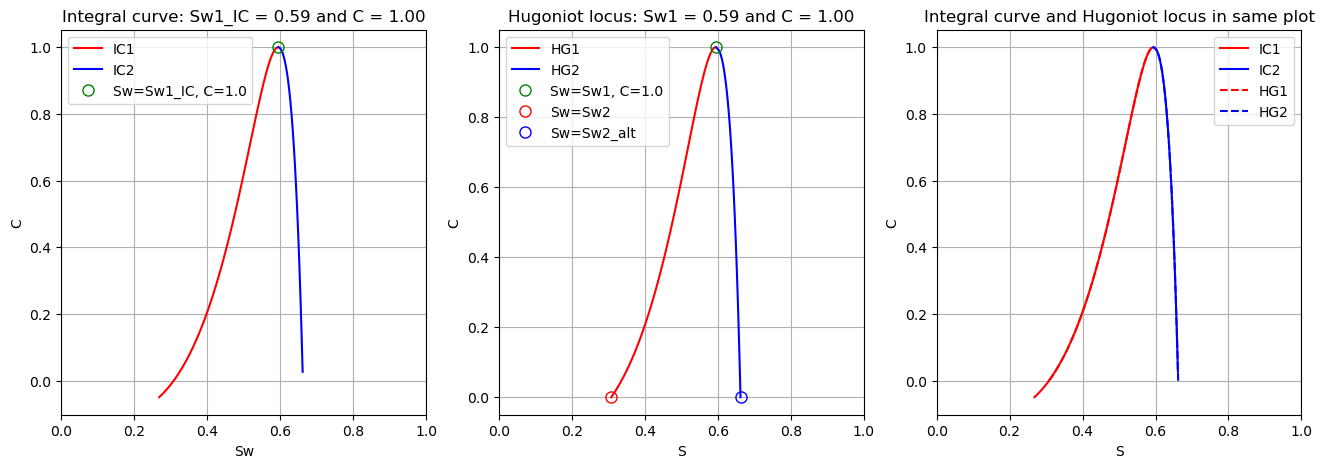

In [45]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
IC1.plot(x='S',y='C', style='r-', ax=ax[0], label='IC1')
IC2.plot(x='S',y='C', style='b-', ax=ax[0], label='IC2')
ax[0].plot(ff_noads.Sw1_IC,1,'go', label='Sw=Sw1_IC, C=1.0', markersize=8, fillstyle='none')

ax[0].set_xlim(0,1)
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('C')
ax[0].legend()
ax[0].set_title(f'Integral curve: Sw1_IC = {ff_noads.Sw1_IC:4.2F} and C = {Cst:4.2f}')
ax[0].grid()

HG1.plot(x='S',y='C', style='r-', ax=ax[1], label='HG1')
HG2.plot(x='S',y='C', style='b-', ax=ax[1], label='HG2')
ax[1].plot(ff_noads.Sw1,1,'go', label='Sw=Sw1, C=1.0', markersize=8, fillstyle='none')

ax[1].plot(Sw2,0, 'ro', label='Sw=Sw2', markersize=8, fillstyle='none')
ax[1].plot(Sw2_alt,0, 'bo', label='Sw=Sw2_alt', markersize=8, fillstyle='none')

ax[1].set_xlim(0.,1.)
ax[1].set_xlabel('S')
ax[1].set_ylabel('C')
ax[1].legend()
ax[1].set_title(f'Hugoniot locus: Sw1 = {ff_noads.Sw1:4.2F} and C = {Cst:4.2f}')
ax[1].grid()

IC1.plot(x='S',y='C', style='r-', ax=ax[2], label='IC1')
IC2.plot(x='S',y='C', style='b-', ax=ax[2], label='IC2')

HG1.plot(x='S',y='C', style='r--', ax=ax[2], label='HG1')
HG2.plot(x='S',y='C', style='b--', ax=ax[2], label='HG2')

ax[2].set_xlim(0,1)
ax[2].set_xlabel('S')
ax[2].set_ylabel('C')
ax[2].set_title('Integral curve and Hugoniot locus in same plot')
ax[2].grid()


## Integral curve and Hugoniot locus in fw vs Sw plot

Note that the integral curve and Hugoniot locus plot as a straight line in a fw vs Sw plot

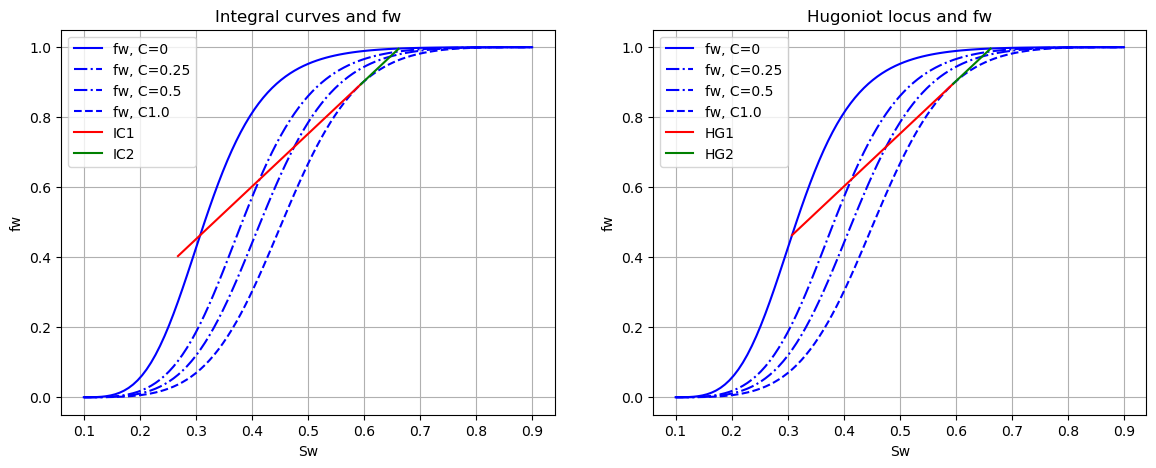

In [46]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

Ss = np.linspace(ff_noads.Scw,1.0-ff_noads.Sorw,101)

ax[0].plot(Ss,ff_noads.fw(Ss,0), 'b-', label = 'fw, C=0')
ax[0].plot(Ss,ff_noads.fw(Ss,0.25), 'b-.', label = 'fw, C=0.25')
ax[0].plot(Ss,ff_noads.fw(Ss,0.5), 'b-.', label = 'fw, C=0.5')
ax[0].plot(Ss,ff_noads.fw(Ss,1.0), 'b--', label = 'fw, C1.0')
ax[0].plot(IC1['S'],ff_noads.fw(IC1['S'],IC1['C']), 'r-', label='IC1')
ax[0].plot(IC2['S'],ff_noads.fw(IC2['S'],IC2['C']), 'g-', label='IC2')
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('fw')
ax[0].set_title('Integral curves and fw')
ax[0].grid()
ax[0].legend()

ax[1].plot(Ss,ff_noads.fw(Ss,0), 'b-', label = 'fw, C=0')
ax[1].plot(Ss,ff_noads.fw(Ss,0.25), 'b-.', label = 'fw, C=0.25')
ax[1].plot(Ss,ff_noads.fw(Ss,0.5), 'b-.', label = 'fw, C=0.5')
ax[1].plot(Ss,ff_noads.fw(Ss,1.0), 'b--', label = 'fw, C1.0')
ax[1].plot(HG1['S'],ff_noads.fw(HG1['S'],HG1['C']), 'r-', label='HG1')
ax[1].plot(HG2['S'],ff_noads.fw(HG2['S'],HG2['C']), 'g-', label='HG2')
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('fw')
ax[1].set_title('Hugoniot locus and fw')
ax[1].grid()
ax[1].legend()

## Check the speeds

As discussed above, the lamC speeds and the C-wave shock speeds are constant on the integral curve resp. Hugoniot locus. They also have the same value.

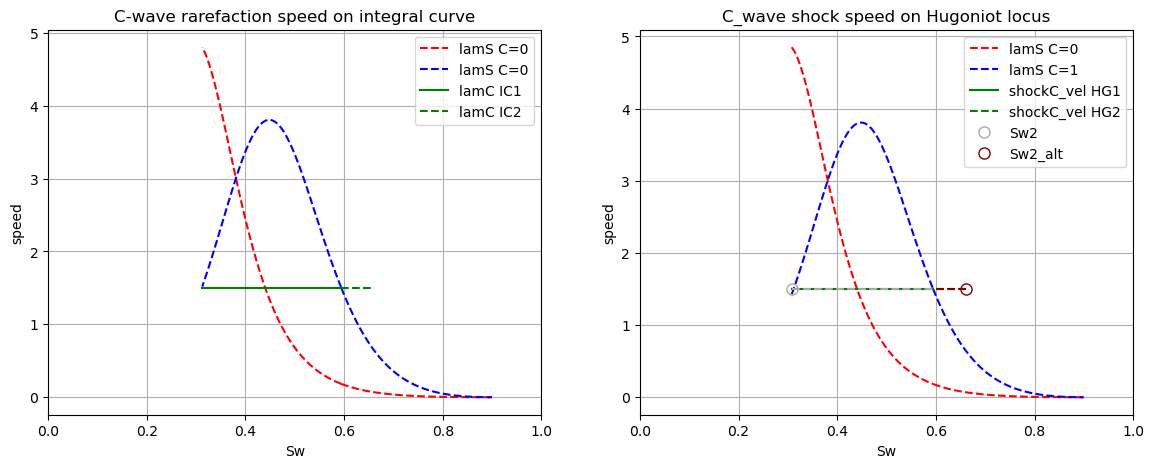

In [47]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

IC1 = IC1[IC1['C']>=0.0]
IC2 = IC2[IC2['C']>=0.0]

# plotting speeds of the C-wave rarefaction
Ss = np.linspace(ff_noads.Sw1_IC,1.0-ff_noads.Sorw,101)
ax[0].plot(Ss,ff_noads.lamS(Ss,0),'r--', label='lamS C=0')
ax[0].plot(IC1['S'],ff_noads.lamS(IC1['S'],0),'r--')
ax[0].plot(Ss,ff_noads.lamS(Ss,1),'b--', label='lamS C=0')
ax[0].plot(IC1['S'],ff_noads.lamS(IC1['S'],1),'b--')

ax[0].plot(IC1['S'],ff_noads.lamC(IC1['S'],IC1['C']),'g-', label='lamC IC1')
ax[0].plot(IC2['S'],ff_noads.lamC(IC2['S'],IC2['C']),'g--', label='lamC IC2')
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('speed')
ax[0].set_title('C-wave rarefaction speed on integral curve')
ax[0].set_xlim(0,1)
# ax[0].set_ylim(1.4,1.6)
ax[0].legend()
ax[0].grid()

# plotting speeds of the C-wave shock
# Speed jumping to (S=0.16,C=0)
vel_jump = ff_noads.shockC_vel(C=HG1.iloc[0]['C'],Swst=ff_noads.Sw1_IC,Cst=1)
vel_jump_alt = ff_noads.shockC_vel(C=HG2.iloc[0]['C'],Swst=ff_noads.Sw1_IC,Cst=1)

Ss = np.linspace(ff_noads.Sw1,1.0-ff_noads.Sorw,101)
ax[1].plot(Ss,ff_noads.lamS(Ss,0),'r--', label='lamS C=0')
ax[1].plot(HG1['S'],ff_noads.lamS(HG1['S'],0),'r--')
ax[1].plot(Ss,ff_noads.lamS(Ss,1),'b--', label='lamS C=1')
ax[1].plot(HG1['S'],ff_noads.lamS(HG1['S'],1),'b--')

ax[1].plot(HG1['S'],ff_noads.shockC_vel(C=HG1['C'],Swst=ff_noads.Sw1,Cst=1),'g-', label='shockC_vel HG1')
ax[1].plot(HG2['S'],ff_noads.shockC_vel(C=HG2['C'],Swst=ff_noads.Sw1,Cst=1),'g--', label='shockC_vel HG2')
ax[1].plot((HG1.iloc[0]['S'],ff_noads.Sw1),(vel_jump,vel_jump), 'darkgrey', linestyle='dashed')
ax[1].plot((HG2.iloc[0]['S'],ff_noads.Sw1),(vel_jump_alt,vel_jump_alt), 'maroon', linestyle='dashed')
ax[1].plot(Sw2,vel_jump, 'o', markeredgecolor='darkgray', markersize=8, fillstyle='none', label='Sw2')
ax[1].plot(Sw2_alt,vel_jump_alt, 'o', markeredgecolor='maroon', markersize=8, fillstyle='none', label='Sw2_alt')
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('speed')
ax[1].set_title('C_wave shock speed on Hugoniot locus')
ax[1].set_xlim(0,1)
# ax[1].set_ylim(1.4,1.6)
ax[1].legend()
ax[1].grid()

# Oil Corey exponent, no = 1

If the no=1, $\lambda_S(S_w=1-S_{orw},C=1)$ is no longer zero (for no>1, it is zero). In this case, there is no longer always a solution $S_{w1}$ for:
$$
\lambda(S_w,C=1) = \dfrac{f_w(S_w,C=1)}{S_w + a(C=1)}
$$
and the general solution discussed earlier will no longer hold.

Below we will show that for no=1 the solution is as follows:  
1) if Sw1 exists, it is the same as the general solution discussed above  

2) if Sw1 does not exist and the Hugoniot locus for (Sw=1-Sorw,C=1) consists of two branches, the solution is
    * C-wave shock from (Sw=1-Sorw,C=1) to (Sw=Sw2,C=1) with Sw2 the C=0 state on the 'left' branch  
    * S-wave (C=0) from (Sw2,C=0) to (Swi,C=0) a la Buckley Leverett like in the general solution  

3) if Sw1 does not exist and the Hugoniot locus for (Sw=1-Sorw,C=1) is (Sw=1-Sorw,C) with 0<=C<=1, the solution is  
    * C-wave from from (Sw=1-Sorw,C=1) to (Sw=1-Sorw,C=0). Note only C changes, Sw remains constant.  
    * S-wave (C=0) from (Sw=1-Sorw,C=0) tp (Swi,C=0) a la Buckley Leverett like in the general solution  

## Mobilty ratio is a parameter that determines whether an Sw1 solution exists

In the plots below one can see that for $\mu_o$ = 0.1 and 1, there is no solution for Sw1. This means that the general solution presented earlier is not possible.

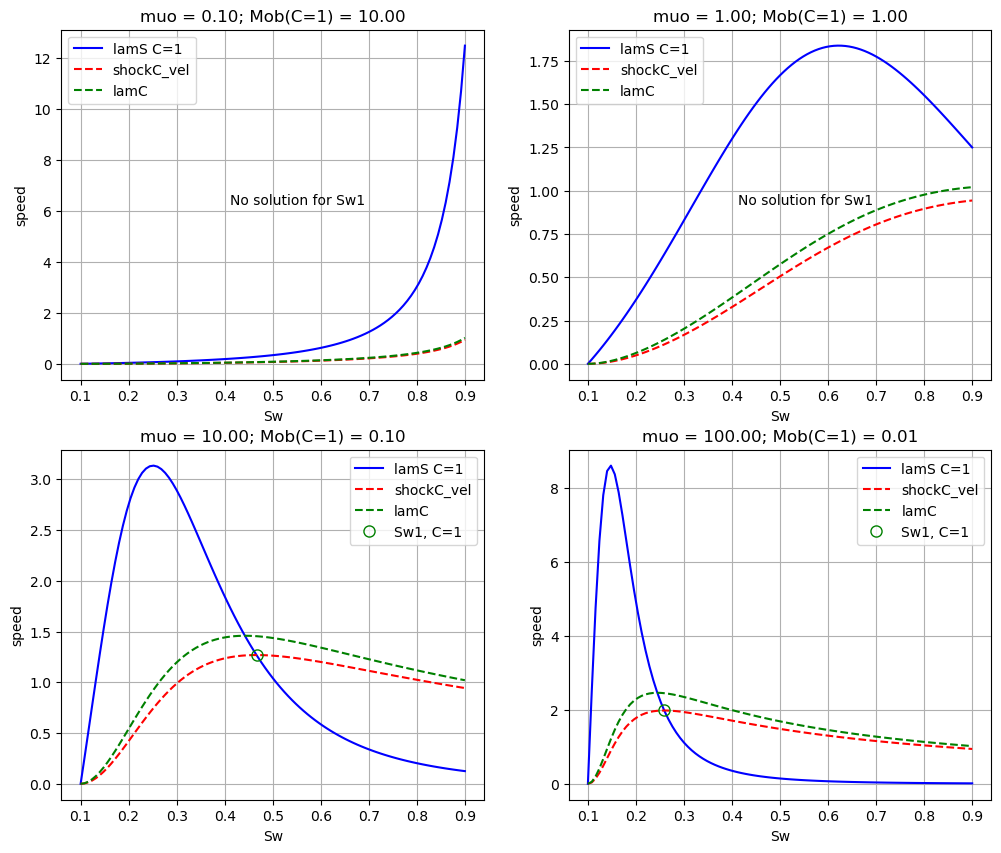

In [48]:
# Vary the oil viscosity muo and check whether a solution for Sw1 exists

# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params_no1 = { 'krwe': 1.0, 'nw': 2.0, 'Scw': 0.1,
               'kroe': 1.0, 'no': 1.0, 'Sorw': 0.1,
               'muo':  1.0, 'muw': 0.5, 'mup': 1.0,
               'ad1': ad1, 'ad2': ad2 }

ff_no1_muo1 = pu.FracFlow(params_dict = params_no1)

muos = [0.1, 1, 10, 100]
Ss = np.linspace(ff_no1_muo1.Scw,1.0-ff_no1_muo1.Sorw, 101)
fig, ax = plt.subplots(2,2,figsize=(12,10))
for n, muo in enumerate(muos):
    i = int(n/2)
    j = n%2
    params_no1['muo'] = muo
    ff_no1_muo1 = pu.FracFlow(params_dict = params_no1)
    ax[i,j].plot(Ss,ff_no1_muo1.lamS(Ss,1), 'b-', label='lamS C=1')
    ax[i,j].plot(Ss,ff_no1_muo1.shockC_vel(C=0,Swst=Ss,Cst=1), 'r--', label='shockC_vel')
    ax[i,j].plot(Ss,ff_no1_muo1.lamC(Ss,C=1)*np.ones_like(Ss), 'g--', label='lamC')
    if ff_no1_muo1.S_rare_C1:
        ax[i,j].plot(ff_no1_muo1.Sw1,ff_no1_muo1.lamS(ff_no1_muo1.Sw1,1),'go', markersize=8, fillstyle='none', label='Sw1, C=1')
    else:
        ax[i,j].text(0.4,0.5,'No solution for Sw1', transform=ax[i,j].transAxes)
    ax[i,j].set_title(f'muo = {muo:4.2f}; Mob(C=1) = {ff_no1_muo1.Mob(1):4.2f}')
    ax[i,j].set_xlabel('Sw')
    ax[i,j].set_ylabel('speed')
    ax[i,j].legend()
    ax[i,j].grid()



## Construction of the solution for no=1

Below we will look at three oil viscosity scenarios to understand the solution for no=1, viz:
1) muo = 10: Sw1 exists; the solution is the same as the general solution discussed earlier.
2) muo = 1: Sw1 does not exist; an intermediate state (Sw=Sw2,C=0) exists to which a C-wave shock takes place from (Sw=1-Sorw,C=1)
3) muo = 0.1: Sw1 does not exit; the C-wave shock is from (Sw=1-Sorw,C=1)  to (Sw=1-Sorw,C=0), i.e. the shock is purely in C, Sw remains unchanged

Note that a C-wave rarefaction from (Sw=1-Sorw,C=1) is not possible, as the integral curve is still (Sw=1-Sorw, C) for all scenarios and the C-wave speed increases if C decreases from 1 to 0.

### Case 1: no=1, muo=10

In this case Sw1 exists and we will show that there is no C-wave shock possible from (Sw=1-Sorw,C=1), contrary to the two other muo scenarios.

Below the Hugoniot locus for (Sw=1-Sorw,C=1) is determined and plotted. Two potential C-wave shock (C=0) endpoints, Sw2 and Sw2_alt, are identified.

As discussed earlier, the entropy conditions for a admissible shock are:
1) $C_L > C_R$; this condition is fulfilled by both potential shocks
2) $\lambda_S(U_R) < \sigma_C$ or $\lambda_S(U_L), \lambda_S(U_R) \geq \sigma_C$  

The shock with endpoint Sw2 does not fulfill the entropy conditions, as we have:
$$
\lambda_S(U_L) < \sigma_C(S_{w2}) < \lambda_S(U_R)
$$

The shock with endpoint Sw2_alt does fulfill the entropy conditions, as we have:
$$
\lambda_S(U_R) < \sigma_C(S_{w2-alt})
$$
However, the S-wave following this C-wave shock would have a speed lower than the shock speed which would not result in a valid solution path. Therefore, like in the general solution the correct solution would start with an S-wave rarefaction, as can be seen in the solution plot for this case.

Sw2 = 0.22, C = 0.00
Sw2_alt = 0.90, C = 0.00


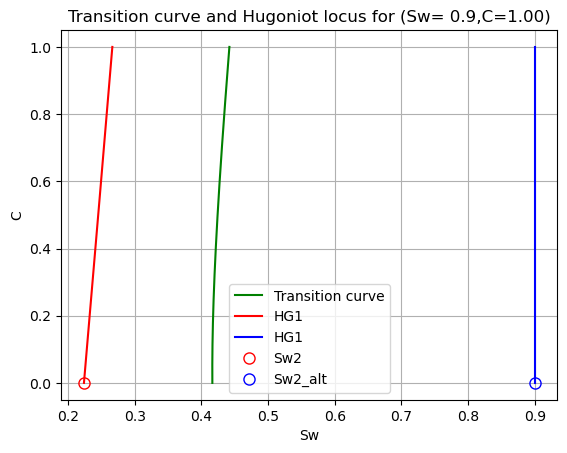

In [49]:
params_no1['muo'] = 10
ff_no1_muo10 = pu.FracFlow(params_dict = params_no1)

eps_S = 1e-8

Cs = np.linspace(0,1,1000)
Trans_no1 = pd.Series(name='Sw')
for C in Cs:
    try:
        Trans_no1[C] = brentq(lambda Sw: dif_lamS_lamC(Sw,C=C,ff=ff_no1_muo10),ff_no1_muo10.Scw+eps_S,1-ff_no1_muo10.Sorw-eps_S)
    except ValueError as e:
        pass
if Trans_no1.empty:
    print('No solution for Transition curve')
Trans_no1 = Trans_no1.to_frame().reset_index(names='C')

Sst=1.0-ff_no1_muo10.Sorw; Cst=1.0

Cs = np.linspace(0,1,1000)
HG1 = pd.Series(name='Sw')
HG2 = pd.Series(name='Sw')
for C in Cs:
    try:
        HG1[C] = brentq(lambda Sw: ff_no1_muo10.hugo(Sw,C=C,Sst=Sst,Cst=Cst, epsAds=1e-8),ff_no1_muo10.Scw,1-ff_no1_muo10.Sorw-eps_S)
    except ValueError as e:
        pass
    HG2[C] = brentq(lambda Sw: ff_no1_muo10.hugo(Sw,C=C,Sst=Sst,Cst=Cst, epsAds=1e-8),1-ff_no1_muo10.Sorw,1-ff_no1_muo10.Sorw)
if HG1.empty:
    print('No solution for HG1')
HG1 = HG1.to_frame().reset_index(names='C')
HG2 = HG2.to_frame().reset_index(names='C')

if not HG1.empty:
    Sw2 = HG1.iloc[0]['Sw']
    print(f'Sw2 = {Sw2:4.2f}, C = {HG1.iloc[0]["C"]:4.2f}')
Sw2_alt = HG2.iloc[0]['Sw']
print(f'Sw2_alt = {Sw2_alt:4.2f}, C = {HG2.iloc[0]["C"]:4.2f}')

fig, ax = plt.subplots()
if not Trans_no1.empty:
    Trans_no1.plot(x='Sw',y='C', ax=ax, style='g-', label='Transition curve')
if not HG1.empty:
    HG1.plot(x='Sw',y='C', ax=ax, style='r-', label='HG1')
HG2.plot(x='Sw',y='C', ax=ax, style='b-', label='HG1')
if not HG1.empty:
    ax.plot(Sw2,0, 'ro', label='Sw2', markersize=8, fillstyle='none')
ax.plot(Sw2_alt,0, 'bo', label='Sw2_alt', markersize=8, fillstyle='none')
ax.set_title(f'Transition curve and Hugoniot locus for (Sw={Sst:4.2},C={Cst:4.2f})')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.grid()
ax.legend();

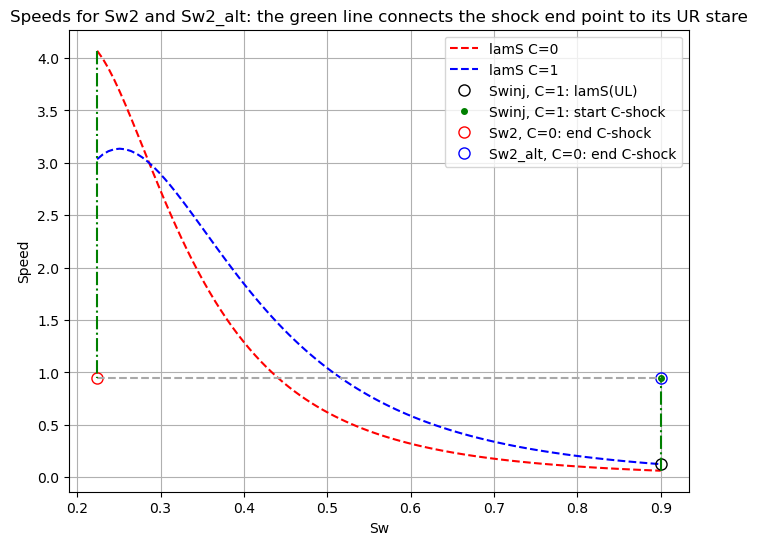

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
Ss = np.linspace(Sw2,Sw2_alt,101)
ax.plot(Ss, ff_no1_muo10.lamS(Ss,0), 'r--', label='lamS C=0')
ax.plot(Ss, ff_no1_muo10.lamS(Ss,1), 'b--', label='lamS C=1')

ax.plot(1-ff_no1_muo10.Sorw,ff_no1_muo10.lamS(1-ff_no1_muo10.Sorw,1),'ko', markersize=8, fillstyle='none',  label='Swinj, C=1: lamS(UL)')
ax.plot(1-ff_no1_muo10.Sorw,ff_no1_muo10.shockC_vel(C=1,Swst=Sw2,Cst=0),'go', markersize=4, label='Swinj, C=1: start C-shock')
ax.plot(Sw2, ff_no1_muo10.shockC_vel(C=1,Swst=Sw2,Cst=0), 'ro', markersize=8, fillstyle='none', label='Sw2, C=0: end C-shock')
ax.plot(Sw2_alt, ff_no1_muo10.shockC_vel(C=1,Swst=Sw2_alt,Cst=0), 'bo', markersize=8, fillstyle='none', label='Sw2_alt, C=0: end C-shock')
ax.plot((Sw2,Sw2_alt),(ff_no1_muo10.shockC_vel(C=1,Swst=Sw2,Cst=0),ff_no1_muo10.shockC_vel(C=1,Swst=Sw2_alt,Cst=0)), 'darkgrey', linestyle='dashed')
ax.plot((Sw2,Sw2),(ff_no1_muo10.lamS(Sw2,0),ff_no1_muo10.shockC_vel(C=1,Swst=Sw2,Cst=0)), 'g-.')
ax.plot((Sw2_alt,Sw2_alt),(ff_no1_muo10.lamS(Sw2_alt,0),ff_no1_muo10.shockC_vel(C=1,Swst=Sw2,Cst=0)), 'g-.')

ax.set_title('Speeds for Sw2 and Sw2_alt: the green line connects the shock end point to its UR stare')
ax.set_xlabel('Sw')
ax.set_ylabel('Speed')
ax.legend(loc='upper right')
ax.grid()

Sw1 = 0.4662
Sw2 = 0.2757
lamS(Sw=Sw1,C=1) = 1.2686
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.2686
S-wave shock speed = 3.1463


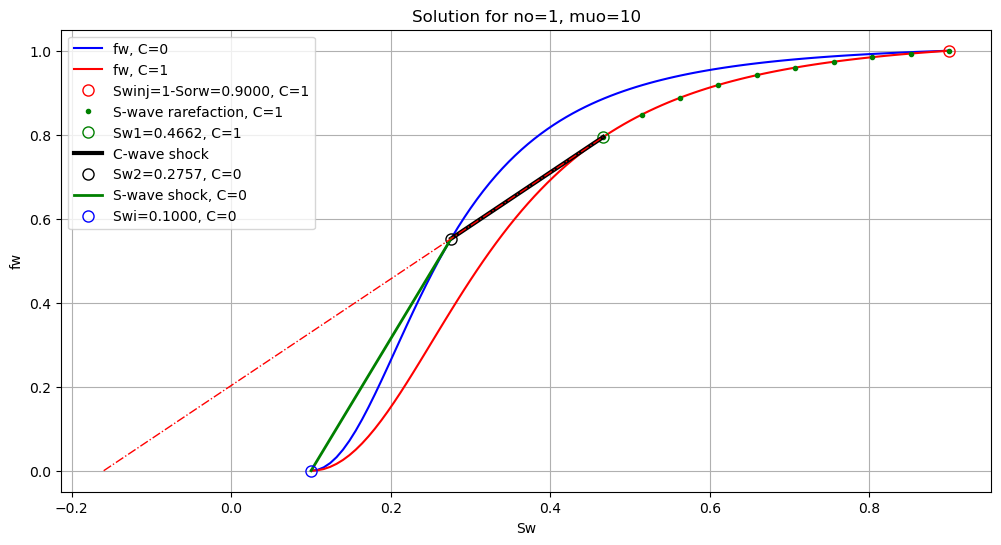

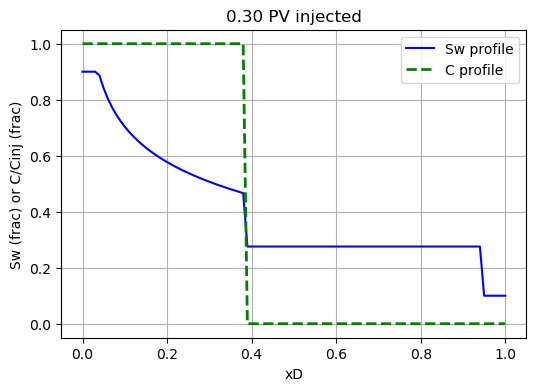

In [51]:
fig, ax = ff_no1_muo10.plot_solution()
ax.set_title('Solution for no=1, muo=10')
data, dataC, fig, ax = ff_no1_muo10.plot_profile(0.3)

### Case 2: no=1, muo=1

In this case no Sw1 solution exists, so the general solution starting with an S-wave rarefaction is not valid.

Again we start with determining the Hugoniot locus for (Sw=1-Sorw,C=1). It consists of two branches with to potential endpoint for a shock from (Sw=1-Sorw,C=1), viz. Sw2 and Sw2_alt.

In this case both potential shocks fulfill the entropy conditions, as we find:
$$
\lambda_S(U_L), \lambda_S(U_R) \geq \sigma_C(S_{w2})
$$
and
$$
\lambda_S(U_R) < \sigma_C(S_{w2-alt})
$$

However, only the shock with endpoint Sw2 leads to a valid solution path, as for Sw2_alt the following S-wave (C=0) would be slower than the C-wave shock. For Sw2 the speeds do line up correctly in increasing order.

Therefore, the correct solution will be as follows:
1) C-wave shock from (Sw=1-Sorw,C=1) to (Sw=Sw2,C=0)
2) S-wave (C=0) a la Buckley Leverett as in the general solution.

The solution plot is shown below.

Sw2 = 0.68, C = 0.00
Sw2_alt = 0.90, C = 0.00


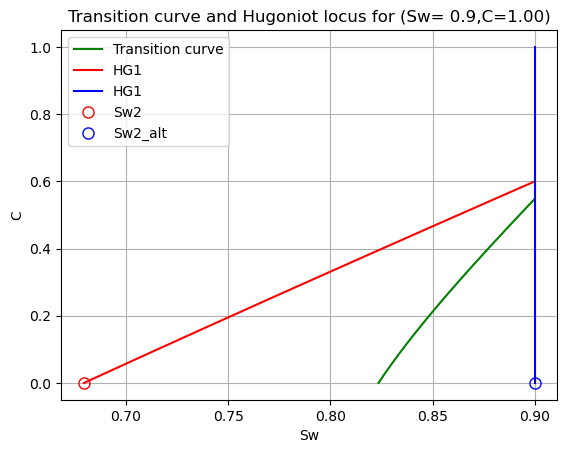

In [52]:
# params_no1['muo'] = 1.228
params_no1['muo'] = 1
ff_no1_muo1 = pu.FracFlow(params_dict = params_no1)

eps_S = 1e-8

Cs = np.linspace(0,1,1000)
Trans_no1 = pd.Series(name='Sw')
for C in Cs:
    try:
        Trans_no1[C] = brentq(lambda Sw: dif_lamS_lamC(Sw,C=C,ff=ff_no1_muo1),ff_no1_muo1.Scw+eps_S,1-ff_no1_muo1.Sorw-eps_S)
    except ValueError as e:
        pass
if Trans_no1.empty:
    print('No solution for Transition curve')
Trans_no1 = Trans_no1.to_frame().reset_index(names='C')

Sst=1.0-ff_no1_muo1.Sorw; Cst=1.0

Cs = np.linspace(0,1,1000)
HG1 = pd.Series(name='Sw')
HG2 = pd.Series(name='Sw')
for C in Cs:
    try:
        HG1[C] = brentq(lambda Sw: ff_no1_muo1.hugo(Sw,C=C,Sst=Sst,Cst=Cst, epsAds=1e-8),ff_no1_muo1.Scw,1-ff_no1_muo1.Sorw-eps_S)
    except ValueError as e:
        pass
    HG2[C] = brentq(lambda Sw: ff_no1_muo1.hugo(Sw,C=C,Sst=Sst,Cst=Cst, epsAds=1e-8),1-ff_no1_muo1.Sorw,1-ff_no1_muo1.Sorw)
if HG1.empty:
    print('No solution for HG1')
HG1 = HG1.to_frame().reset_index(names='C')
HG2 = HG2.to_frame().reset_index(names='C')

if not HG1.empty:
    Sw2 = HG1.iloc[0]['Sw']
    print(f'Sw2 = {Sw2:4.2f}, C = {HG1.iloc[0]["C"]:4.2f}')
Sw2_alt = HG2.iloc[0]['Sw']
print(f'Sw2_alt = {Sw2_alt:4.2f}, C = {HG2.iloc[0]["C"]:4.2f}')

fig, ax = plt.subplots()
if not Trans_no1.empty:
    Trans_no1.plot(x='Sw',y='C', ax=ax, style='g-', label='Transition curve')
if not HG1.empty:
    HG1.plot(x='Sw',y='C', ax=ax, style='r-', label='HG1')
HG2.plot(x='Sw',y='C', ax=ax, style='b-', label='HG1')
if not HG1.empty:
    ax.plot(Sw2,0, 'ro', label='Sw2', markersize=8, fillstyle='none')
ax.plot(Sw2_alt,0, 'bo', label='Sw2_alt', markersize=8, fillstyle='none')
ax.set_title(f'Transition curve and Hugoniot locus for (Sw={Sst:4.2},C={Cst:4.2f})')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.grid()
ax.legend();

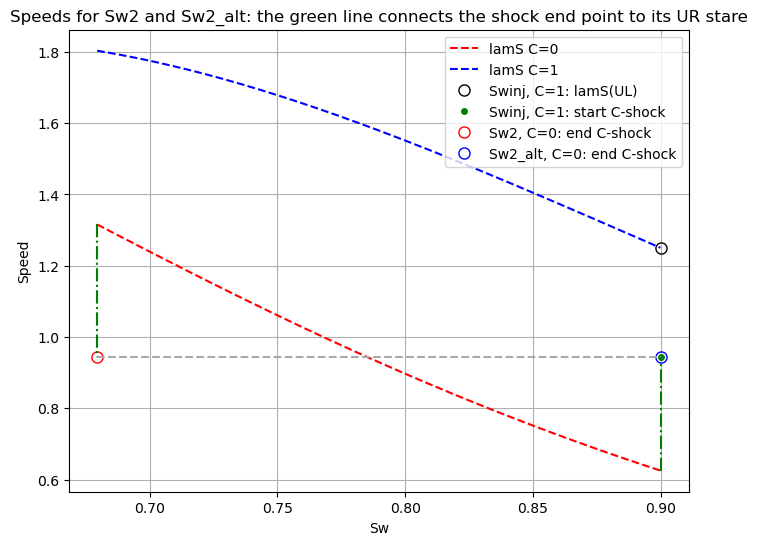

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(HG1['Sw'], ff_no1_muo1.lamS(HG1['Sw'],0), 'r--', label='lamS C=0')
ax.plot(HG1['Sw'], ff_no1_muo1.lamS(HG1['Sw'],1), 'b--', label='lamS C=1')

ax.plot(1-ff_no1_muo1.Sorw,ff_no1_muo1.lamS(1-ff_no1_muo1.Sorw,1),'ko', markersize=8, fillstyle='none',  label='Swinj, C=1: lamS(UL)')
ax.plot(1-ff_no1_muo1.Sorw,ff_no1_muo1.shockC_vel(C=1,Swst=Sw2,Cst=0),'go', markersize=4, label='Swinj, C=1: start C-shock')
ax.plot(Sw2, ff_no1_muo1.shockC_vel(C=1,Swst=Sw2,Cst=0), 'ro', markersize=8, fillstyle='none', label='Sw2, C=0: end C-shock')
ax.plot(Sw2_alt, ff_no1_muo1.shockC_vel(C=1,Swst=Sw2_alt,Cst=0), 'bo', markersize=8, fillstyle='none', label='Sw2_alt, C=0: end C-shock')
ax.plot((Sw2,Sw2_alt),(ff_no1_muo1.shockC_vel(C=1,Swst=Sw2,Cst=0),ff_no1_muo1.shockC_vel(C=1,Swst=Sw2_alt,Cst=0)), 'darkgrey', linestyle='dashed')
ax.plot((Sw2,Sw2),(ff_no1_muo1.lamS(Sw2,0),ff_no1_muo1.shockC_vel(C=1,Swst=Sw2,Cst=0)), 'g-.')
ax.plot((Sw2_alt,Sw2_alt),(ff_no1_muo1.lamS(Sw2_alt,0),ff_no1_muo1.shockC_vel(C=1,Swst=Sw2,Cst=0)), 'g-.')

ax.set_title('Speeds for Sw2 and Sw2_alt: the green line connects the shock end point to its UR stare')
ax.set_xlabel('Sw')
ax.set_ylabel('Speed')
ax.legend(loc='upper right')
ax.grid()

Sw1 = 1-Sorw = 0.9000
Sw2 = 0.6795
C-wave shock speed (1-Sorw,C=1)->(Sw2,C=0) = 0.9434
S-wave rarefaction speed, back = 1.3158
Sw3 = 0.6657
S-wave rarefaction speed, front = S-wave shock speed = 1.3673


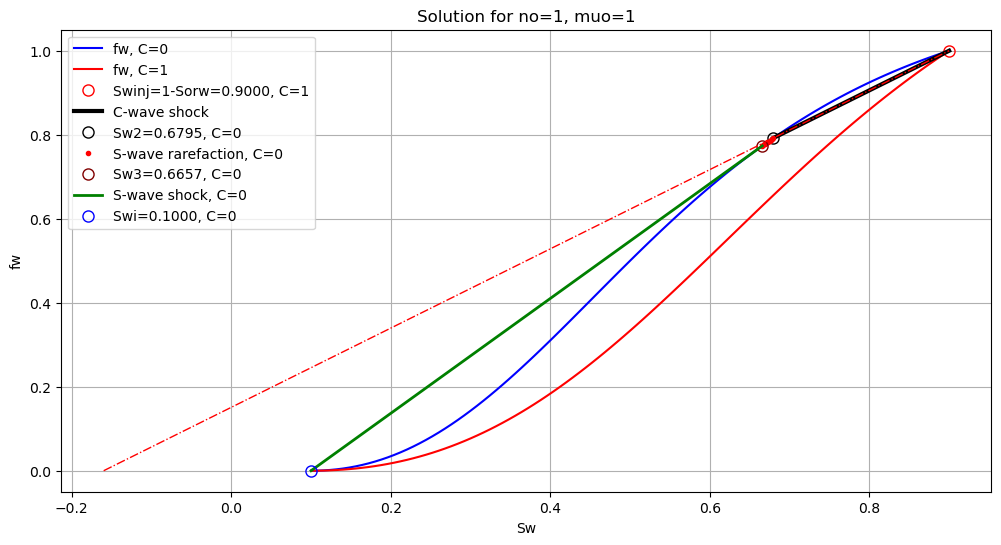

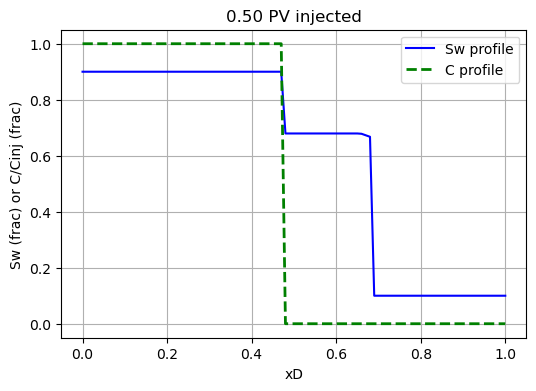

In [54]:
fig, ax = ff_no1_muo1.plot_solution()
ax.set_title('Solution for no=1, muo=1')
data, dataC, fig, ax = ff_no1_muo1.plot_profile(0.5)

### Case 3: no=1, muo=0.1

As in case 2, no Sw1 solution exists for this case, so the general solution starting with an S-wave rarefaction is not valid.

In this case the Hugoniot locus  for (Sw=1-Sorw,C=1) only has a single branch with to Sw2_alt as potential endpoint for a shock from (Sw=1-Sorw,C=1).

This potential shock fulfillS the entropy conditions, viz.:
$$
\lambda_S(U_L), \lambda_S(U_R) \geq \sigma_C(S_{w2-alt})
$$

It also leads to a valid solution path as the following S-wave (C=0) is faster than the C-wave shock.

Therefore, the correct solution will be as follows:
1) C-wave shock from (Sw=1-Sorw,C=1) to (Sw=1-Sorw,C=0): note the only the C changes, Sw remain the same.
2) S-wave (C=0) a la Buckley Leverett as in the general solution.

N.B. 1: because no=1, $\lambda_S(1-S_{orw},C=0)>0$; for no>1 it is zero which would lead to an invalid speed ordering (as in the general solution case)  
N.B. 2: in the code Sw2 is used for Sw2_alt

No solution for Transition curve
No solution for HG1
Sw2_alt = 0.90, C = 0.00


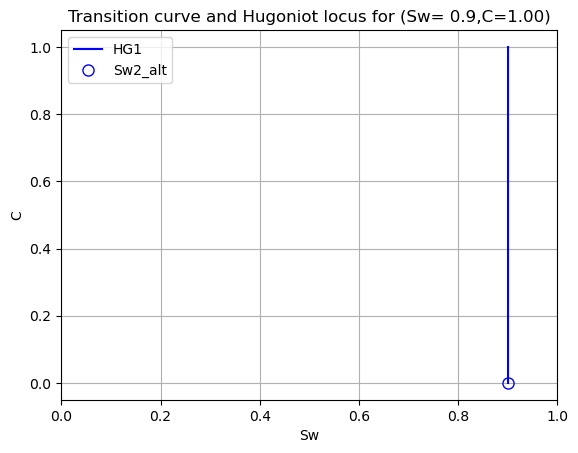

In [55]:
params_no1['muo'] = 0.1
ff_no1_muo01 = pu.FracFlow(params_dict = params_no1)

eps_S = 1e-8

Cs = np.linspace(0,1,1000)
Trans_no1 = pd.Series(name='Sw')
for C in Cs:
    try:
        Trans_no1[C] = brentq(lambda Sw: dif_lamS_lamC(Sw,C=C,ff=ff_no1_muo01),ff_no1_muo01.Scw+eps_S,1-ff_no1_muo01.Sorw-eps_S)
    except ValueError as e:
        pass
if Trans_no1.empty:
    print('No solution for Transition curve')
Trans_no1 = Trans_no1.to_frame().reset_index(names='C')

Sst=1.0-ff_no1_muo01.Sorw; Cst=1.0

Cs = np.linspace(0,1,1000)
HG1 = pd.Series(name='Sw')
HG2 = pd.Series(name='Sw')
for C in Cs:
    try:
        HG1[C] = brentq(lambda Sw: ff_no1_muo01.hugo(Sw,C=C,Sst=Sst,Cst=Cst, epsAds=1e-8),ff_no1_muo01.Scw,1-ff_no1_muo01.Sorw-eps_S)
    except ValueError as e:
        pass
    HG2[C] = brentq(lambda Sw: ff_no1_muo01.hugo(Sw,C=C,Sst=Sst,Cst=Cst, epsAds=1e-8),1-ff_no1_muo01.Sorw,1-ff_no1_muo01.Sorw)
if HG1.empty:
    print('No solution for HG1')
HG1 = HG1.to_frame().reset_index(names='C')
HG2 = HG2.to_frame().reset_index(names='C')

if not HG1.empty:
    Sw2 = HG1.iloc[0]['Sw']
    print(f'Sw2 = {Sw2:4.2f}, C = {HG1.iloc[0]["C"]:4.2f}')
Sw2_alt = HG2.iloc[0]['Sw']
print(f'Sw2_alt = {Sw2_alt:4.2f}, C = {HG2.iloc[0]["C"]:4.2f}')

fig, ax = plt.subplots()
if not Trans_no1.empty:
    Trans_no1.plot(x='Sw',y='C', ax=ax, style='g-', label='Transition curve')
if not HG1.empty:
    HG1.plot(x='Sw',y='C', ax=ax, style='r-', label='HG1')
HG2.plot(x='Sw',y='C', ax=ax, style='b-', label='HG1')
if not HG1.empty:
    ax.plot(Sw2,0, 'ro', label='Sw2', markersize=8, fillstyle='none')
ax.plot(Sw2_alt,0, 'bo', label='Sw2_alt', markersize=8, fillstyle='none')
ax.set_title(f'Transition curve and Hugoniot locus for (Sw={Sst:4.2},C={Cst:4.2f})')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
if HG1.empty:
    ax.set_xlim(0,1)
ax.grid()
ax.legend();

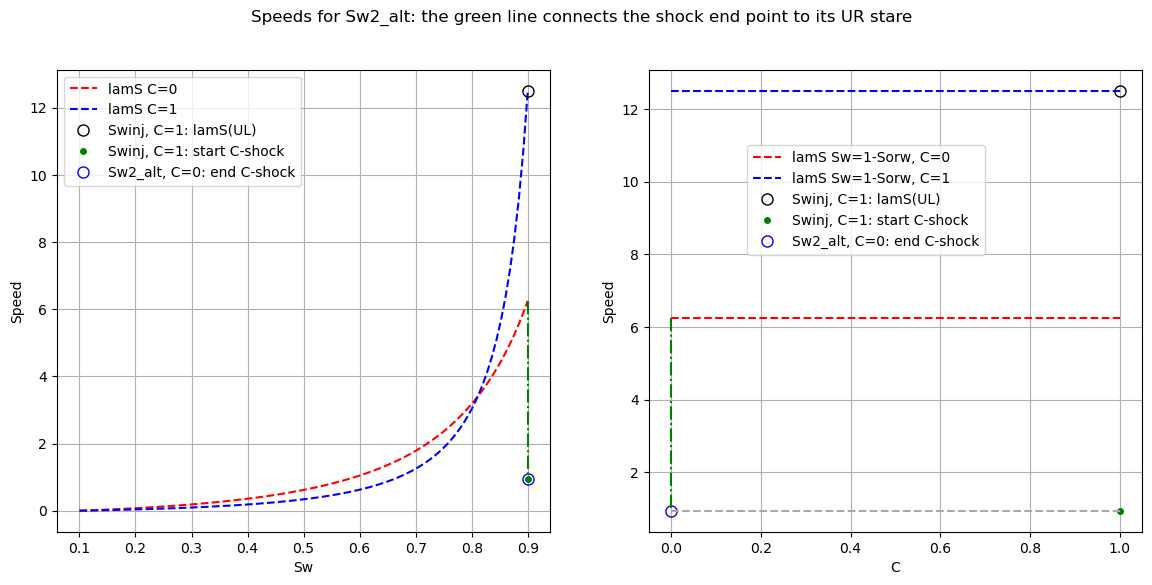

In [56]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
Ss = np.linspace(ff_no1_muo01.Scw,1.0-ff_no1_muo01.Sorw,101)

fig.suptitle('Speeds for Sw2_alt: the green line connects the shock end point to its UR stare')

ax[0].plot(Ss, ff_no1_muo01.lamS(Ss,0), 'r--', label='lamS C=0')
ax[0].plot(Ss, ff_no1_muo01.lamS(Ss,1), 'b--', label='lamS C=1')

ax[0].plot(1-ff_no1_muo01.Sorw,ff_no1_muo01.lamS(1-ff_no1_muo01.Sorw,1),'ko', markersize=8, fillstyle='none',  label='Swinj, C=1: lamS(UL)')
ax[0].plot(1-ff_no1_muo01.Sorw,ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0),'go', markersize=4, label='Swinj, C=1: start C-shock')
ax[0].plot(Sw2_alt, ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0), 'bo', markersize=8, fillstyle='none', label='Sw2_alt, C=0: end C-shock')
ax[0].plot((Sw2_alt,Sw2_alt),(ff_no1_muo01.lamS(Sw2_alt,0),ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0)), 'g-.')

ax[0].plot()
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('Speed')
ax[0].legend()
ax[0].grid()

Cs = np.linspace(ff_no1_muo01.Scw,1.0-ff_no1_muo01.Sorw,101)
ax[1].plot((0,1), (ff_no1_muo01.lamS(1-ff_no1_muo01.Sorw,0), ff_no1_muo01.lamS(1-ff_no1_muo01.Sorw,0)), 'r--', label='lamS Sw=1-Sorw, C=0')
ax[1].plot((0,1), (ff_no1_muo01.lamS(1-ff_no1_muo01.Sorw,1), ff_no1_muo01.lamS(1-ff_no1_muo01.Sorw,1)), 'b--', label='lamS Sw=1-Sorw, C=1')

ax[1].plot(1,ff_no1_muo01.lamS(1-ff_no1_muo01.Sorw,1),'ko', markersize=8, fillstyle='none',  label='Swinj, C=1: lamS(UL)')
ax[1].plot(1,ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0),'go', markersize=4, label='Swinj, C=1: start C-shock')
ax[1].plot(0, ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0), 'bo', markersize=8, fillstyle='none', label='Sw2_alt, C=0: end C-shock')
ax[1].plot((0,0),(ff_no1_muo01.lamS(Sw2_alt,0),ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0)), 'g-.')
ax[1].plot((0,1),(ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0),ff_no1_muo01.shockC_vel(C=1,Swst=Sw2_alt,Cst=0)), 'darkgrey', linestyle='dashed')

ax[1].plot()
ax[1].set_xlabel('C')
ax[1].set_ylabel('Speed')
ax[1].legend(loc=(0.2, 0.6))
ax[1].grid()

Sw1 = 1-Sorw = 0.9000
Sw2 = 0.9000
C-wave shock speed (1-Sorw,C=1)->(Sw2,C=0) = 0.9434
S-wave shock speed = 1.2500


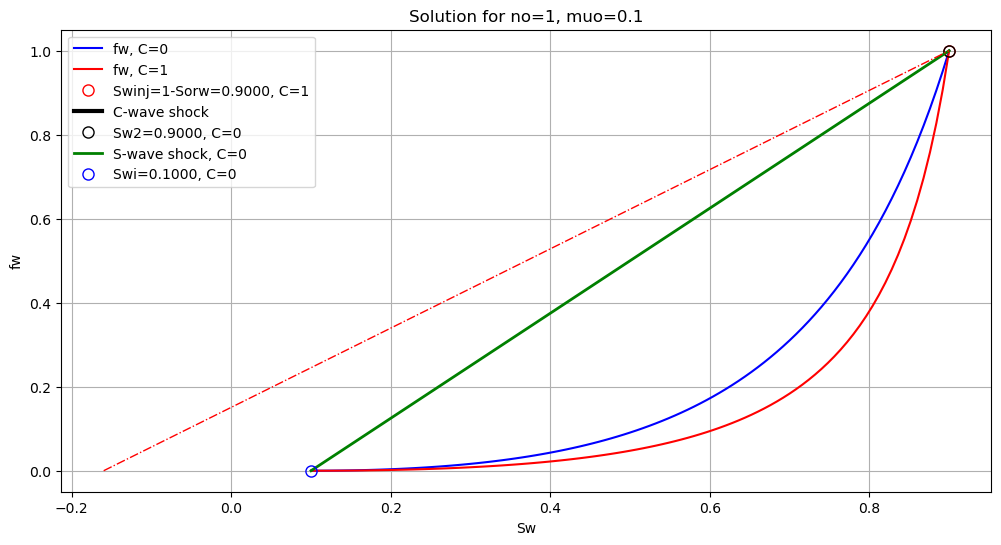

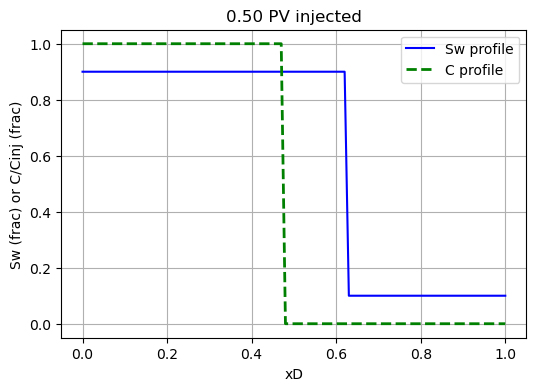

In [57]:
fig, ax = ff_no1_muo01.plot_solution()
ax.set_title('Solution for no=1, muo=0.1')
data, dataC, fig, ax = ff_no1_muo01.plot_profile(0.5)

# Examples

Various possible solutions will be demonstrated by changing the Swi value for two example parameter settings.

## Example 1

For Swi < Sw2 we find all three possible scenarios for the final 1-wave (C=0) part of the solution, viz.:
1) 1-wave shock
2) 1-wave rarefaction + 1-wave shock
3) 1-wave rarefaction

For Sw2 < Swi < Sw2_alt only the 1-wave shock is found for the final 1-wave (C=0) part of the solution.

### Input for FracFlow model

In [58]:
phi   = 0.2  # rock porosity
rho_s = 2500 # rock density in kg/m3
rho_w = 1000 # water density in kg/m3
Cinj  = 0.25 # wt% polymer in water
Cs    = 40   # adsorption on rock in micro gram / g rock
Dads = (1.0-phi)/phi * rho_s/rho_w * (Cs*1e-6)/(Cinj*0.01) # dimensionless adsorption parameter
print(f'Dads = {Dads:6.4f}')
# With the adsorption parameters below the polymer model will replicate the standard MOC solution
ad1 = 2.0*Dads
ad2 = 1.0

# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params_ex1 = { 'krwe': 1.0, 'nw': 3.0, 'Scw': 0.1,
               'kroe': 1.0, 'no': 3.0, 'Sorw': 0.1,
               'muo': 20.0, 'muw': 1.0, 'mup': 10.0,
               'ad1': ad1, 'ad2': ad2 }

ff_ex1 = pu.FracFlow(params_dict = params_ex1)

Dads = 0.1600


**Case Swi = Scw = 0.1**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave shock (C=0) from Sw2 to Swi

Swi = 0.1000, lowSwi = True
Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave shock speed = 2.5077


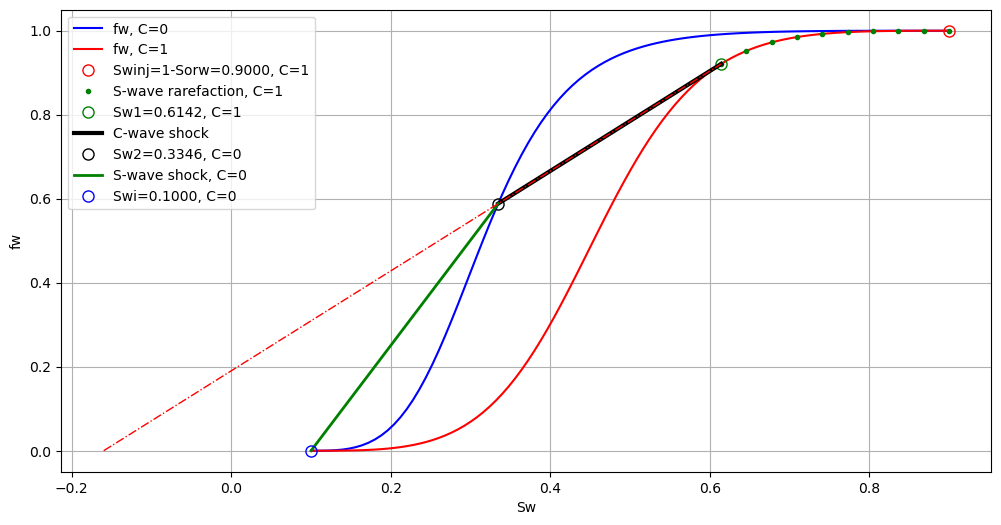

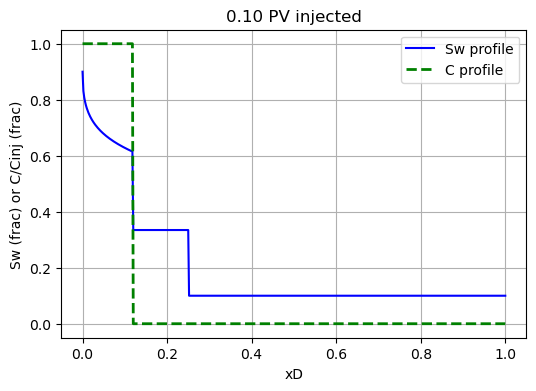

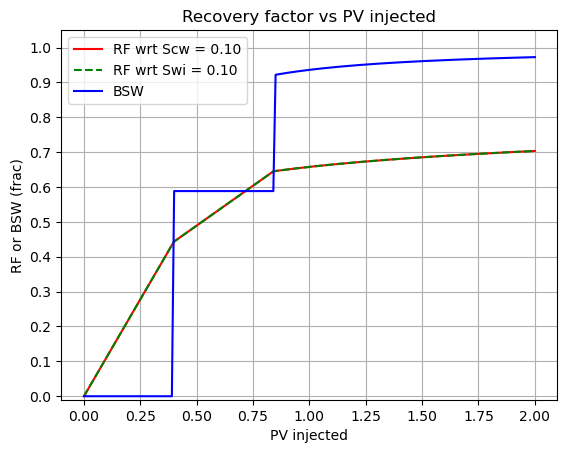

In [59]:
# For Swi=Scw it is not really required to set Swi, as this is the default
Swi, lowSwi = ff_ex1.set_Swi(ff_ex1.Scw) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()

**Case Swi = 0.25**  
Solution:  
1) 1-wave rarefaction (C=1): Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave rarefaction (C=0): Sw2 to Sw3
4) 1-wave shock (C=0): Sw3 to Swi

Swi = 0.2500, lowSwi = True
Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave rarefaction speed, back = 4.3818
Sw3 = 0.3231
S-wave rarefaction speed, front = S-wave shock speed = 4.6380


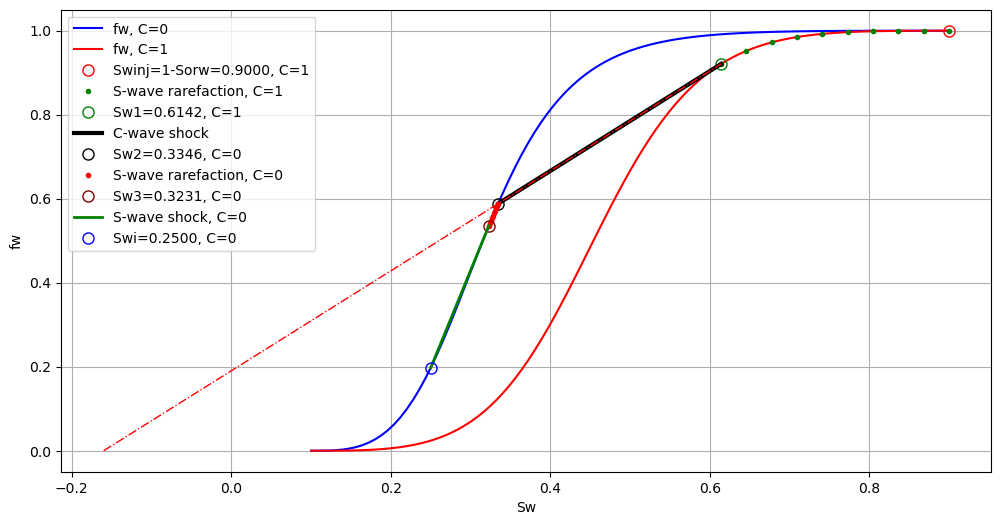

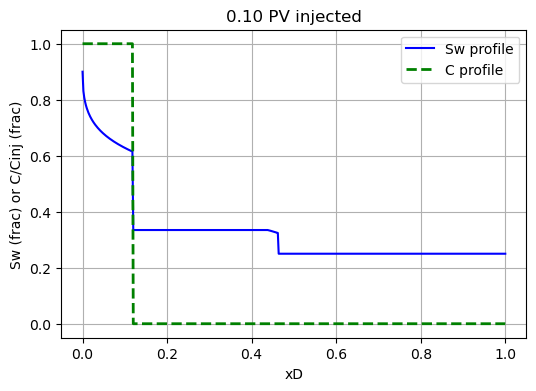

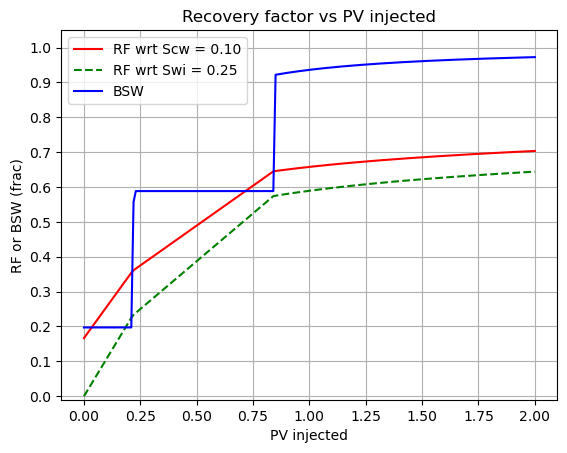

In [60]:
Swi, lowSwi = ff_ex1.set_Swi(0.25) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()


**Case Swi = 0.30**  
Solution:  
1) 1-wave rarefaction (C=1): Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave rarefaction (C=0): Sw2 to Swi

Swi = 0.3000, lowSwi = True
Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave rarefaction speed, back = 4.3818
S-wave rarefaction speed, front = 4.8891


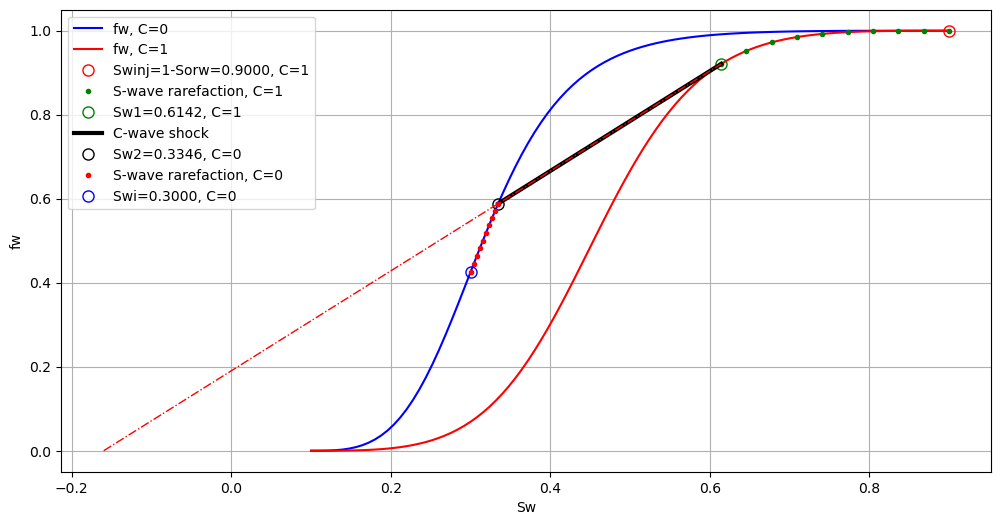

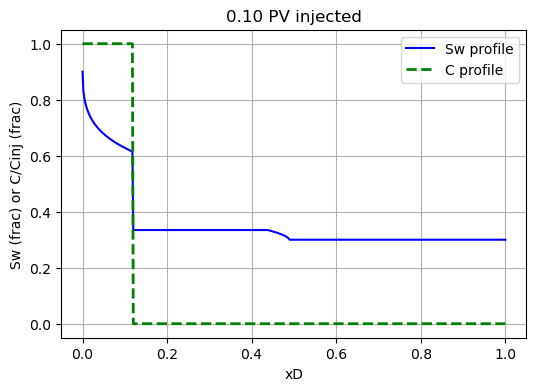

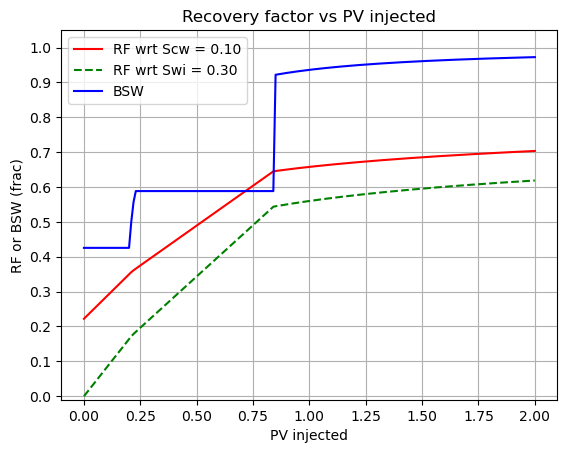

In [61]:
Swi, lowSwi = ff_ex1.set_Swi(0.30) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()

**Case Swi = Sw2 = 0.335**  
Solution:  
1) 1-wave rarefaction (C=1): Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)

Note that because Swi=Sw2, there is no need for a 1-wave rarefaction / shock (C=0) to reach Swi

Swi = 0.3346, lowSwi = True
Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave rarefaction speed, back = 4.3818
Sw3 = 0.3346
S-wave rarefaction speed, front = S-wave shock speed = 4.3818


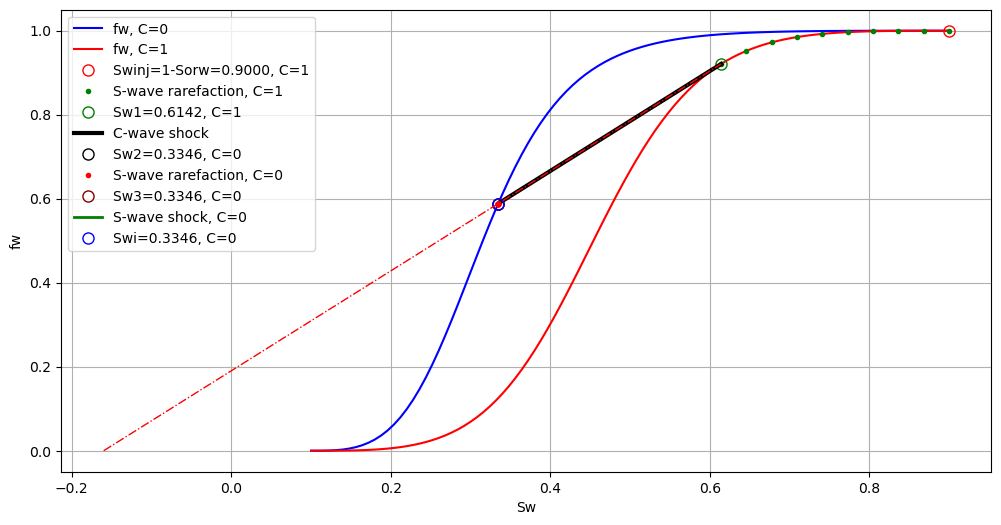

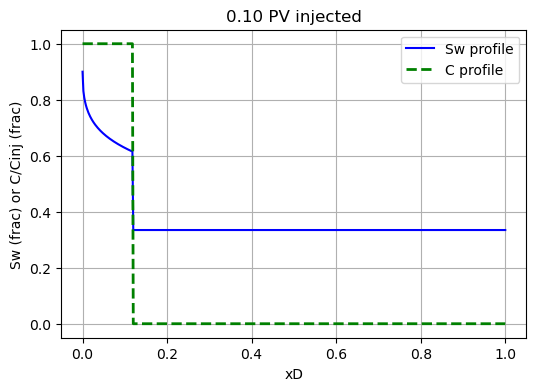

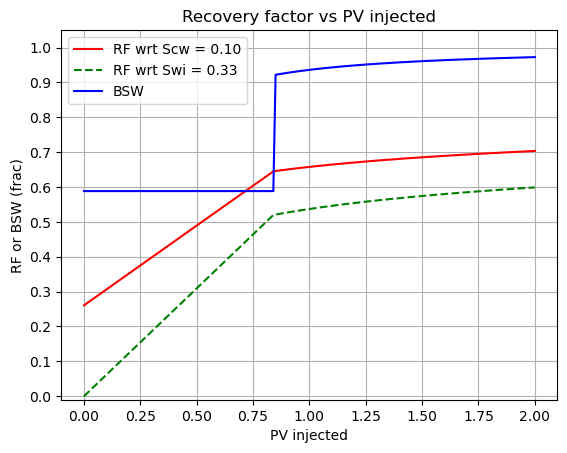

In [62]:
Swi, lowSwi = ff_ex1.set_Swi(ff_ex1.Sw2) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()

**Case Swi = 0.4**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave shock (C=0) from Sw2 to Swi

Swi = 0.4000, lowSwi = True
Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave shock speed = 3.4212


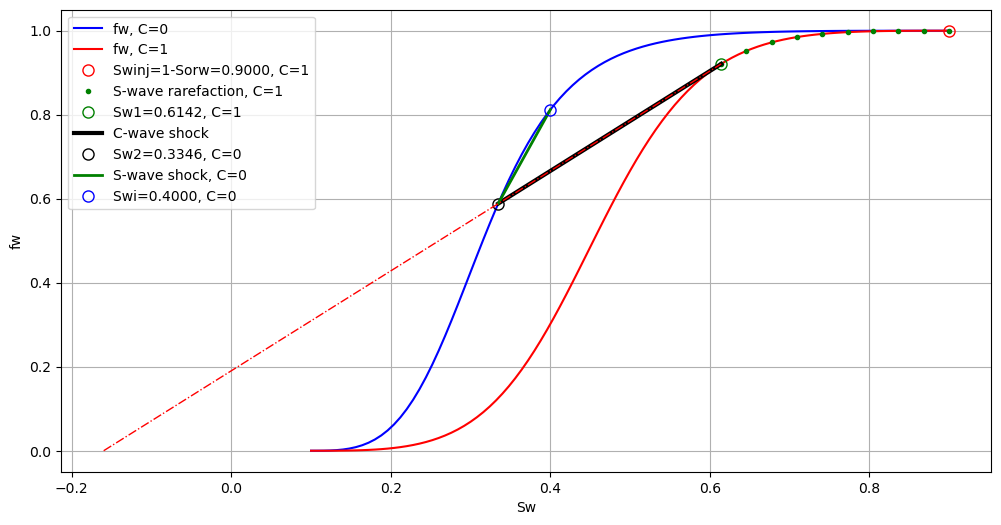

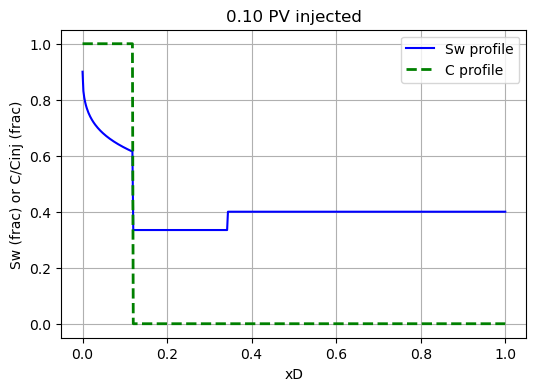

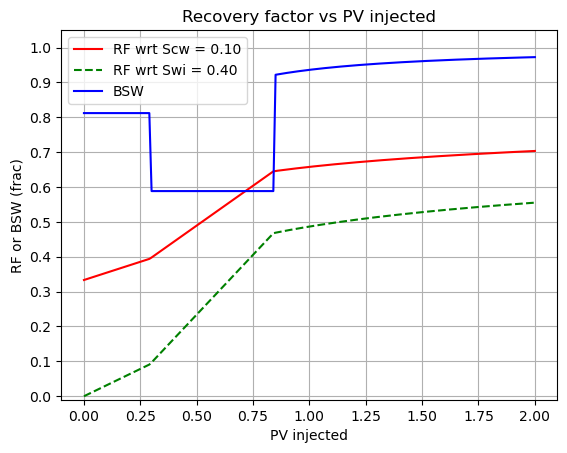

In [63]:
Swi, lowSwi = ff_ex1.set_Swi(0.40) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()

**Case Swi = Sw2_alt*0.95 = 0.644**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave shock (C=0) from Sw2 to Swi

Swi = 0.6444, lowSwi = True
Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave shock speed = 1.3122


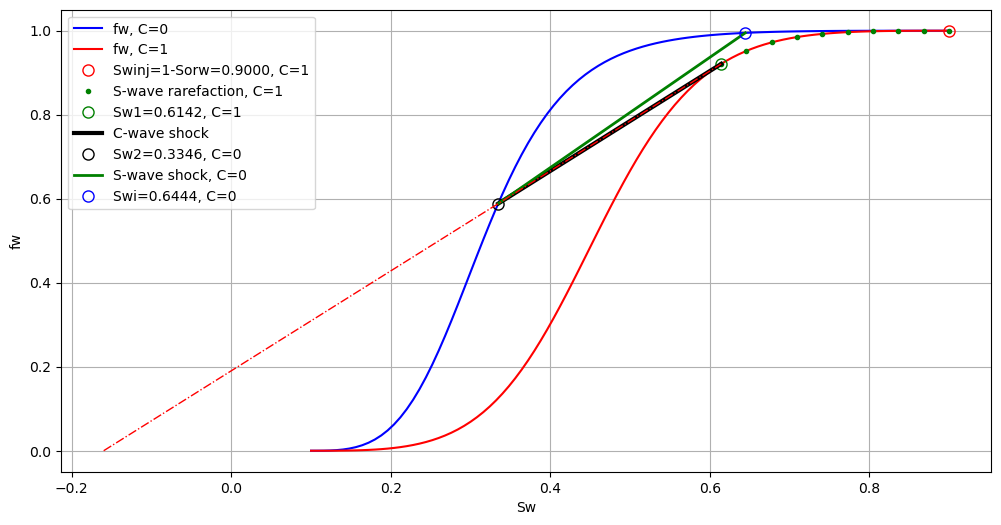

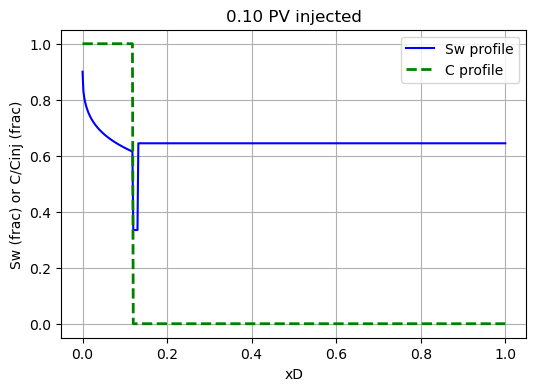

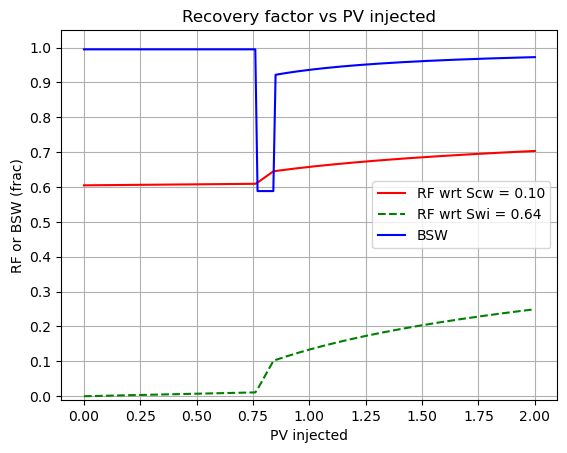

In [64]:
Swi, lowSwi = ff_ex1.set_Swi(ff_ex1.Sw2_alt*0.95) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()


**Case Swi = Sw2_alt = 0.678**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1_hi
2) 2-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Swi,C=0)

Note that for this case:
1) Sw1_hi = Sw1
2) speed of the front of the 1-wave rarefaction (C=1) matches the speed of the 2-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Swi,C=0)

Swi = 0.6783, lowSwi = False
Sw1_hi = 0.6142
lamS(Sw=Sw1_hi,C=1) = 1.1895
C-wave shock speed = 1.1895


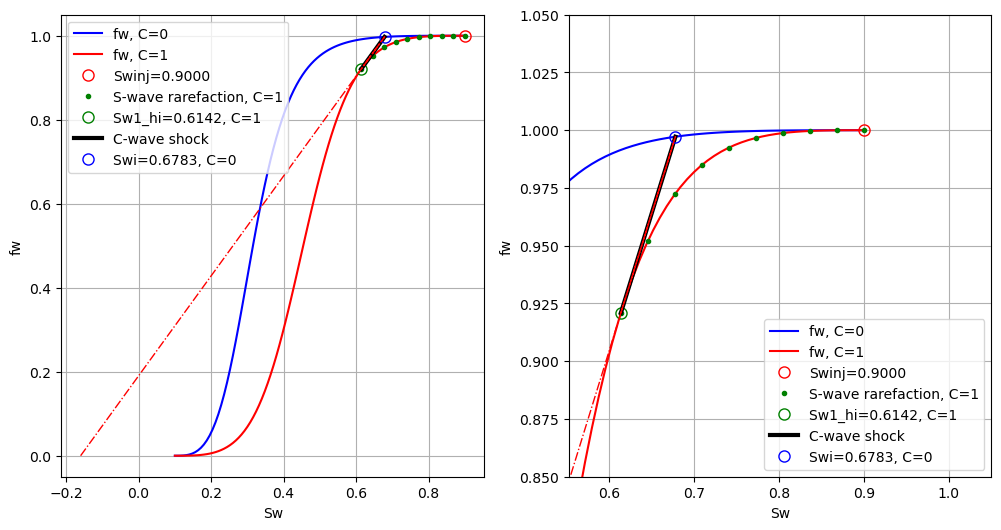

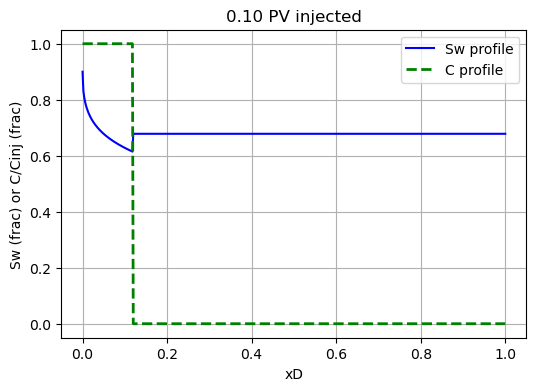

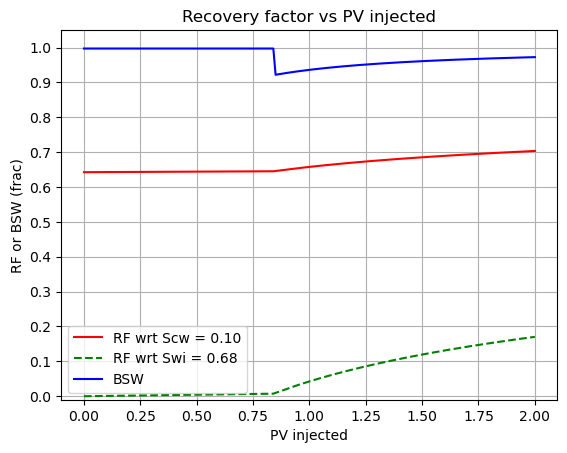

In [65]:
Swi, lowSwi = ff_ex1.set_Swi(ff_ex1.Sw2_alt) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()

**Case Swi = 0.75**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1_hi
2) 2-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Swi,C=0)

Note that the 2-wave shock is faster than the front of the 1-wave rarefaction (C=1)

Swi = 0.7200, lowSwi = False
Sw1_hi = 0.7072
lamS(Sw=Sw1_hi,C=1) = 0.3179
C-wave shock speed = 1.1350


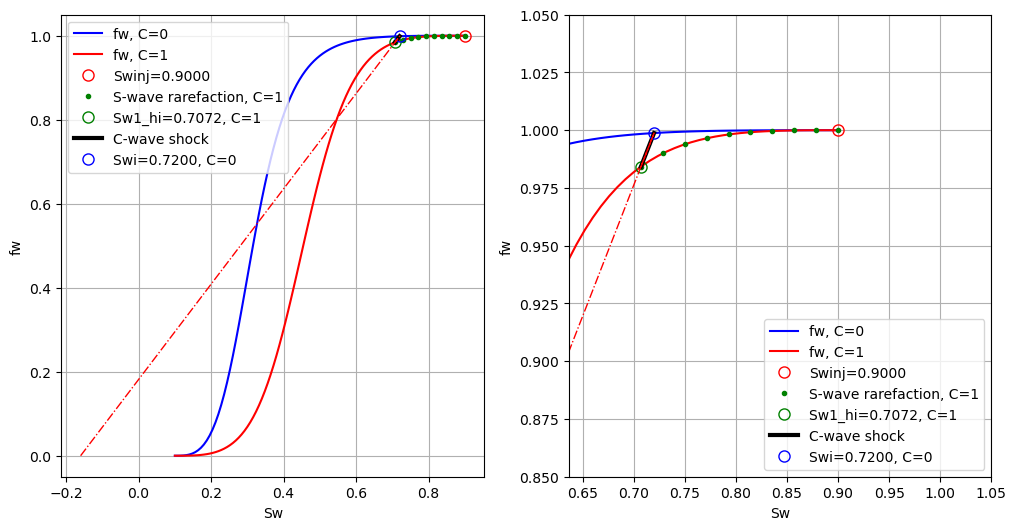

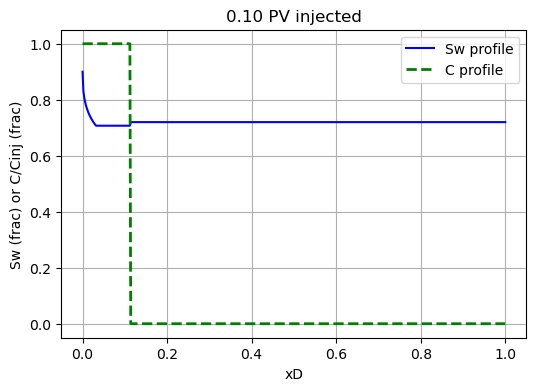

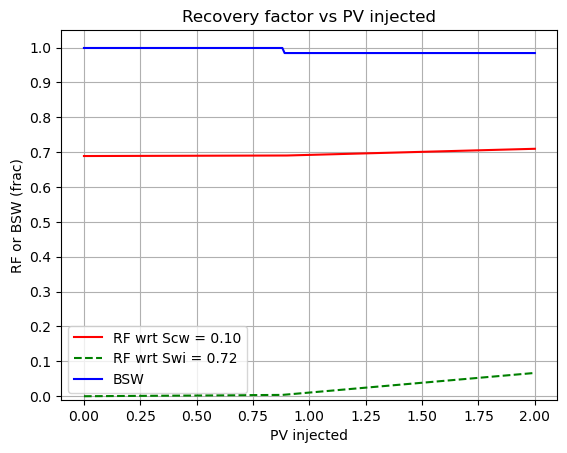

In [66]:
Swi, lowSwi = ff_ex1.set_Swi(0.72) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex1.plot_solution()
data, dataC, fig, ax = ff_ex1.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex1.plot_RF()

## Example 2

For Sw2 < Swi < Sw2_alt we find all three possible scenarios for the final 1-wave (C=0) part of the solution, viz.:
1) 1-wave shock
2) 1-wave rarefaction + 1-wave shock
3) 1-wave rarefaction

For Swi < Sw2 only the 1-wave shock is found for the final 1-wave (C=0) part of the solution.

### Input for FracFlow model

In [67]:
phi   = 0.2  # rock porosity
rho_s = 2500 # rock density in kg/m3
rho_w = 1000 # water density in kg/m3
Cinj  = 0.25 # wt% polymer in water
Cs    = 4.0    # adsorption on rock in micro gram / g rock
Dads = (1.0-phi)/phi * rho_s/rho_w * (Cs*1e-6)/(Cinj*0.01) # dimensionless adsorption parameter
print(f'Dads = {Dads:6.4f}')
# With the adsorption parameters below the polymer model will replicate the standard MOC solution
ad1 = 2.0*Dads
ad2 = 1.0

# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params_ex2 = { 'krwe': 1.0, 'nw': 3.0, 'Scw': 0.1,
               'kroe': 1.0, 'no': 3.0, 'Sorw': 0.1,
               'muo': 200.0, 'muw': 1.0, 'mup': 400.0,
               'ad1': ad1, 'ad2': ad2 }

ff_ex2 = pu.FracFlow(params_dict = params_ex2)

Dads = 0.0160


**Case Swi = Scw = 0.1**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave shock (C=0) from Sw2 to Swi

Swi = 0.1000, lowSwi = True
Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave shock speed = 3.0423


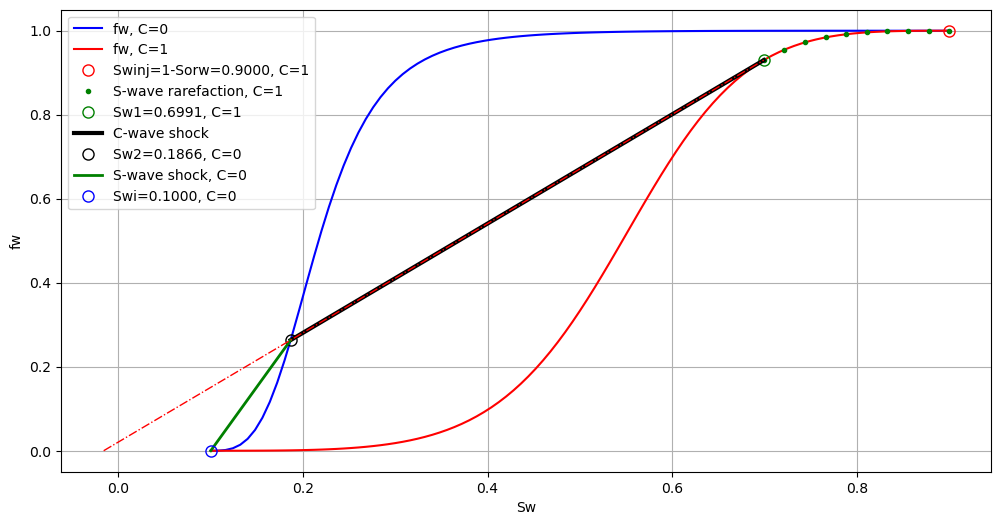

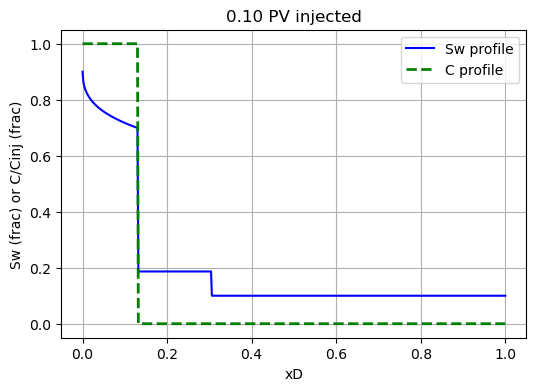

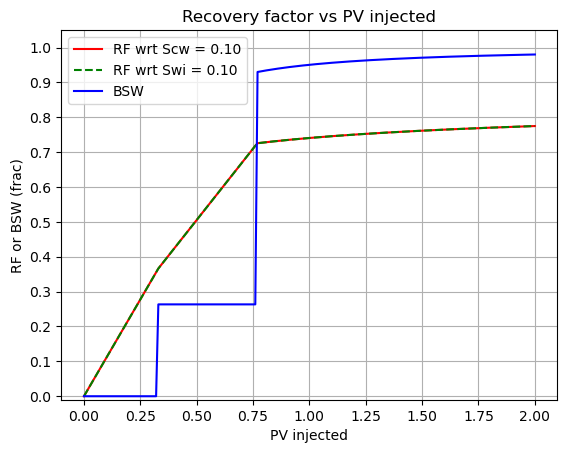

In [68]:
# For Swi=Scw it is not really required to set Swi, as this is the default
Swi, lowSwi = ff_ex2.set_Swi(ff_ex2.Scw) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

**Case Swi = Sw2=0.187**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)

Note that because Swi=Sw2, there is no need for a 1-wave rarefaction / shock (C=0) to reach Swi

Swi = 0.1866, lowSwi = True
Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave rarefaction speed, back = 7.5384
Sw3 = 0.1866
S-wave rarefaction speed, front = S-wave shock speed = 7.5384


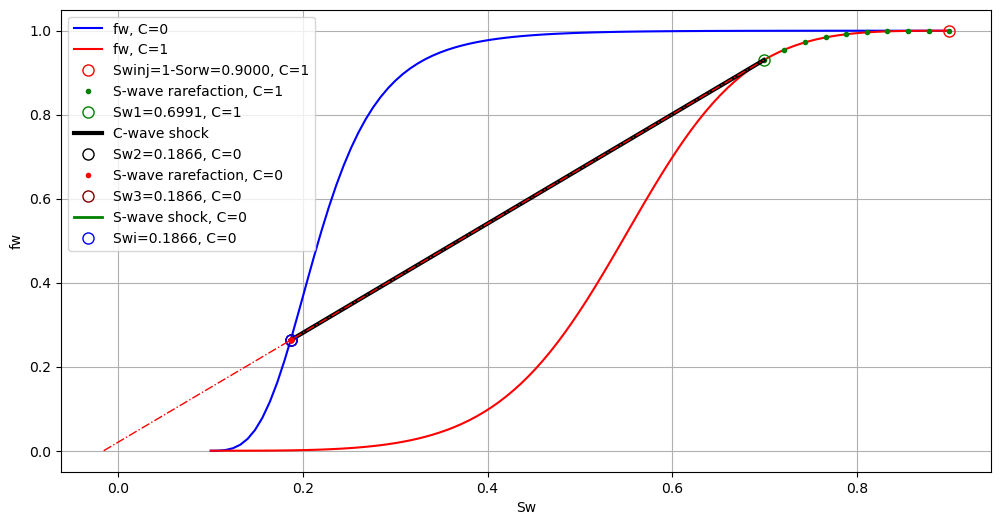

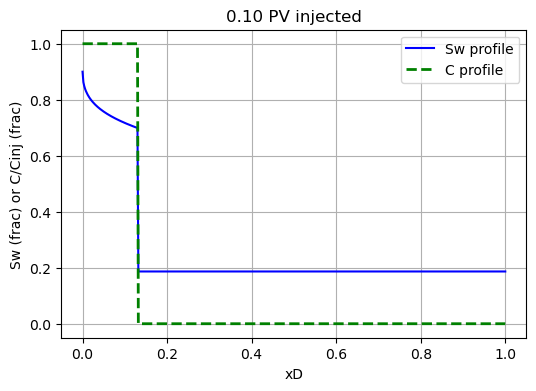

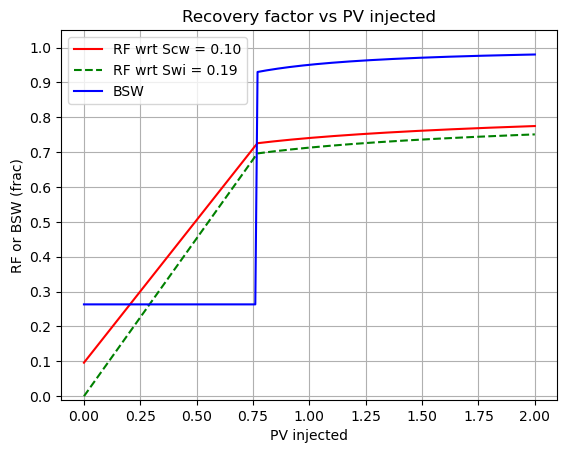

In [69]:
Swi, lowSwi = ff_ex2.set_Swi(ff_ex2.Sw2) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

**Case Swi = 0.20**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave rarefaction (C=0) from Sw2 to Swi

Swi = 0.2000, lowSwi = True
Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave rarefaction speed, back = 7.5384
S-wave rarefaction speed, front = 7.9770


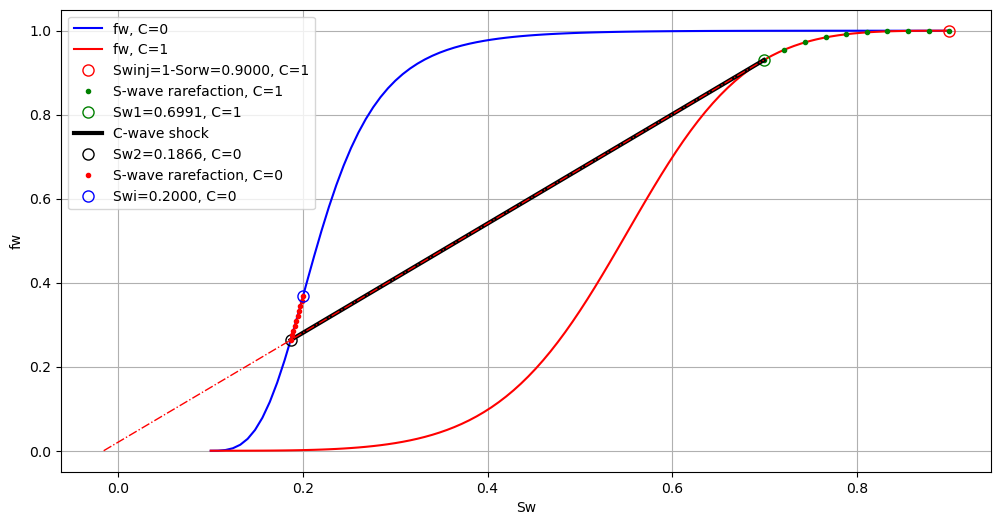

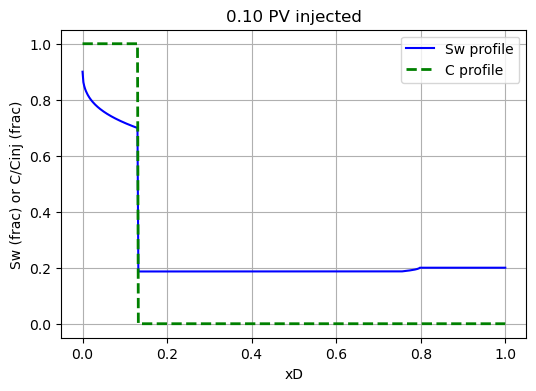

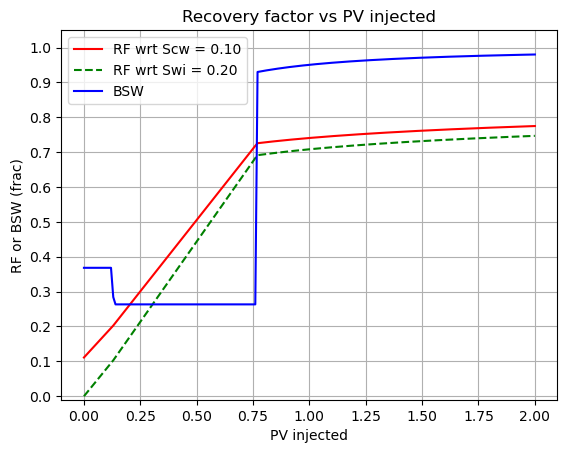

In [70]:
Swi, lowSwi = ff_ex2.set_Swi(0.2) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

**Case Swi = 0.22**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave rarefaction (C=0) from Sw2 to Sw3
4) 1-wave shock (C=0) from Sw3 to Swi

Swi = 0.2200, lowSwi = True
Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave rarefaction speed, back = 7.5384
Sw3 = 0.1919
S-wave rarefaction speed, front = S-wave shock speed = 7.8079


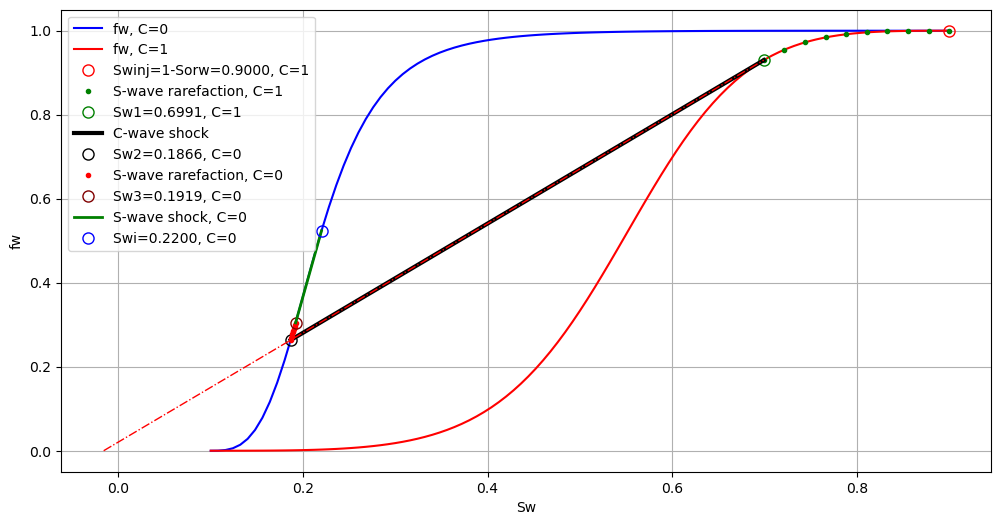

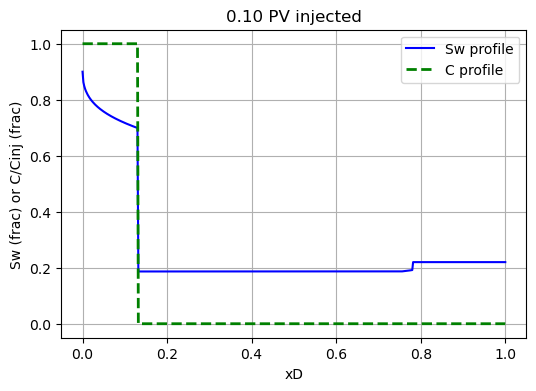

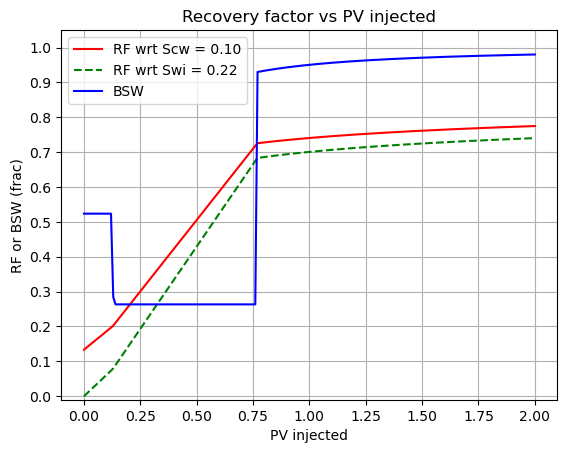

In [71]:
Swi, lowSwi = ff_ex2.set_Swi(0.22) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

**Case Swi = 0.30**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave shock (C=0) from Sw2 to Swi

Swi = 0.3000, lowSwi = True
Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave shock speed = 5.4460


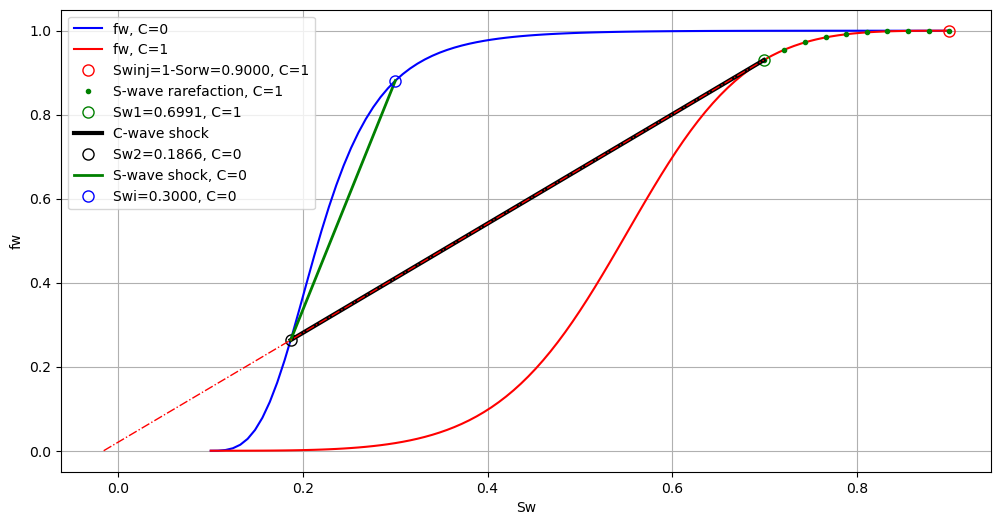

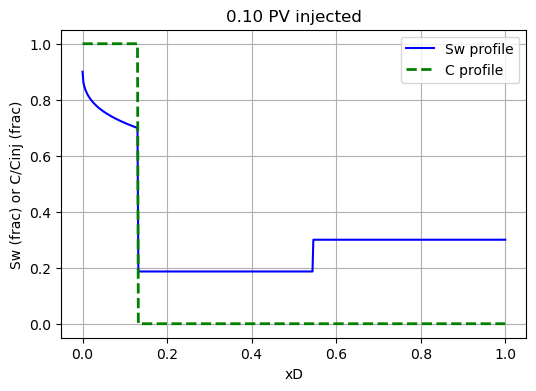

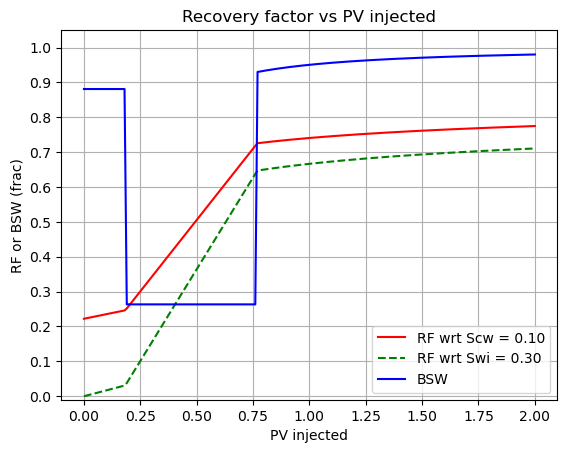

In [72]:
Swi, lowSwi = ff_ex2.set_Swi(0.3) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

**Case Swi = Sw2_alt*0.95 =0.715**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1, C=1) to (Sw=Sw2,C=0)
3) 1-wave shock (C=0) from Sw2 to Swi

Swi = 0.7153, lowSwi = True
Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave rarefaction speed, back = 7.5384
Sw3 = 0.7153
S-wave rarefaction speed, front = S-wave shock speed = 0.0029


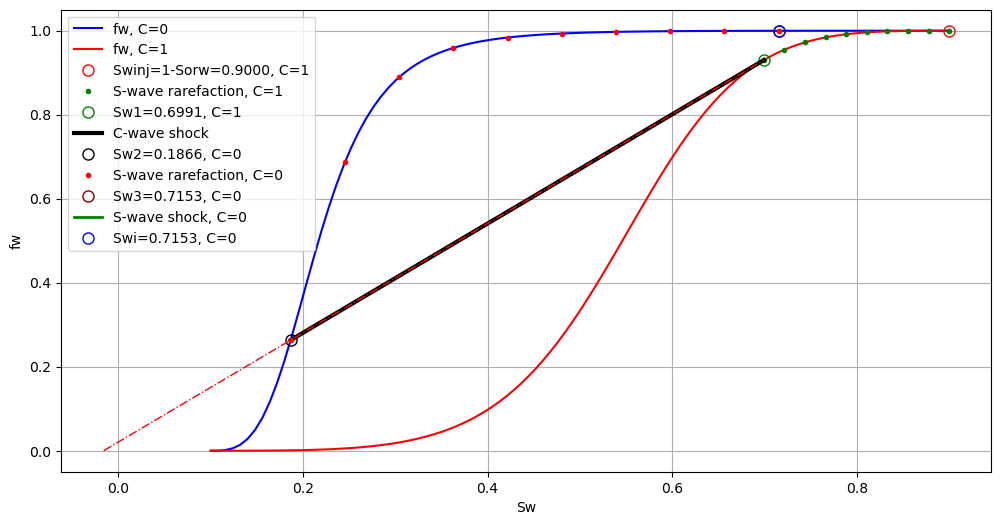

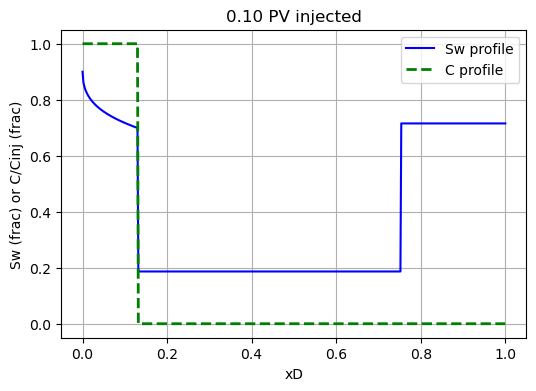

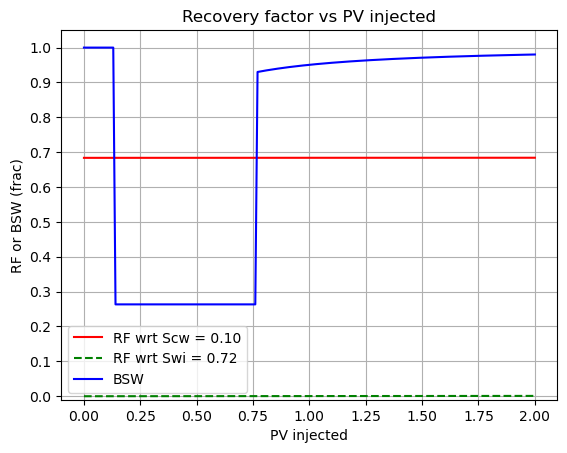

In [73]:
Swi, lowSwi = ff_ex2.set_Swi(ff_ex2.Sw2_alt*0.95) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

m**Case Swi = Sw2_alt= 0.753**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1_hi, C=1) to (Sw=Swi,C=0)

Note that for this case:
1) Sw1_hi = Sw1
2) speed of the front of the 1-wave rarefaction (C=1) matches the speed of the 2-wave shock from (Sw=Sw1_hi,C=1) to (Sw=Swi,C=0)

Swi = 0.7530, lowSwi = False
Sw1_hi = 0.6991
lamS(Sw=Sw1_hi,C=1) = 1.3003
C-wave shock speed = 1.3003


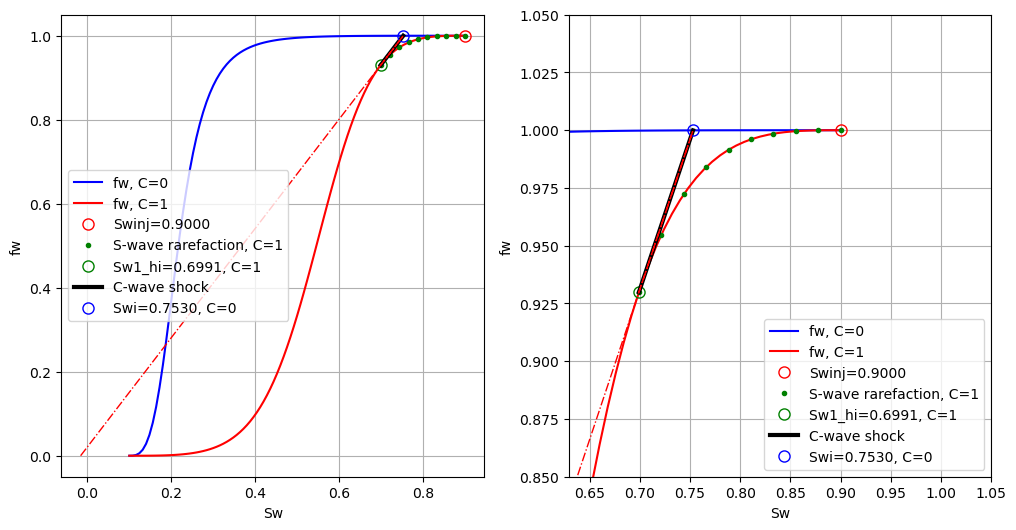

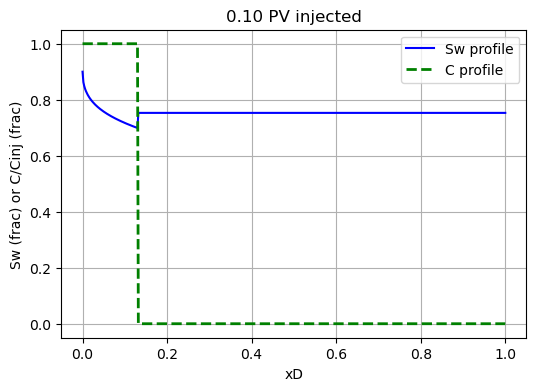

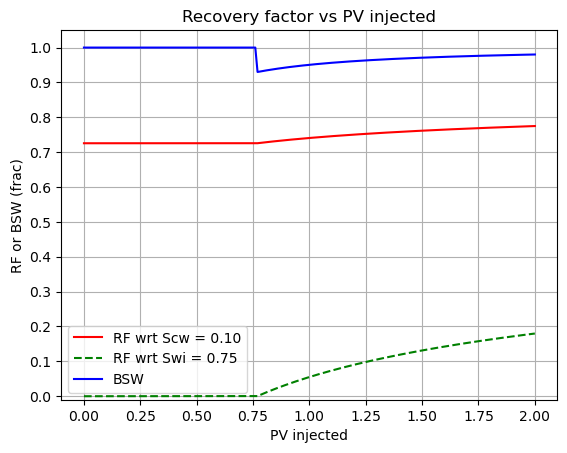

In [74]:
Swi, lowSwi = ff_ex2.set_Swi(ff_ex2.Sw2_alt) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

**Case Swi = 0.80**  
Solution:  
1) 1-wave rarefaction (C=1), Swinj to Sw1
2) 2-wave shock (Sw=Sw1_hi, C=1) to (Sw=Swi,C=0)

Note that the 2-wave shock is faster than the front of the 1-wave rarefaction (C=1)

Swi = 0.8000, lowSwi = False
Sw1_hi = 0.7943
lamS(Sw=Sw1_hi,C=1) = 0.2276
C-wave shock speed = 1.2255


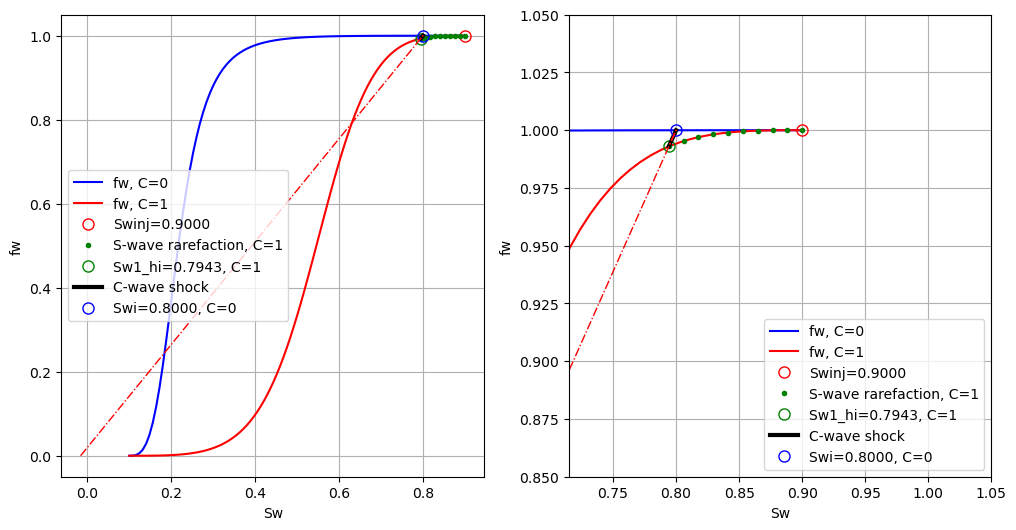

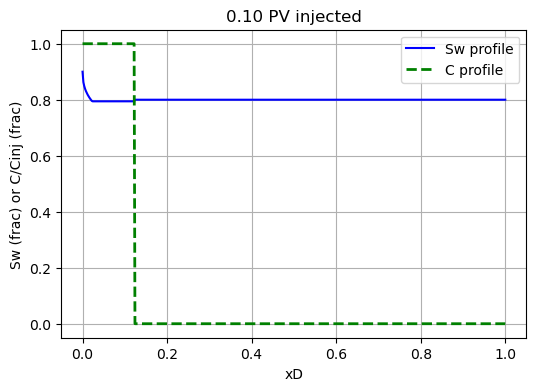

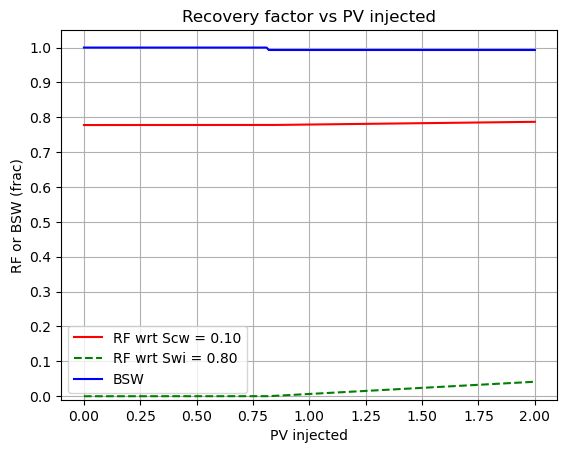

In [75]:
Swi, lowSwi = ff_ex2.set_Swi(0.8) 
print(f'Swi ={Swi: 6.4f}, lowSwi = {lowSwi}')
fig, ax = ff_ex2.plot_solution()
data, dataC, fig, ax = ff_ex2.plot_profile(0.1, ns=501)
RF_Scw, RF_Swim, BSW, fig, ax = ff_ex2.plot_RF()

# Tangent analysis

The tangent analysis works as follows:
1) check whether in the interval Swi to Sw2 a point Sw3 (inside the interval) exits, such that the straight line from Swi to Sw3 is tangent to the fractional flow curve in Sw3. This is done by checking whether a solution Sw3 exist in the interval Swi to Sw2 for the equation:
  $$
  \lambda_S(S_{w3},C=0) = \sigma_S = \dfrac{f_w(S_{w3})-f_w(S_{wi})}{S_{w3}-S_{wi}}
  $$
2) if such an Sw3 exists, the S-wave is a combination of a rarefaction from Sw2 to Sw2 followed by a shock from Sw3 to Swi
3) if such an Sw3 does not exist, we need to check whether the S-wave is a rarefaction or a shock. This depends on the value of d2fw/dSw2 between Swi and Sw2:
    * if Swi < Sw2, there is a shock from Sw2 to Swi if d2fw/dSw2 >= 0 (convex) inside the range Swi-Sw2, otherwise a rarefaction
    * if Swi > Sw2, there is a shock from Sw2 to Swi if d2fw/DSw2 <= 0 (concave) inside the range Sw2-Sw2, otherwise a rarefaction

We have a special case when no=1, nw=1 and MobWat = (krwe/muw)/(kroe/muo) = 1. Then the fractional flow is a straight line and the rarefaction and shock speeds are constant and equal to each other. We then have a contact discontinuity (which we call a shock)

In [76]:
# Plotting function for visualizing the tangent line
# Shock line has zero length if tangent is not found, as tangent_fw_Si** returns Swi in that case
def plot_tangent(Swi,Sw3, events, ff):
    def line(Sw,Swi, eps=1e-4):
        # return np.where(np.abs(S-Sr)<eps,ff.dfw_S(Sr,C=0), (ff.fw(S,C=0)-ff.fw(Sr,C=0))/(S-Sr))
        return ff.shockS_vel(Sw,Swi,Cst=0)

    fig, ax = plt.subplots(1,2,figsize=(12,5))

    Ss = np.linspace(ff.Scw,1.0-ff.Sorw,101)
    
    ax[0].plot(Ss,ff.dfw_S(Ss,C=0), 'r-', label='dfw/dS, C=0')
    ax[0].plot(Ss,line(Ss,Swi), 'b-', label='Swi to Sw Shock')
    ax[0].plot(Sw3,ff.dfw_S(Sw3,C=0), 'ro', label = 'Sw3', markersize=8, fillstyle='none')
    ax[0].plot(Swi,ff.dfw_S(Swi,C=0), 'bo', label = 'Swi', markersize=8, fillstyle='none')
    ax[0].plot(ff.Sw2,ff.dfw_S(ff.Sw2,C=0), 'go', label = 'Sw2', markersize=8, fillstyle='none')
    #ax[0].set_xlim(0.2,0.4)
    ax[0].set_ylabel('Speed')
    ax[0].set_xlabel('Sw')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(Ss,ff.fw(Ss,C=0), label='fw, C=0')
    if events=='rare + shock':
        Srare = np.linspace(Sw3,ff.Sw2,10)
        ax[1].plot(Srare,ff.fw(Srare,C=0), 'r.', lw=2, label='Tangent, Rarefaction')
        ax[1].plot((Swi,Sw3),(ff.fw(Swi,C=0),ff.fw(Sw3,C=0)), 'k--', lw=2, label='Tangent, Shock')
    elif events=='shock':
        ax[1].plot((Swi,ff.Sw2),(ff.fw(Swi,C=0),ff.fw(ff.Sw2,C=0)), 'k--', lw=2, label='No tangent, Shock')
    else:
        Srare = np.linspace(Swi,ff.Sw2,10)
        ax[1].plot(Srare,ff.fw(Srare,C=0), 'r.', lw=2, label='No tangent, Rarefaction')
    ax[1].plot(Sw3,ff.fw(Sw3,C=0), 'ro', label = 'Sw3', markersize=8, fillstyle='none')
    ax[1].plot(Swi,ff.fw(Swi,C=0), 'bo', label = 'Swi', markersize=8, fillstyle='none')
    ax[1].plot(ff.Sw2,ff.fw(ff.Sw2,C=0), 'go', label = 'Sw2', markersize=8, fillstyle='none')
    ax[1].set_ylabel('fw')
    ax[1].set_xlabel('Sw')
    ax[1].legend()
    ax[1].grid()
    return fig, ax

# Set eps values used in the calculations below
eps_Sw3 = 1e-8
epsSvel = 1e-8

## Tangent lines for example 1

Sw2  = 0.3346
Swi  = 0.10000000
Sw3     = 0.10000000, events =  shock


Sw1 = 0.6142
Sw2 = 0.3346
lamS(Sw=Sw1,C=1) = 1.1895
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.1895
S-wave shock speed = 2.5077


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

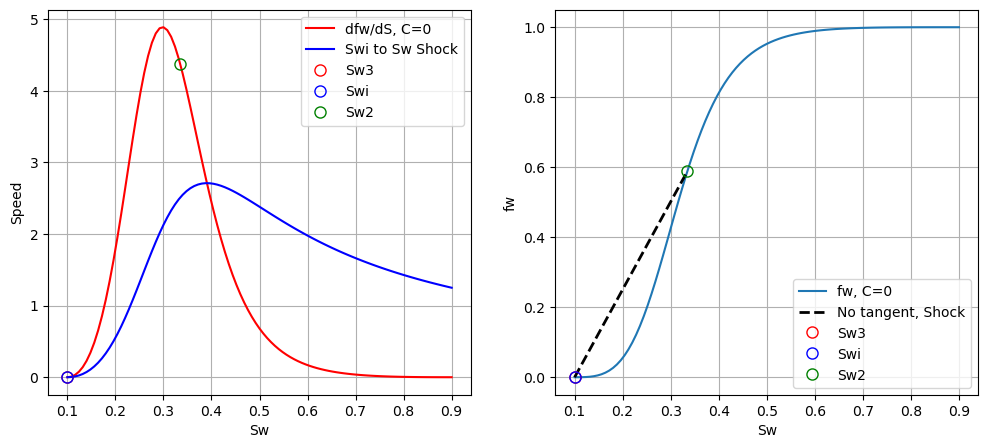

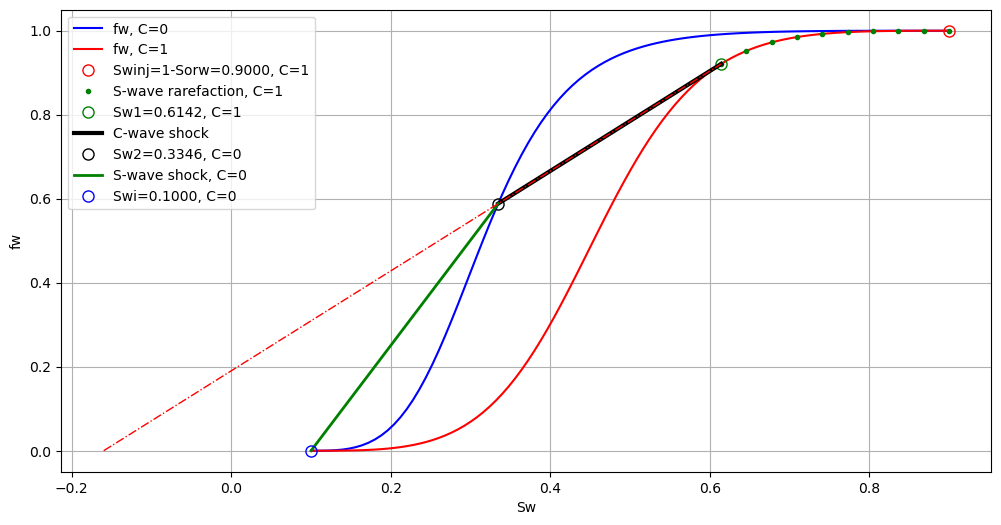

In [77]:
Swi = ff_ex1.Scw # =0.1 shock
# Swi = 0.230      # end pure shock
# Swi = 0.235      # rarefaction + shock
# Swi = 0.296      # end rarefaction + shock
# Swi = 0.310      # rarefaction
# Swi = ff_ex1.Sw2 # = 0.335 switch from rarefaction to shock
# Swi = 0.400      # shock

Sw3, events = ff_ex1.events_Swave(ff_ex1.Sw2,Swi,eps_Sw3, epsSvel)

plot_tangent(Swi, Sw3, events, ff_ex1)

print(f'Sw2  = {ff_ex1.Sw2:6.4f}')
print(f'Swi  = {Swi:.8f}')
print(f'Sw3     = {Sw3:.8f}, events = ', events )
print('\n')
ff_ex1.set_Swi(Swi)
ff_ex1.plot_solution()

## Tangent lines for example 2

Sw2  = 0.1866
Swi  = 0.10000000
Sw3     = 0.10000000, events =  shock


Sw1 = 0.6991
Sw2 = 0.1866
lamS(Sw=Sw1,C=1) = 1.3003
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.3003
S-wave shock speed = 3.0423


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

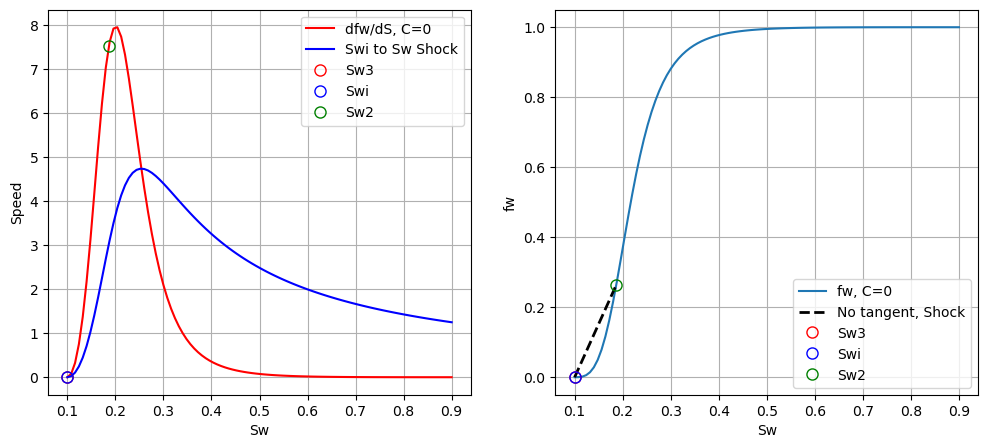

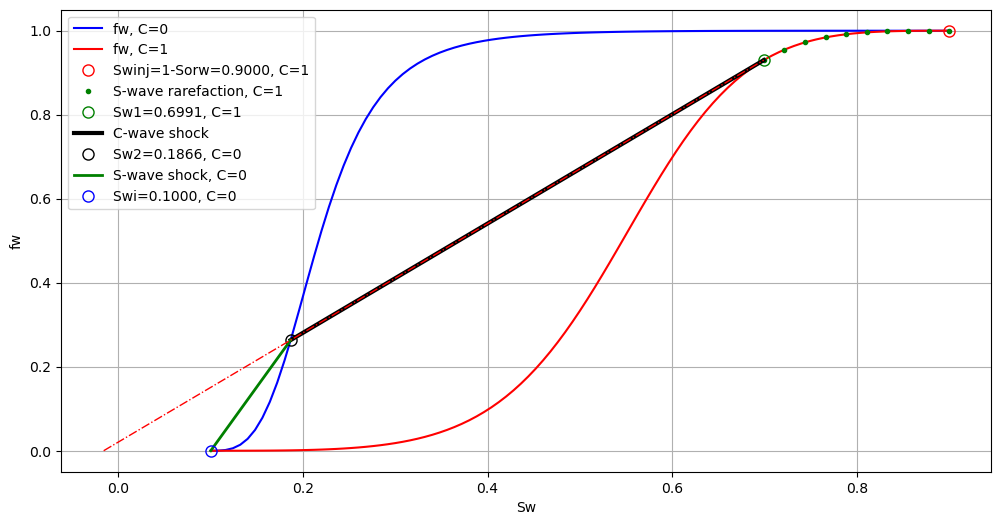

In [78]:
Swi = ff_ex2.Scw  # = 0.1 shock
# Swi = ff_ex2.Sw2  # = 0.187 end shock
# Swi = 0.190       # rarefaction
# Swi = 0.201       # end rarefaction
# Swi = 0.210       # rarefaction + shock
# Swi = 0.229       # end rarefaction + shock
# Swi = 0.232       # shock
# Swi = 0.24        # shock

Sw3, events = ff_ex2.events_Swave(ff_ex2.Sw2,Swi,eps_Sw3, epsSvel)

plot_tangent(Swi, Sw3, events, ff_ex2)

print(f'Sw2  = {ff_ex2.Sw2:6.4f}')
print(f'Swi  = {Swi:.8f}')
print(f'Sw3     = {Sw3:.8f}, events = ', events )
print('\n')
ff_ex2.set_Swi(Swi)
ff_ex2.plot_solution()

## Checking on tangent code for no=1

Sw2  = 0.9000
Swi  = 0.10000000
Sw3     = 0.10000000, events =  shock


Sw1 = 1-Sorw = 0.9000
Sw2 = 0.9000
C-wave shock speed (1-Sorw,C=1)->(Sw2,C=0) = 0.9434
S-wave shock speed = 1.2500


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

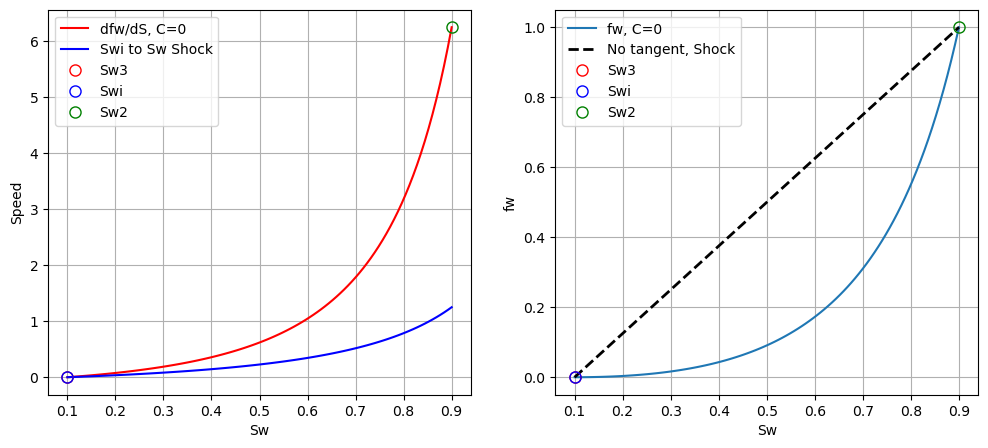

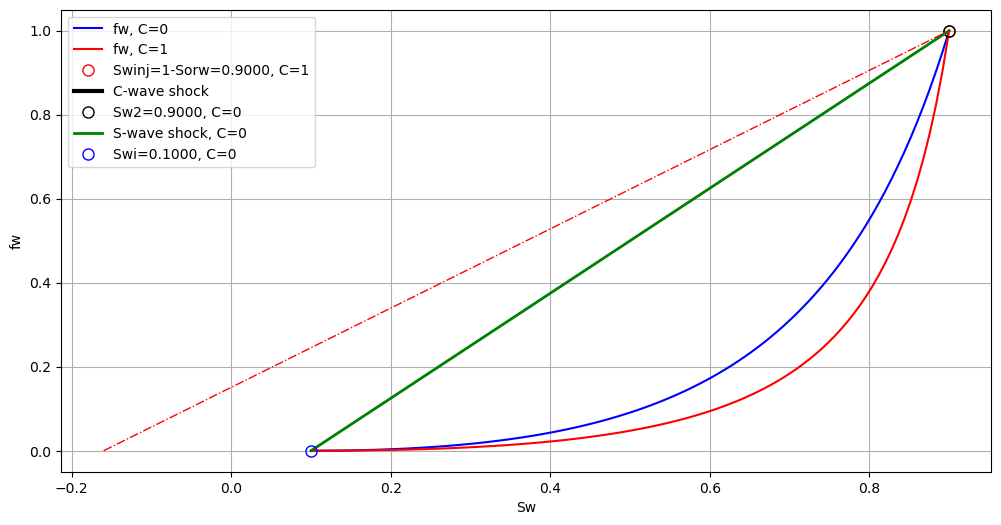

In [79]:
Swi = ff_no1_muo01.Scw # =0.1 shock despite no tangent line
# Swi = 0.5 # shock

Sw3, events = ff_no1_muo01.events_Swave(ff_no1_muo01.Sw2,Swi,eps_Sw3, epsSvel)

plot_tangent(Swi, Sw3, events, ff_no1_muo01)

print(f'Sw2  = {ff_no1_muo01.Sw2:6.4f}')
print(f'Swi  = {Swi:.8f}')
print(f'Sw3     = {Sw3:.8f}, events = ', events )
print('\n')
ff_no1_muo01.set_Swi(Swi)
ff_no1_muo01.plot_solution()

## Checking tangent code for nw=1

Sw2  = 0.3178
Swi  = 0.10000000
Sw3     = 0.10000000, events =  shock


Sw1 = 0.7366
Sw2 = 0.3178
lamS(Sw=Sw1,C=1) = 1.2402
C-wave shock speed (Sw1,C=1)->(Sw2,C=0) = 1.2402
S-wave shock speed = 1.9007


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

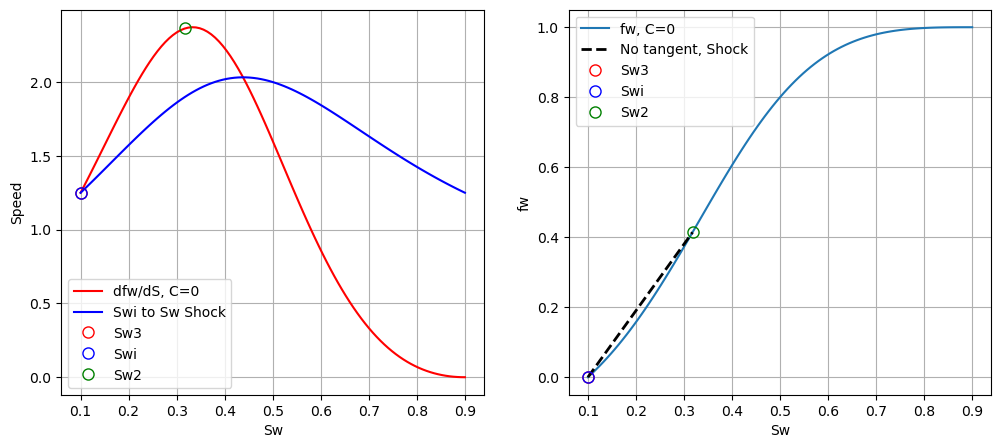

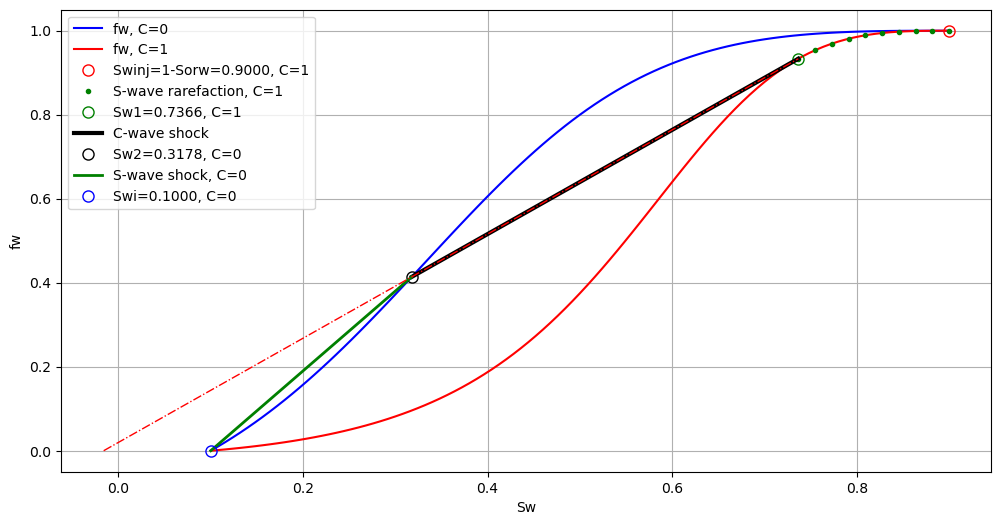

In [80]:
# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params_nw1 = { 'krwe': 1.0, 'nw': 1.0, 'Scw': 0.1,
               'kroe': 1.0, 'no': 3.0, 'Sorw': 0.1,
               'muo':  3, 'muw': 3., 'mup': 20.0,
               'ad1': ad1, 'ad2': ad2 }

ff_nw1 = pu.FracFlow(params_dict = params_nw1)

Swi = ff_nw1.Scw # =0.1 shock
# Swi = 0.2  # shock
# Swi = 0.3  # rarefaction shock
# Swi = 0.35 # rarefaction
# Swi = 0.4  # shock
# Swi = ff_nw1.Sw2 +  0.10 # = 0.482 shock
# Swi = 0.7  # shock

Sw3, events = ff_nw1.events_Swave(ff_nw1.Sw2,Swi, eps_Sw3, epsSvel)

plot_tangent(Swi, Sw3, events, ff_nw1)

print(f'Sw2  = {ff_nw1.Sw2:6.4f}')
print(f'Swi  = {Swi:.8f}')
print(f'Sw3     = {Sw3:.8f}, events = ', events )
print('\n')
ff_nw1.set_Swi(Swi)
ff_nw1.plot_solution()

## no=1, nw=1 & MobWat =1: contact discontinuity for all Swi

Sw2  = 0.9000
Swi  = 0.10000000
Sw3     = 0.10000000, events =  shock


Sw1 = 1-Sorw = 0.9000
Sw2 = 0.9000
C-wave shock speed (1-Sorw,C=1)->(Sw2,C=0) = 1.0917
S-wave shock speed = 1.2500


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Sw', ylabel='fw'>)

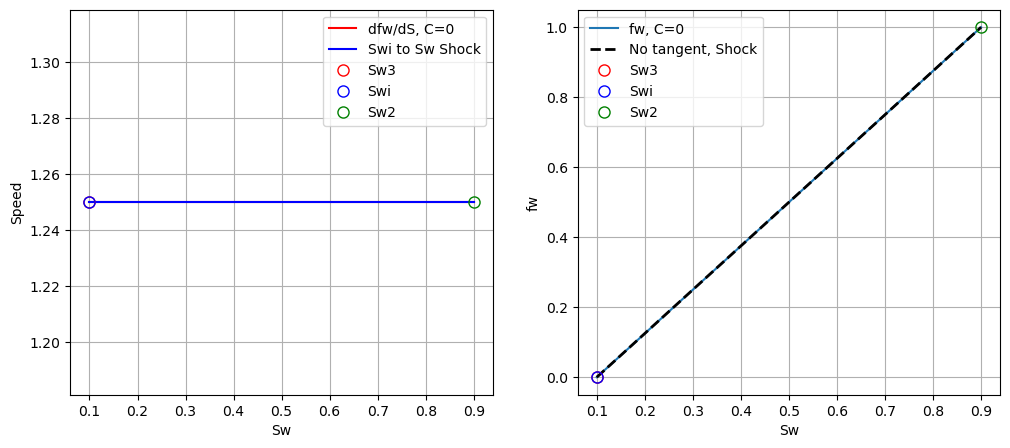

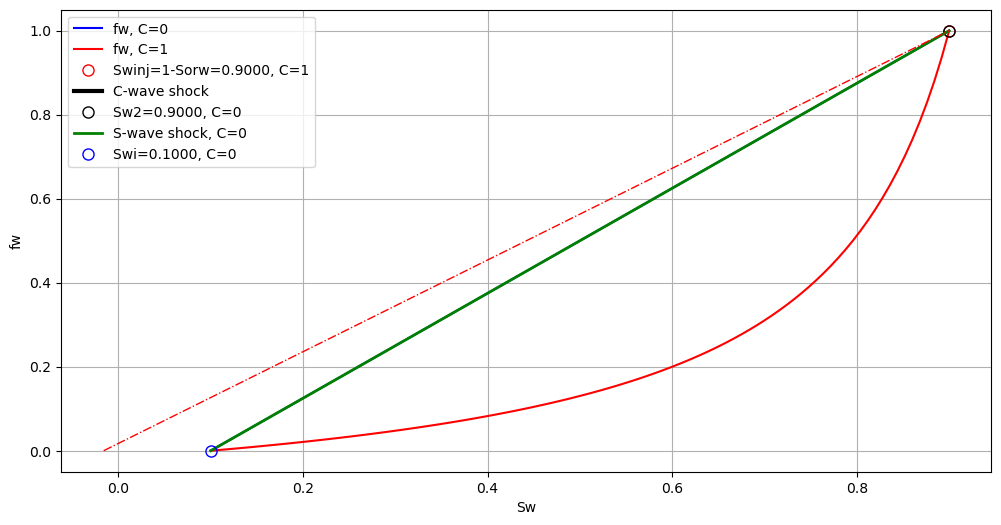

In [81]:
# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params_no1_nw1_Mob1 = { 'krwe': 1.0, 'nw': 1.0, 'Scw': 0.1,
                        'kroe': 1.0, 'no': 1.0, 'Sorw': 0.1,
                        'muo':  3, 'muw': 3., 'mup': 20.0,
                        'ad1': ad1, 'ad2': ad2 }

ff_no1_nw1_Mob1 = pu.FracFlow(params_dict = params_no1_nw1_Mob1)

Swi = ff_no1_nw1_Mob1.Scw # =0.1 shock
# Swi = 0.40 # = 0.40 shock
# Swi = 0.50 # = 0.50 shock
# Swi = 0.70 # = 0.70 shock

Sw3, events = ff_no1_nw1_Mob1.events_Swave(ff_no1_nw1_Mob1.Sw2,Swi, eps_Sw3, epsSvel)

plot_tangent(Swi, Sw3, events, ff_no1_nw1_Mob1)

print(f'Sw2  = {ff_no1_nw1_Mob1.Sw2:6.4f}')
print(f'Swi  = {Swi:.8f}')
print(f'Sw3     = {Sw3:.8f}, events = ', events )
print('\n')
ff_no1_nw1_Mob1.set_Swi(Swi)
ff_no1_nw1_Mob1.plot_solution()

#  Checking the S-wave rarefaction: alternative solution

The S-wave rarefaction solution can be obtained in two ways:
1) Inverting the relation 
   $$
   \xi = \dfrac{x_D}{t_D} = \dfrac{\partial f_w}{\partial S_w}\left(S_w(\xi)\right)
   $$. 
   This is done in the method **ff.rare_1wave**
2) Solving the ordinary differential equation:
   $$
   \dfrac{d S_w}{d \xi} \left( \xi \right) = \left. 1 \middle/  \dfrac{\partial^2 f_w}{\partial S_w^2}\left( S_w(\xi),C=constant\right) \right.
   $$

We test the equivalence of these solutions

In [82]:
# Intialise the FracFlow model
ff.set_Swi(0.1)
# Calculate the boundaries of the S-wave on the C=1 integral curve between Sw=1-Sorw and Sw=Sw1
ksi1= ff.lamS(1.0-ff.Sorw,C=1.0); ksi2=ff.lamS(ff.Sw1,C=1.0)
ksi1, ksi2

(0.0, 1.189530017199089)

In [83]:
# Determine the S-wave rarefaction using method 1 described above
ksis = np.linspace(ksi1,ksi2,101)
rare = ff.rare_Swave(ksis, Czero=False,Sl=1.0-ff.Sorw,Sr=ff.Sw1)

In [84]:
# Set up the ordinary differential equation for the rarefaction wave (method 2)
# eps is required to avoid numerical issues at the ksi1 boundary (Sw=1-Sorw: the second derivative of fw wrt Sw is zero)
eps = 1e-5
ksis1 = np.linspace(ksi2,ksi1+eps,101)

def ode(x,ksi,C):
    S = x
    dS_dksi = 1.0/ff.dfw_S2(S,C)
    return dS_dksi

x0 = ff.Sw1
C=1
Srare = odeint(ode,x0,ksis1,args=(C,),full_output=0)

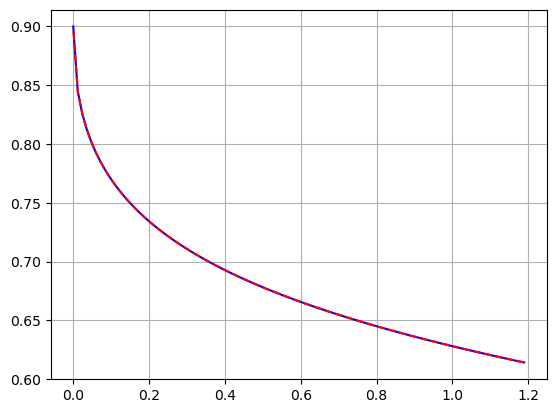

In [85]:
# Compare the two results: they match
plt.plot(ksis,rare, 'b-')
plt.plot(ksis1,Srare.T[0],'r--')
plt.grid()

# Analysis of speed structure and entropy condition for C-wave shock

Dads = 0.1600


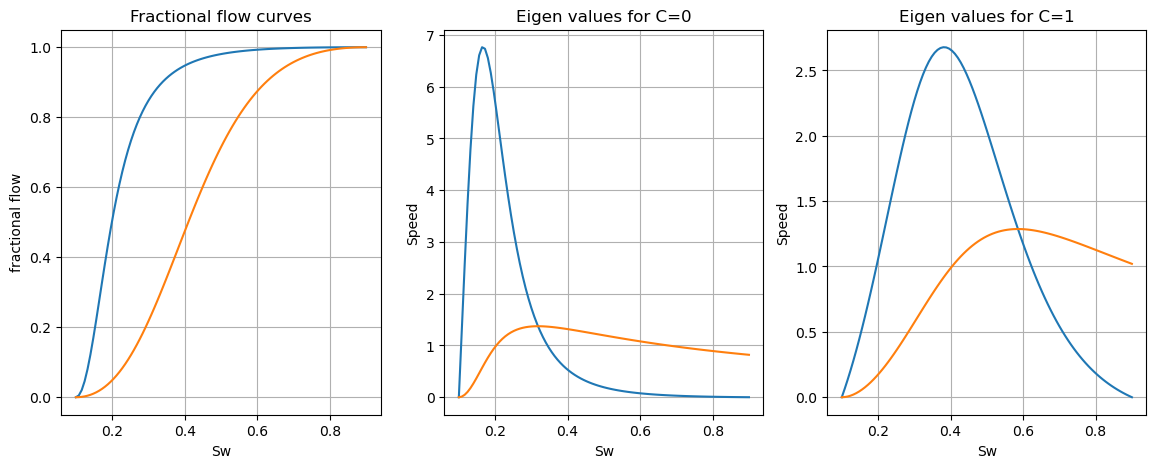

No intersection found


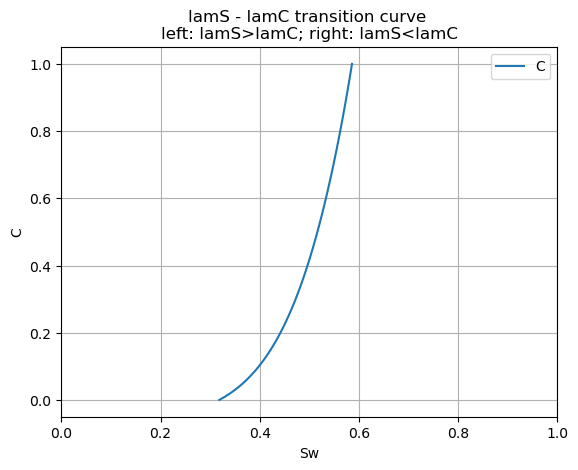

In [86]:
phi   = 0.2  # rock porosity
rho_s = 2500 # rock density in kg/m3
rho_w = 1000 # water density in kg/m3
Cinj  = 0.25 # wt% polymer in water
Cs    = 40   # adsorption on rock in micro gram / g rock
Dads = (1.0-phi)/phi * rho_s/rho_w * (Cs*1e-6)/(Cinj*0.01) # dimensionless adsorption parameter
print(f'Dads = {Dads:6.4f}')
# With the adsorption parameters below the polymer model will replicate the standard MOC solution
ad1 = 2.0*Dads
ad2 = 1.0

# The viscosities are input in cP. However, the model is independent of the unit, as long as all the
# viscosities are specified in the same unit.
params_ana = { 'krwe': 1.0, 'nw': 2.0, 'Scw': 0.1,
               'kroe': 1.0, 'no': 2.0, 'Sorw': 0.1,
               'muo': 50.0, 'muw': 1.0, 'mup': 20.0,
               'ad1': ad1, 'ad2': ad2 }

ff_ana = pu.FracFlow(params_dict = params_ana)

Ss = np.linspace(ff_ana.Scw,1.0-ff_ana.Sorw,101)
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].plot(Ss, ff_ana.fw(Ss,0), label='C=0')
ax[0].plot(Ss, ff_ana.fw(Ss,1), label='C=1')
ax[0].set_title('Fractional flow curves')
ax[0].set_xlabel('Sw')
ax[0].set_ylabel('fractional flow')
ax[0].grid()
ax[1].plot(Ss,ff_ana.lamS(Ss,0), label='lamS')
ax[1].plot(Ss,ff_ana.lamC(Ss,0), label='lamC')
ax[1].set_title('Eigen values for C=0')
ax[1].set_xlabel('Sw')
ax[1].set_ylabel('Speed')
ax[1].grid()
ax[2].plot(Ss,ff_ana.lamS(Ss,1), label='lamS')
ax[2].plot(Ss,ff_ana.lamC(Ss,1), label='lamC')
ax[2].set_title('Eigen values for C=1')
ax[2].set_xlabel('Sw')
ax[2].set_ylabel('Speed')
ax[2].grid()
plt.show()

# Check whether the lam1 = lam2 curve crosses S2 = 1-Sorw for 0<=C<=1
try:
    Cmax = brentq(lambda C: ff_ana.lamS_eq_lamC(Sw=1.0-ff_ana.Sorw,C=C), 0.0, 1.0)
except ValueError as e:
    print('No intersection found')
    Cmax = 1.0


eps_S = 1e-8
Cs = np.linspace(0,1,101)
T = pd.Series(name='Sw')
for C in Cs:
    T[C] = brentq(lambda Sw: ff_ana.lamS_eq_lamC(Sw=Sw,C=C), ff_ana.Scw+eps_S, 1.0-ff_ana.Sorw)
T = T.to_frame().reset_index(names='C')

fig, ax = plt.subplots()
T.plot(x='Sw', y='C', ax=ax)
ax.set_title('lamS - lamC transition curve \nleft: lamS>lamC; right: lamS<lamC') 
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_xlim(0,1)
ax.grid()




## Entropy condition / admissible shocks
Following paper by Johansen & Ragnar:

To identify the physically relevant weak solutions of the polymer equations, we consider the following perturbed system ($\epsilon>0$):
$$
\begin{cases}
 \dfrac{\partial}{\partial t_D} \left( S_w \right)+ \dfrac{\partial}{\partial x_D} \left( f_w \right)= 
 \epsilon \dfrac{\partial^2}{\partial x^2_D} \left( S_w \right)\\
 \\
 \dfrac{\partial}{\partial t_D}\left( S_w C + a \right) + \dfrac{\partial}{\partial x_D}(f_w C) = 
 \epsilon \dfrac{\partial^2}{\partial x^2_D}\left( S_w C + a \right)

\end{cases}
$$
In particular, we are interested in the travelling wave solutions of the form $u(x,t) = u((x- \sigma t) / \epsilon)$. A shock is admissible if it is a $\epsilon \rightarrow 0$ limit of such a travelling wave solution.

Johansen and Ragner show (following Smoller: Shock waves and Reaction Diffusion Equations, Chapter 24) that the above is equivalent to the condition that the following equations have a solution $(S_w(\xi),C(\xi))$ with 
$(S_w(-\infty),C(-\infty))=u^L$ and $(S_w(\infty),C(\infty))=u^R$ with $u^L$ and $u^R$ the start and end points of a shock:
$$
\begin{cases}
\dfrac{d}{d \xi}S_w = -\sigma (S_w-S_w^L) + f_w(S_w,C) - f_w(S_w^L,C^L) \\
\\
\dfrac{d}{d \xi}\left( S_w C + a(C) \right) = -\sigma \left( S_w C + a(C) - S_w^L C^L - a(C^L) \right) +
 \left( C f_w(S_w,C) - C^L f_w(S_w^L,C^L) \right)
 \end{cases}
$$

Using the Rankine-Hugoniot condition and performing the differentiation in the second equation one finds:
$$
\begin{cases}
\dfrac{d}{d \xi} S_w = f_w(S_w,C) - \sigma \left( S_w + h_L(C^R) \right) \\
\\
\left(S_w +h(C) \right) \dfrac{d}{d \xi} C = \sigma \left(C - C^L\right) \left(h_L(C^R) - h_L(C) \right)
\end{cases}
$$
where
$$
\begin{align}
\sigma & = \dfrac{f_w(S_w^L,C^L)}{S_w^L + h_L(C^R)} \\
\\
h(C) &= \dfrac{d a}{d C} \\
\\
h_L(C) &= \begin{cases}
          \dfrac{a(C)-a(C^L)}{C-C^L}  && \text{if  } C \neq C^L \\
          h(C)                        && \text{if  } C = C^L
          \end{cases}
\end{align}
$$
A number of observations can be made:
1) The Rankine-Hugoniot condition implies that $u^L=(S_w^L,C^L)$ and $u^R=(S_w^R,C^R)$ are equilibrium points of the above equation.  
2) Since $\sigma>0$ and the product
    $$
    \left( C - C^L \right) \left(h_L(C^R)-h_L(C)\right) < 0
    $$
   for $C$ strictly between $C^L$ and $C^R$ (because $\frac{da}{dC}>0$ and $\frac{d^2 a}{dC^2}<0$), we can conclude from the second equation:
    $$
    \dfrac{d}{d\xi}C < 0
    $$
    for $C$ strictly between $C^L$ and $C^R$. This implies that for an admissible shock one needs:
    $$
    C^L > C^R
    $$
    as $C(-\infty)=C^L$ and $C(\infty)=C^R$.

For further analysis we distinguish between two cases, viz.:
1) $\lambda_S(U^R) < \sigma$, indicated as $(S^R,C^R)$ in the fractional flow figure below.
2) $\lambda_S(U^R) > \sigma$, indicated as $(S^R_{alt},C^R)$ in the fractional flow figure below.

###  First scenario: $\lambda_S(U^R) < \sigma$

This scenario corresponds to $U^R = (S^R,C^R)$ in the figure below.

There are up to two possible values for $S_w^L$ that fulfill the Rankine-Hugoniot condition which we label $S_w^{L-}$ and $S_w^{L+}$ (see plot below). From the plot we also see:
$$
\begin{align}
\lambda_S(S_w^{L-},C^L) \geq \sigma \\
\\
\lambda_S(S_w^{L+},C^L) \leq \sigma
\end{align}
$$
Moreover, for any $C \in [C^R,C^L)$ we can introduce $S_w^-(C)$ and $S_w^+(C)$ such that
$$
\dfrac{f_w(S_w^-(C),C)}{S_w^-(C)+ h_L(C^R)} = \sigma = \dfrac{f_w(S_w^+(C),C)}{S_w^+(C)+ h_L(C^R)}
$$
with 
$$
\lambda_S(S_w^-(C),C) > \sigma > \lambda_S(S_w^+(C),C)
$$
From the equation for $\frac{d S_w}{d \xi}$ we see that (see figure below)
$$
\begin{align}
\dfrac{d S_w}{d \xi} < 0, && \text{for } 0 \leq S_w < S_w^-(C) \text{  and  } S_w^+(C) < S_W \leq 1 \\
\\
\dfrac{d S_w}{d \xi} > 0, && \text{for } S_W^-(C) < S_w < S_w^+(C)

\end{align}
$$

From this can derive that:
1) any trajectory that passes through a point $(S_w^-,C)$ for some $C \in (C^R,C^L)$ has the properties $(S_w(-\infty),C(-\infty))=(S_w^{L-}, C^L)$ 
and $(S_w(\infty),C(\infty))=(S_w^{R}, C^R)$
2) any trajectory through  $(S_w^+,C)$ for some $C \in (C^R,C^L)$ is such that $(S_w(-\infty),C(-\infty))=(+\infty, C^L)$ and $(S_w(\infty),C(\infty))=(S_w^{R}, C^R)$

By continuity there must be at least one trajectory that separates the two classed and such a trajectory passes from $(S_w^{L+},C^L)$ to $U^R$.

The above implies that $U^R$ has an admissible shock to both  $(S_w^{L-},C^L)$ and $(S_w^{L+},C^L)$. 

To understand the above a bit better, the differential equation is solved numerically for a number of intitial conditions. From the numerical solutions it is clear that for this case, $\lambda_S(U^R) < \sigma$, $U^R$ connects to  $(S_w^{L-},C^L)$. It is less clear that $(S_w^{L+},C^L)$ is a valid solution.

###  Second scenario: $\lambda_S(U^R) > \sigma$

This scenario corresponds to $U^R = (S_{alt}^R,C^R)$ in the figure below.

With a similar reasoning the shock from $U^R$ to $(S_w^{L-},C_L$ is admissible ($\lambda_S(U^L)>\sigma$). However, the shock to $(S_w^{L+,C^L}$) is not admissible ($\lambda_S(U^L)<\sigma$); this is also clear from the numerical solutions.

## Summary

A C-wave shock from $U^L = (S_w^L,C^L)$ to $U^R=(S_w^R,C^R)$ fulfilling the Rankine-Hugoniot condition is admissible, if:  
1) $C^L > C^R$
2) $\lambda_S(U^R)<0$  or $\lambda_S(U^R), \lambda_S(U^L) > 0$

## This part is not yet fully satisfactory

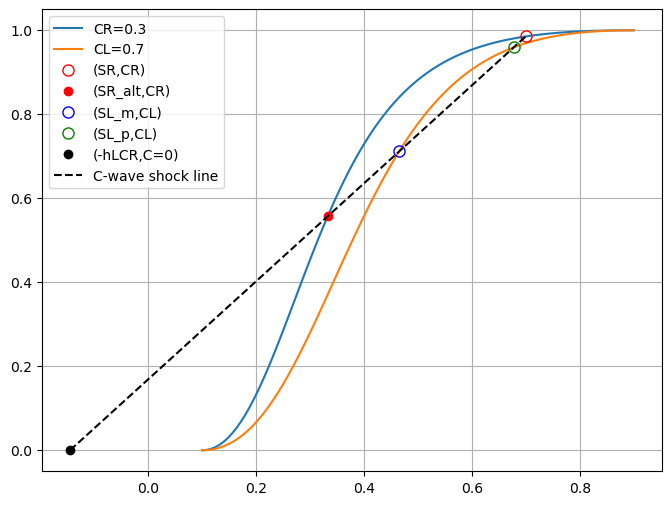

In [87]:
SR = 0.7; CR = 0.3
CL = 0.7

# Guestimate of the split point
Smid = 0.6
SL_m = brentq(lambda Sw: ff_ana.hugo(Sw,C=CL,Sst=SR,Cst=CR),ff_ana.Scw,Smid)
SL_p = brentq(lambda Sw: ff_ana.hugo(Sw,C=CL,Sst=SR,Cst=CR),Smid, 1.0-ff_ana.Scw)
hLCR = ff_ana.Dads(CR,CL)
SR_alt =  brentq(lambda Sw: ff_ana.hugo(Sw,C=CR,Sst=SL_m,Cst=CL),ff_ana.Scw,Smid)

Ss = np.linspace(ff_ana.Scw, 1.0-ff_ana.Sorw, 101)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Ss, ff_ana.fw(Ss,CR), label=f'CR={CR}')
ax.plot(Ss, ff_ana.fw(Ss,CL), label=f'CL={CL}')
ax.plot(SR,ff_ana.fw(SR,CR), 'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.plot(SR_alt,ff_ana.fw(SR_alt,CR), 'ro', label='(SR_alt,CR)')
ax.plot(SL_m,ff_ana.fw(SL_m,CL), 'bo', markersize=8, fillstyle='none', label='(SL_m,CL)')
ax.plot(SL_p,ff_ana.fw(SL_p,CL), 'go', markersize=8, fillstyle='none', label='(SL_p,CL)')

ax.plot(-hLCR,0, 'ko', label='(-hLCR,C=0)')

ax.plot((-hLCR,SR),(0,ff_ana.fw(SR,CR)), 'k--', label='C-wave shock line')
ax.grid()
ax.legend()

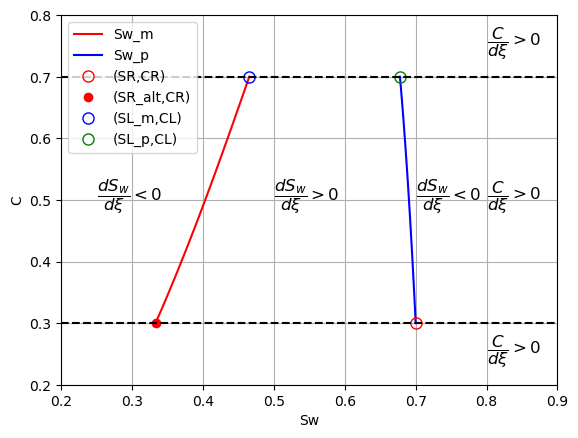

In [88]:
SR = 0.7; CR = 0.3
# SR = SR_alt; CR = 0.3
CL = 0.7

def Sw_PlusMin(Sw,C, CL,SR,CR,ff):
    hLCR= ff.Dads(CL,CR)
    sigma = ff.shockC_vel(CL,SR,CR)
    return ff.fw(Sw,C)/(Sw+hLCR) - sigma

# Quick view on Sw- and Sw+
Sw = np.linspace(ff_ana.Scw,1.0-ff_ana.Sorw, 501)
C  = np.linspace(0,1,501)
Sx, Cy = np.meshgrid(Sw, C)
Sw_PM = Step(Sw_PlusMin(Sx,Cy,CL,SR,CR,ff_ana))

# plt.figure(figsize=(8,6))
# plt.contourf(Sx, Cy, Sw_PM, cmap='viridis')
# plt.colorbar(label = 'Hugoniot')
# plt.title(f'Sw- amd Sw+ for SR={SR:4.2},CR={CR:4.2f} and CL={CL:4.2f} is at the interface of the colored interfaces')
# plt.xlim(0,1)
# plt.xlabel('Sw')
# plt.ylabel('C')

# Determine the Sw- and Sw+ curves in two steps
# Step 1
# Establish an Sw boundary between the Sw- and Sw+ curves
flag1 = False
flag2 = False
count = 0
C_PM = pd.Series(name='C')
Ss = np.linspace(ff_ana.Scw,1.0-ff_ana.Sorw,101)
for Sw in Ss:
    try:
        C = brentq(lambda C: Sw_PlusMin(Sw,C,CL,SR,CR,ff_ana),0,1)
        C_PM[Sw] = C
        if count == 0:
            flag1 = True
            count = 1
        if flag2:
            Sw_2 = Sw
            flag2 = False
    except ValueError as e:
        if flag1:
            Sw_1 = Sw
            flag1 = False
            flag2 = True

C_PM = C_PM.to_frame().reset_index(names='Sw')

# fig, ax = plt.subplots()
# C_PM.plot(x='Sw',y='C',ax=ax,style='r.',label='Sw- and Sw+')
# ax.set_xlabel('Sw')
# ax.set_ylabel('C')
# ax.grid()

Smid = (Sw_1+Sw_2)/2

# Step 2
Cs = np.linspace(CR,CL,101)
Sw_m = pd.Series(name='Sw')
Sw_p = pd.Series(name='Sw')
for C in Cs:
    Sw_m[C] = brentq(lambda Sw: Sw_PlusMin(Sw,C,CL,SR,CR,ff_ana),ff_ana.Scw,Smid, xtol=1e-15)
    Sw_p[C] = brentq(lambda Sw: Sw_PlusMin(Sw,C,CL,SR,CR,ff_ana),Smid,1.0-ff_ana.Sorw, xtol=1e-15)

Sw_m = Sw_m.to_frame().reset_index(names='C')
Sw_p = Sw_p.to_frame().reset_index(names='C')

fig, ax = plt.subplots()
Sw_m.plot(x='Sw',y='C',ax=ax,style='r-',label='Sw_m')
Sw_p.plot(x='Sw',y='C',ax=ax,style='b-',label='Sw_p')
ax.plot(SR,CR, 'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.plot(SR_alt,CR, 'ro', label='(SR_alt,CR)')
ax.plot(SL_m,CL, 'bo', markersize=8, fillstyle='none', label='(SL_m,CL)')
ax.plot(SL_p,CL, 'go', markersize=8, fillstyle='none', label='(SL_p,CL)')
ax.hlines(CR,0.2,0.9,colors='k',linestyles='dashed')
ax.hlines(CL,0.2,0.9,colors='k',linestyles='dashed')
ax.text(0.5,0.5,r'$\dfrac{dS_w}{d \xi}>0$', fontsize=12)
ax.text(0.25,0.5,r'$\dfrac{dS_w}{d \xi}<0$', fontsize=12)
ax.text(0.7,0.5,r'$\dfrac{dS_w}{d \xi}<0$', fontsize=12)
ax.text(0.8,0.75,r'$\dfrac{C}{d \xi}>0$', fontsize=12)
ax.text(0.8,0.5,r'$\dfrac{C}{d \xi}>0$', fontsize=12)
ax.text(0.8,0.25,r'$\dfrac{C}{d \xi}>0$', fontsize=12)
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_xlim(0.2,0.9)
ax.set_ylim(0.2,0.8)
ax.legend()
ax.grid()


## Numerical solution of the differential equation:

$$
\begin{cases}
\dfrac{d}{d \xi} S_w = f_w(S_w,C) - \sigma \left( S_w + h_L(C^R) \right) \\
\\
\left(S_w +h(C) \right) \dfrac{d}{d \xi} C = \sigma \left(C - C^L\right) \left(h_L(C^R) - h_L(C) \right)
\end{cases}
$$
where
$$
\begin{align}
\sigma & = \dfrac{f_w(S_w^L,C^L)}{S_w^L + h_L(C^R)} \\
\\
h(C) &= \dfrac{d a}{d C} \\
\\
h_L(C) &= \begin{cases}
          \dfrac{a(C)-a(C^L)}{C-C^L}  && \text{if  } C \neq C^L \\
          h(C)                        && \text{if  } C = C^L
          \end{cases}
\end{align}
$$

In [89]:
print(f'SR={SR:4.2f}, CR={CR:4.2f}')
print(f'CL={CL:4.2f}')

def dS_dksi(S,C,ff):
    sig = ff.shockC_vel(CL,SR,CR, epsAds=1e-15)
    return ff.fw(S,C)-sig*(S+ff.Dads(CL,CR,epsAds=1e-15))

def dC_dksi(S,C,ff):
    sig = ff.shockC_vel(CL,SR,CR, epsAds=1e-15)
    return sig*(C-CL)*(ff.Dads(CL,CR,epsAds=1e-15)-ff.Dads(C,CL,epsAds=1e-15))/(S+ff.dad_C(C))

def ODE(ksi,x,ff):
    S = x[0]
    C = x[1]

    dS = dS_dksi(S,C,ff)
    dC = dC_dksi(S,C,ff)

    return [dS, dC]


# Solution for intial conditions spread over the (Sw,C) state space
Cs = np.linspace(CR,CL,9)
Ss = np.linspace(0.3,0.8,6)
indexM = pd.MultiIndex.from_product([Ss,Cs], names=['Sw','C'])
sol1 = pd.Series(index=indexM, dtype='object')
sol2 = pd.Series(index=indexM, dtype='object')

for C in Cs:
    for Sw in Ss:
        Sw0 = Sw
        C0 = C
        x0 = np.array([Sw0, C0])
        try:
            sol1[Sw,C] = solve_ivp(ODE, [0,100], x0, args=(ff_ana,),method='BDF' )
        except ValueError as e:
            sol1[Sw,C] = None
        try:
            sol2[Sw,C] = solve_ivp(ODE, [0,-100], x0, args=(ff_ana,), method='BDF' )
        except ValueError as e:
            sol2[Sw,C] = None

# Solution for intial conditions on (Sw-(C),C)
sol_m1 = pd.Series()
sol_m2 = pd.Series()
for index, row in Sw_m.iterrows():
    if (index % 10) == 0:
        Sw0 = row['Sw']
        C0 = row['C']
        x0 = np.array([Sw0, C0])
        try:
            sol_m1[index] = solve_ivp(ODE, [0,100], x0, args=(ff_ana,),method='BDF' )
        except ValueError as e:
            pass
        try:
            sol_m2[index] = solve_ivp(ODE, [0,-100], x0, args=(ff_ana,), method='BDF' )
        except ValueError as e:
            pass

# Solution for intial conditions on (Sw+(C),C)
sol_p1 = pd.Series()
sol_p2 = pd.Series()
for index, row in Sw_p.iterrows():
    if (index % 10) == 0:
        Sw0 = row['Sw']
        C0 = row['C']
        x0 = np.array([Sw0, C0])
        try:
            sol_p1[index] = solve_ivp(ODE, [0,100], x0, args=(ff_ana,),method='BDF' )
        except ValueError as e:
            pass
        try:
            sol_p2[index] = solve_ivp(ODE, [0,-100], x0, args=(ff_ana,), method='BDF' )
        except ValueError as e:
            pass

SR=0.70, CR=0.30
CL=0.70


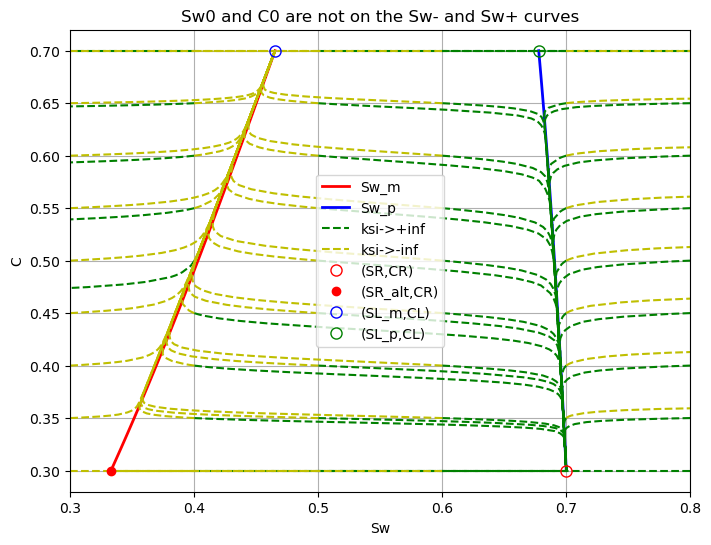

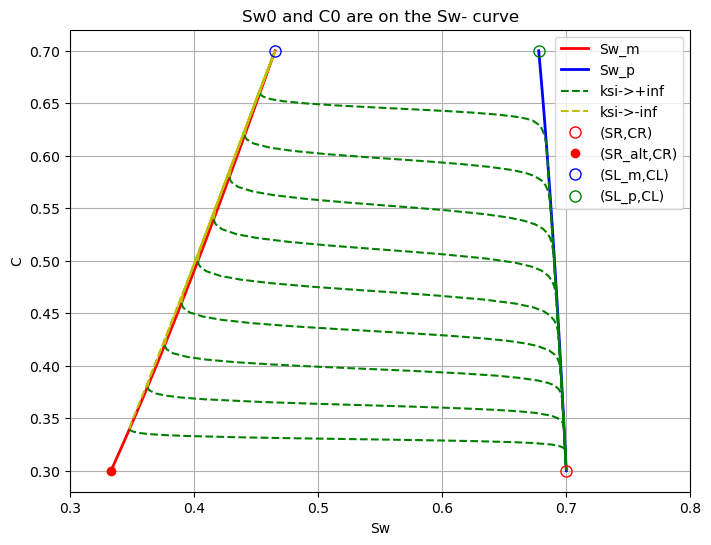

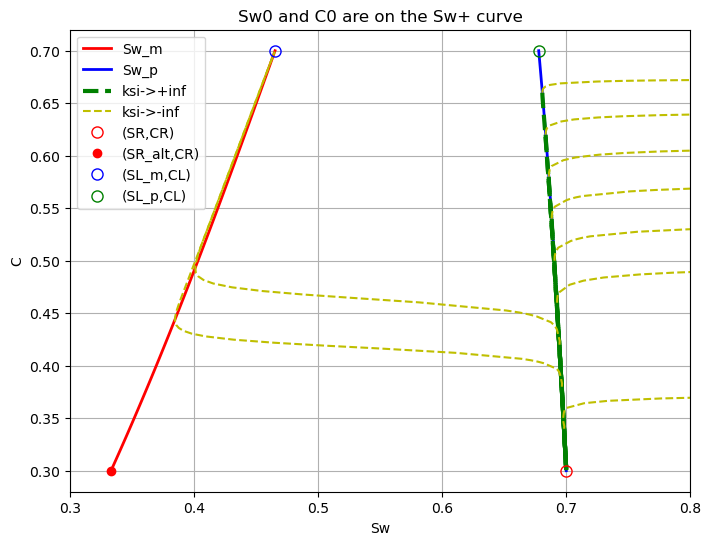

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
Sw_m.plot(x='Sw',y='C',ax=ax,style='r-',label='Sw_m', lw=2)
Sw_p.plot(x='Sw',y='C',ax=ax,style='b-',label='Sw_p', lw=2)
first = True
for data in sol1:
    if data:
        if first:
            ax.plot(data.y[0], data.y[1], 'g--', label='ksi->+inf')
            first = False
        else:
            ax.plot(data.y[0], data.y[1], 'g--')    
first = True
for data in sol2:
    if data:
        if first:
            ax.plot(data.y[0], data.y[1], 'y--', label='ksi->-inf')
            first = False
        else:
            ax.plot(data.y[0], data.y[1], 'y--')
ax.plot(SR,CR, 'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.plot(SR_alt,CR, 'ro', label='(SR_alt,CR)')
ax.plot(SL_m,CL, 'bo', markersize=8, fillstyle='none', label='(SL_m,CL)')
ax.plot(SL_p,CL, 'go', markersize=8, fillstyle='none', label='(SL_p,CL)')
ax.set_title('Sw0 and C0 are not on the Sw- and Sw+ curves')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_xlim(0.3,0.8)
ax.legend()
ax.grid()

fig, ax = plt.subplots(figsize=(8,6))
Sw_m.plot(x='Sw',y='C',ax=ax,style='r-',label='Sw_m', lw=2)
Sw_p.plot(x='Sw',y='C',ax=ax,style='b-',label='Sw_p', lw=2)
first = True
for data in sol_m1:
    if data:
        if first:
            ax.plot(data.y[0], data.y[1], 'g--', label='ksi->+inf')
            first = False
        else:
            ax.plot(data.y[0], data.y[1], 'g--')    
first = True
for data in sol_m2:
    if data:
        if first:
            ax.plot(data.y[0], data.y[1], 'y--', label='ksi->-inf')
            first = False
        else:
            ax.plot(data.y[0], data.y[1], 'y--')
ax.plot(SR,CR, 'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.plot(SR_alt,CR, 'ro', label='(SR_alt,CR)')
ax.plot(SL_m,CL, 'bo', markersize=8, fillstyle='none', label='(SL_m,CL)')
ax.plot(SL_p,CL, 'go', markersize=8, fillstyle='none', label='(SL_p,CL)')
ax.set_title('Sw0 and C0 are on the Sw- curve')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_xlim(0.3,0.8)
ax.legend()
ax.grid()

fig, ax = plt.subplots(figsize=(8,6))
Sw_m.plot(x='Sw',y='C',ax=ax,style='r-',label='Sw_m', lw=2)
Sw_p.plot(x='Sw',y='C',ax=ax,style='b-',label='Sw_p', lw=2)
first = True
for data in sol_p1:
    if data:
        if first:
            ax.plot(data.y[0], data.y[1], 'g--', label='ksi->+inf', lw=3)
            first = False
        else:
            ax.plot(data.y[0], data.y[1], 'g--', lw=3)    
first = True
for data in sol_p2:
    if data:
        if first:
            ax.plot(data.y[0], data.y[1], 'y--', label='ksi->-inf')
            first = False
        else:
            ax.plot(data.y[0], data.y[1], 'y--')
ax.plot(SR,CR, 'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.plot(SR_alt,CR, 'ro', label='(SR_alt,CR)')
ax.plot(SL_m,CL, 'bo', markersize=8, fillstyle='none', label='(SL_m,CL)')
ax.plot(SL_p,CL, 'go', markersize=8, fillstyle='none', label='(SL_p,CL)')
ax.set_title('Sw0 and C0 are on the Sw+ curve')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.set_xlim(0.3,0.8)
ax.legend()
ax.grid()

In [91]:
Sw0 = Sw_m['Sw'].iloc[2]
C0 = Sw_m['C'].iloc[2] 
Sw0 = Sw_p['Sw'].iloc[20]
C0 = Sw_p['C'].iloc[20] 
x0 = np.array([Sw0, C0])
try:
    sol1 = solve_ivp(ODE, [0,1000], x0, args=(ff_ana,),method='BDF' )
except ValueError as e:
    sol1 = None
try:
    sol2 = solve_ivp(ODE, [0,-10], x0, args=(ff_ana,), method='BDF' )
except ValueError as e:
    sol2 = None

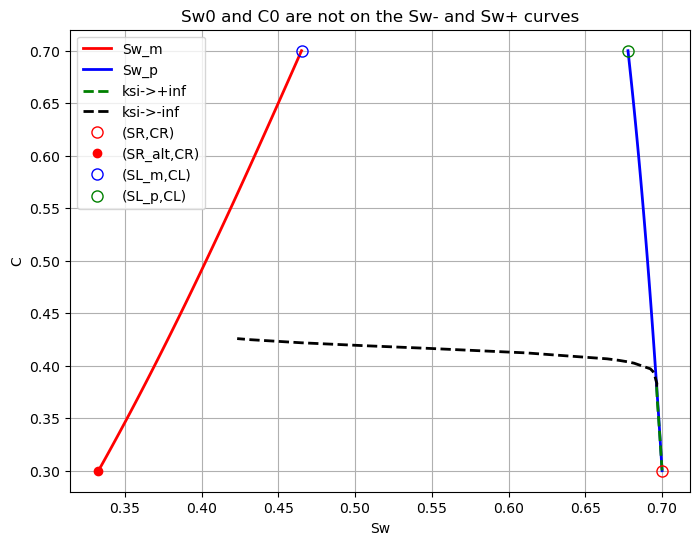

In [92]:
fig, ax = plt.subplots(figsize=(8,6))
Sw_m.plot(x='Sw',y='C',ax=ax,style='r-',label='Sw_m', lw=2)
Sw_p.plot(x='Sw',y='C',ax=ax,style='b-',label='Sw_p', lw=2)

if sol1:
    ax.plot(sol1.y[0], sol1.y[1], 'g--', label='ksi->+inf', lw=2)
if sol2:
    ax.plot(sol2.y[0], sol2.y[1], 'k--', label='ksi->-inf', lw=2)

ax.plot(SR,CR, 'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.plot(SR_alt,CR, 'ro', label='(SR_alt,CR)')
ax.plot(SL_m,CL, 'bo', markersize=8, fillstyle='none', label='(SL_m,CL)')
ax.plot(SL_p,CL, 'go', markersize=8, fillstyle='none', label='(SL_p,CL)')
ax.set_title('Sw0 and C0 are not on the Sw- and Sw+ curves')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
# ax.set_xlim(0.3,0.8)
ax.legend()
ax.grid()

## Some general integral and Hugoniot locus plots combined with speed diagrams

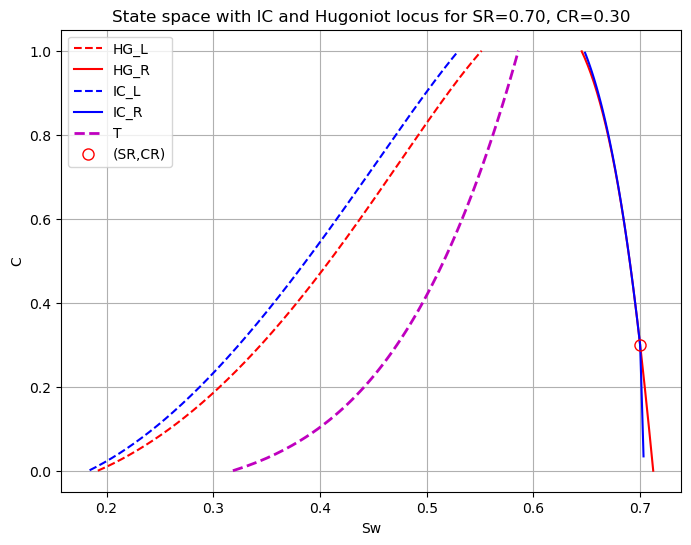

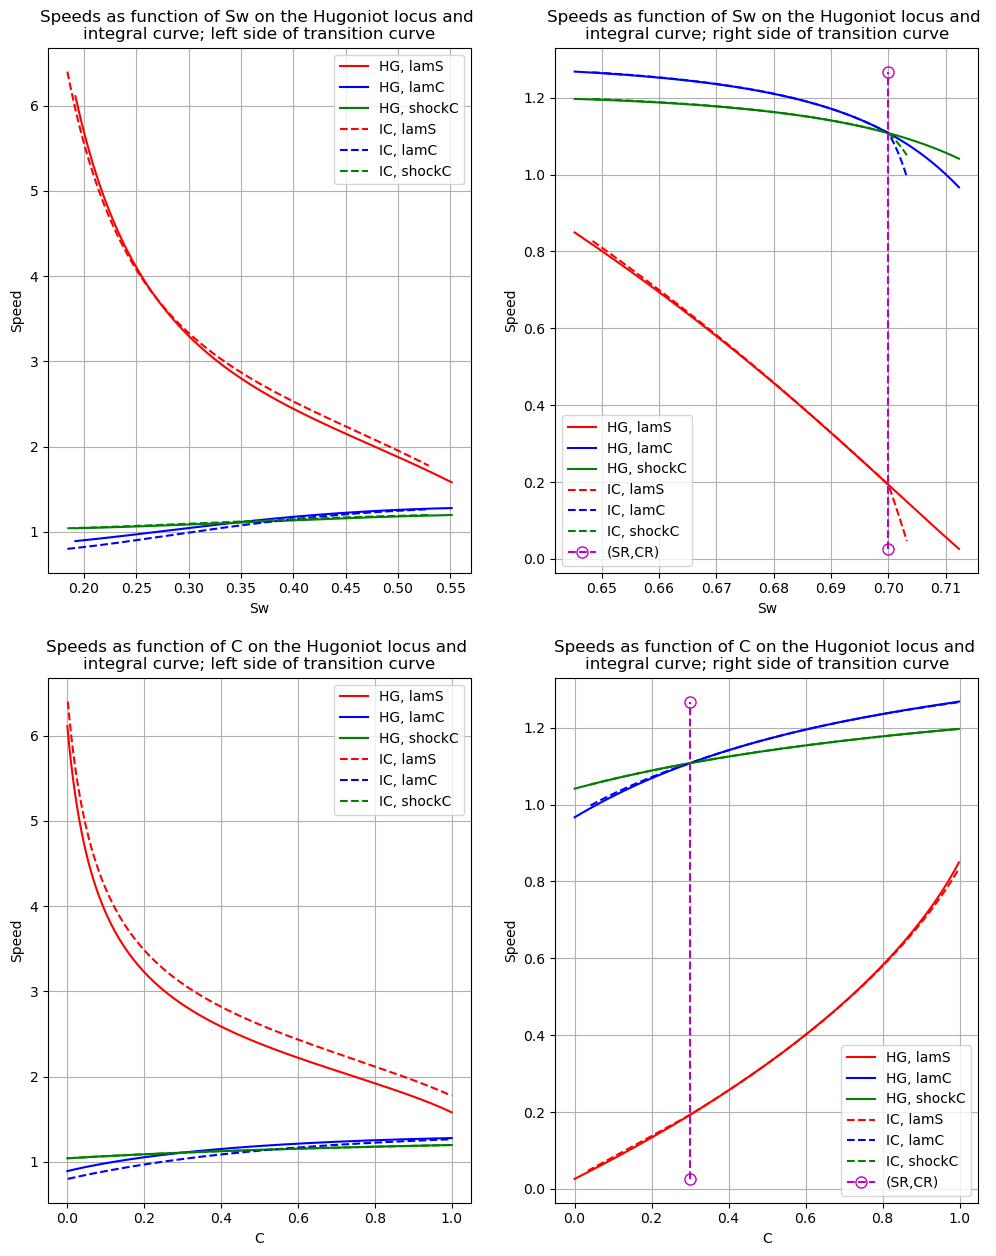

In [93]:
# Determine the Hugoniot locus and integral curve for (SR,CR)
SR = 0.7; CR = 0.3

# Hugoniot locus
eps_S = 1e-8
eps_C=1e-4

Cs = np.linspace(0,CR-eps_C,501)
S1 = pd.Series(name='Sw')
S2 = pd.Series(name='Sw')

for C in Cs:
    S = brentq(lambda Sw: ff_ana.hugo(Sw,C=C,Sst=SR,Cst=CR,epsAds=1e-8),ff_ana.Scw,SR-eps_S)
    S1[C] = S
    found = False
    try:
        S = brentq(lambda Sw: ff_ana.hugo(Sw,C=C,Sst=SR,Cst=CR,epsAds=1e-8),SR,1.0-ff_ana.Sorw)
        S2[C] = S
        found = True
    except ValueError as e:
        print(f'For C = {C:4.2f} no solution')

if found:
    Ss = np.linspace(S1.iloc[-1],S2.iloc[-1],501)
    C1 = pd.Series(name='C')

    for S in Ss:
        C = brentq(lambda C: ff_ana.hugo(Sw=S,C=C,Sst=SR,Cst=CR,epsAds=1e-8),0,1e5)
        C1[S] = C
else:
    Cs = np.linspace(CR,1,501)
    S3 = pd.Series(name='Sw')

    for C in Cs:
        S = brentq(lambda Sw: ff_ana.hugo(Sw, C=C,Sst=SR,Cst=CR,epsAds=1e-8),ff_ana.Scw,1.0-ff_ana.Sorw)
        S3[C] = S

HG1 = S1.to_frame().reset_index(names='C')
if found:
    HG2 = S2.to_frame().reset_index(names='C')
    HG3 = C1.to_frame().reset_index(names='Sw')
else:
    HG2 = S3.to_frame().reset_index(names='C')

HG = pd.concat([HG1,HG2])
if found: HG = pd.concat([HG,HG3])
HG = HG.sort_values(by='Sw').reset_index(drop=True)

# Integral curve
# Keeping away from singularity
eps_S = 1e-8
# Branch: Scw <= Sw <= Sw1_IC
IC_S1 = np.linspace(SR,ff_ana.Scw,501)
IC_C1 = odeint(ff_ana.dC_dS,CR,IC_S1)
IC1 = pd.DataFrame(data={'Sw':IC_S1,'C':IC_C1.T[0]})

# Branch: Sw1_IC <= Sw <= 1-Sorw
IC_S2 = np.linspace(SR,1.0-ff_ana.Sorw-eps_S,501)
IC_C2 = odeint(ff_noads.dC_dS,CR,IC_S2)
IC2 = pd.DataFrame(data={'Sw':IC_S2,'C':IC_C2.T[0]})

IC = pd.concat([IC1,IC2])
IC = IC.sort_values(by='Sw').reset_index(drop=True)

# Split HG and IC into two branches, one Sw left of T line (HG_L, IC_L)
# and one right of T line (HG_R, IC_R)
Sw_split = T['Sw'].max()

HG_L = HG[(HG['Sw']<Sw_split) & (HG['C']>=0) & (HG['C']<=1)]
HG_R = HG[(HG['Sw']>=Sw_split) & (HG['C']>=0) & (HG['C']<=1)]
IC_L = IC[(IC['Sw']<Sw_split) & (IC['C']>=0) & (IC['C']<=1)]
IC_R = IC[(IC['Sw']>=Sw_split) & (IC['C']>=0) & (IC['C']<=1)]

fig, ax = plt.subplots(figsize=(8,6))
HG_L.plot(x='Sw',y='C',ax=ax,style='r--',label='HG_L')
HG_R.plot(x='Sw',y='C',ax=ax,style='r-',label='HG_R')
IC_L.plot(x='Sw',y='C',ax=ax,style='b--',label='IC_L')
IC_R.plot(x='Sw',y='C',ax=ax,style='b-',label='IC_R')
T.plot(x='Sw',y='C',ax=ax,style='m--',label='T',lw=2)
ax.plot(SR,CR,'ro', markersize=8, fillstyle='none', label='(SR,CR)')
ax.set_title(f'State space with IC and Hugoniot locus for SR={SR:4.2f}, CR={C:4.2f}')
ax.set_xlabel('Sw')
ax.set_ylabel('C')
ax.legend()
ax.grid()

sig_max_L = max(ff_ana.lamS(HG_L['Sw'],HG_L['C']).max(),
                ff_ana.lamC(HG_L['Sw'],HG_L['C']).max(),
                ff_ana.shockC_vel(HG_L['C'],SR,CR).max())
sig_min_L = min(ff_ana.lamS(HG_L['Sw'],HG_L['C']).min(),
                ff_ana.lamC(HG_L['Sw'],HG_L['C']).min(),
                ff_ana.shockC_vel(HG_L['C'],SR,CR).min())

sig_max_R = max(ff_ana.lamS(HG_R['Sw'],HG_R['C']).max(),
                ff_ana.lamC(HG_R['Sw'],HG_R['C']).max(),
                ff_ana.shockC_vel(HG_R['C'],SR,CR).max())
sig_min_R = min(ff_ana.lamS(HG_R['Sw'],HG_R['C']).min(),
                ff_ana.lamC(HG_R['Sw'],HG_R['C']).min(),
                ff_ana.shockC_vel(HG_R['C'],SR,CR).min())

fig, ax = plt.subplots(2,2,figsize=(12,15))
ax[0,0].plot(HG_L['Sw'],ff_ana.lamS(HG_L['Sw'],HG_L['C']), 'r-', label='HG, lamS')
ax[0,0].plot(HG_L['Sw'],ff_ana.lamC(HG_L['Sw'],HG_L['C']), 'b-', label='HG, lamC')
ax[0,0].plot(HG_L['Sw'],ff_ana.shockC_vel(HG_L['C'],SR,CR), 'g-', label='HG, shockC')
ax[0,0].plot(IC_L['Sw'],ff_ana.lamS(IC_L['Sw'],IC_L['C']), 'r--', label='IC, lamS')
ax[0,0].plot(IC_L['Sw'],ff_ana.lamC(IC_L['Sw'],IC_L['C']), 'b--', label='IC, lamC')
ax[0,0].plot(IC_L['Sw'],ff_ana.shockC_vel(IC_L['C'],SR,CR), 'g--', label='IC, shockC')
if SR<Sw_split:
    ax[0,0].plot((SR,SR),(sig_min_L,sig_max_L),'mo--', markersize=8, fillstyle='none', label='(SR,CR)')
ax[0,0].set_title('Speeds as function of Sw on the Hugoniot locus and \nintegral curve; left side of transition curve')
ax[0,0].set_xlabel('Sw')
ax[0,0].set_ylabel('Speed')
ax[0,0].legend()
ax[0,0].grid()

ax[0,1].plot(HG_R['Sw'],ff_ana.lamS(HG_R['Sw'],HG_R['C']), 'r-', label='HG, lamS')
ax[0,1].plot(HG_R['Sw'],ff_ana.lamC(HG_R['Sw'],HG_R['C']), 'b-', label='HG, lamC')
ax[0,1].plot(HG_R['Sw'],ff_ana.shockC_vel(HG_R['C'],SR,CR), 'g-', label='HG, shockC')
ax[0,1].plot(IC_R['Sw'],ff_ana.lamS(IC_R['Sw'],IC_R['C']), 'r--', label='IC, lamS')
ax[0,1].plot(IC_R['Sw'],ff_ana.lamC(IC_R['Sw'],IC_R['C']), 'b--', label='IC, lamC')
ax[0,1].plot(IC_R['Sw'],ff_ana.shockC_vel(IC_R['C'],SR,CR), 'g--', label='IC, shockC')
if SR>=Sw_split:
    ax[0,1].plot((SR,SR),(sig_min_R,sig_max_R),'mo--', markersize=8, fillstyle='none', label='(SR,CR)')
ax[0,1].set_title('Speeds as function of Sw on the Hugoniot locus and \nintegral curve; right side of transition curve')
ax[0,1].set_xlabel('Sw')
ax[0,1].set_ylabel('Speed')
ax[0,1].legend()
ax[0,1].grid()

ax[1,0].plot(HG_L['C'],ff_ana.lamS(HG_L['Sw'],HG_L['C']), 'r-', label='HG, lamS')
ax[1,0].plot(HG_L['C'],ff_ana.lamC(HG_L['Sw'],HG_L['C']), 'b-', label='HG, lamC')
ax[1,0].plot(HG_L['C'],ff_ana.shockC_vel(HG_L['C'],SR,CR), 'g-', label='HG, shockC')
ax[1,0].plot(IC_L['C'],ff_ana.lamS(IC_L['Sw'],IC_L['C']), 'r--', label='IC, lamS')
ax[1,0].plot(IC_L['C'],ff_ana.lamC(IC_L['Sw'],IC_L['C']), 'b--', label='IC, lamC')
ax[1,0].plot(IC_L['C'],ff_ana.shockC_vel(IC_L['C'],SR,CR), 'g--', label='IC, shockC')
if SR<Sw_split:
    ax[1,0].plot((CR,CR),(sig_min_L,sig_max_L),'mo--', markersize=8, fillstyle='none', label='(SR,CR)')
ax[1,0].set_title('Speeds as function of C on the Hugoniot locus and \nintegral curve; left side of transition curve')
ax[1,0].set_xlabel('C')
ax[1,0].set_ylabel('Speed')
ax[1,0].legend()
ax[1,0].grid()

ax[1,1].plot(HG_R['C'],ff_ana.lamS(HG_R['Sw'],HG_R['C']), 'r-', label='HG, lamS')
ax[1,1].plot(HG_R['C'],ff_ana.lamC(HG_R['Sw'],HG_R['C']), 'b-', label='HG, lamC')
ax[1,1].plot(HG_R['C'],ff_ana.shockC_vel(HG_R['C'],SR,CR), 'g-', label='HG, shockC')
ax[1,1].plot(IC_R['C'],ff_ana.lamS(IC_R['Sw'],IC_R['C']), 'r--', label='IC, lamS')
ax[1,1].plot(IC_R['C'],ff_ana.lamC(IC_R['Sw'],IC_R['C']), 'b--', label='IC, lamC')
ax[1,1].plot(IC_R['C'],ff_ana.shockC_vel(IC_R['C'],SR,CR), 'g--', label='IC, shockC')
if SR>=Sw_split:
    ax[1,1].plot((CR,CR),(sig_min_R,sig_max_R),'mo--', markersize=8, fillstyle='none', label='(SR,CR)')
ax[1,1].set_title('Speeds as function of C on the Hugoniot locus and \nintegral curve; right side of transition curve')
ax[1,1].set_xlabel('C')
ax[1,1].set_ylabel('Speed')
# ax[2,1].set_ylim(1.0,1.3)
ax[1,1].legend()
ax[1,1].grid()
